In [2]:
import json
import os
import time

import mambapy
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import torch
from mambapy.mamba import Mamba, MambaConfig
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm, trange

from utils.experiments import ParamGrid

In [3]:
config = mambapy.mamba.MambaConfig(d_model=16, n_layers=2)
mamba = Mamba(config)
mamba

Mamba(
  (layers): ModuleList(
    (0-1): 2 x ResidualBlock(
      (mixer): MambaBlock(
        (in_proj): Linear(in_features=16, out_features=64, bias=False)
        (conv1d): Conv1d(32, 32, kernel_size=(4,), stride=(1,), padding=(3,), groups=32)
        (x_proj): Linear(in_features=32, out_features=33, bias=False)
        (dt_proj): Linear(in_features=1, out_features=32, bias=True)
        (out_proj): Linear(in_features=32, out_features=16, bias=False)
      )
      (norm): RMSNorm()
    )
  )
)

In [4]:
rb = mambapy.mamba.ResidualBlock(config)
rb

ResidualBlock(
  (mixer): MambaBlock(
    (in_proj): Linear(in_features=16, out_features=64, bias=False)
    (conv1d): Conv1d(32, 32, kernel_size=(4,), stride=(1,), padding=(3,), groups=32)
    (x_proj): Linear(in_features=32, out_features=33, bias=False)
    (dt_proj): Linear(in_features=1, out_features=32, bias=True)
    (out_proj): Linear(in_features=32, out_features=16, bias=False)
  )
  (norm): RMSNorm()
)

In [5]:
test_x = torch.as_tensor(np.random.random((10, 8, 16)), dtype=torch.float32)
rb(test_x).shape

torch.Size([10, 8, 16])

In [6]:
mamba(test_x).shape

torch.Size([10, 8, 16])

In [7]:
os.listdir('neuro/data/v4/')

['2025-02-21_07:47:53',
 '2025-02-21_21:00:02',
 '2025-02-22_10:26:24',
 '2025-02-22_23:55:39',
 '2025-02-23_13:30:49',
 '2025-02-24_03:04:19',
 '2025-02-24_17:02:11',
 '2025-02-25_06:55:14',
 '2025-02-25_20:45:55',
 '2025-02-26_10:42:38']

In [13]:
test_data = pd.read_csv('neuro/data/v4/2025-02-26_10:42:38/data.csv', index_col=0)
test_data.head()

timestamps     k_inf         heat          U235          U238
0         0.0  1.231874     0.000199  2.797154e+23  5.243735e+24
1     21600.0  1.229625  3713.085096  2.796650e+23  5.243707e+24
2     43200.0  1.218374  3806.594515  2.796146e+23  5.243678e+24
3     64800.0  1.208360  3852.718555  2.795642e+23  5.243649e+24
4     86400.0  1.202874  3887.095841  2.795137e+23  5.243619e+24

In [14]:
test_data.describe()

timestamps       k_inf         heat          U235          U238
count  5.270000e+02  527.000000   527.000000  5.270000e+02  5.270000e+02
mean   5.680800e+06    1.174160  4112.043980  2.668884e+23  5.235888e+24
std    3.289163e+06    0.014416   184.326318  7.297164e+21  4.577285e+21
min    0.000000e+00    1.145007     0.000199  2.544998e+23  5.227930e+24
25%    2.840400e+06    1.162296  4124.595847  2.605624e+23  5.231942e+24
50%    5.680800e+06    1.173121  4134.693646  2.667781e+23  5.235914e+24
75%    8.521200e+06    1.184605  4136.494884  2.731584e+23  5.239850e+24
max    1.136160e+07    1.231874  4139.304378  2.797154e+23  5.243735e+24

In [66]:
def normalize(df: pd.DataFrame):
    # tsp = list(df.timestamps.values[1:] - df.timestamps.values[:-1])
    # tsp.append(tsp[-1])
    # df['timestamps'] = tsp
    df['timestamps'] /=3600
    df['k_inf'] -= 1
    # print(savgol_filter(df['k_inf'], 7, 4).shape, df['k_inf'].shape)
    # kinf0 = df['k_inf'].values[2:]
    # kinf1 = df['k_inf'].values[1:-1]
    # kinf2 = df['k_inf'].values[:-2]
    # kinf = list((kinf0+kinf1+kinf2)/3)
    # kinf.append(kinf2[0])
    # kinf.append(kinf0[-1])
    df['k_inf'] = savgol_filter(df['k_inf'], 25, 2)
    
    # u5 = df['U235'].values[1:]- df['U235'].values[:-1]
    # u5= list(u5)
    # u5.append(u5[-1])
    # u8 = df['U238'].values[1:]- df['U238'].values[:-1]
    # u8= list(u8)
    # u8.append(u8[-1])
    # df['heat'] /= 2100
    # df['U235'] = u5
    # df['U238'] = u8
    return df

In [67]:
test_data_normed = test_data.copy()
test_data_normed = normalize(test_data_normed)
test_data_normed.describe()

timestamps       k_inf         heat          U235          U238
count   527.000000  527.000000   527.000000  5.270000e+02  5.270000e+02
mean   1578.000000    0.174174  4112.043980  2.668884e+23  5.235888e+24
std     913.656391    0.013983   184.326318  7.297164e+21  4.577285e+21
min       0.000000    0.152311     0.000199  2.544998e+23  5.227930e+24
25%     789.000000    0.162508  4124.595847  2.605624e+23  5.231942e+24
50%    1578.000000    0.173501  4134.693646  2.667781e+23  5.235914e+24
75%    2367.000000    0.183824  4136.494884  2.731584e+23  5.239850e+24
max    3156.000000    0.222779  4139.304378  2.797154e+23  5.243735e+24

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

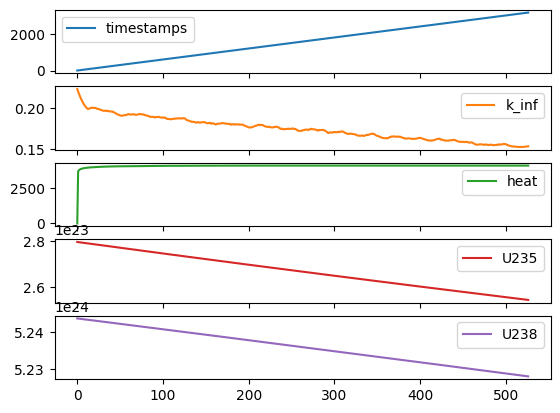

In [68]:
test_data_normed.plot(subplots=True)

<Axes: >

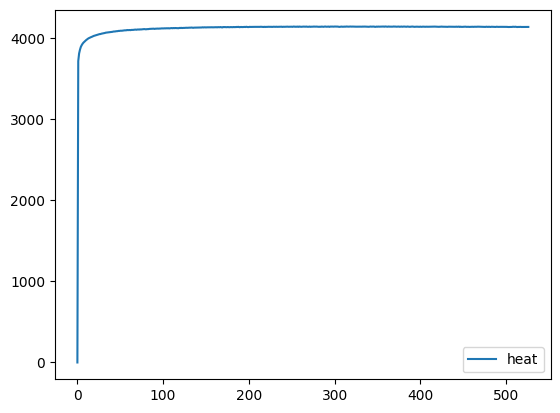

In [69]:
test_data[['heat']].plot()

In [70]:
neuro_data_path = 'neuro/data/v4'

NotADirectoryError: [Errno 20] Not a directory: 'neuro/data/v4/scales.json/data.csv'

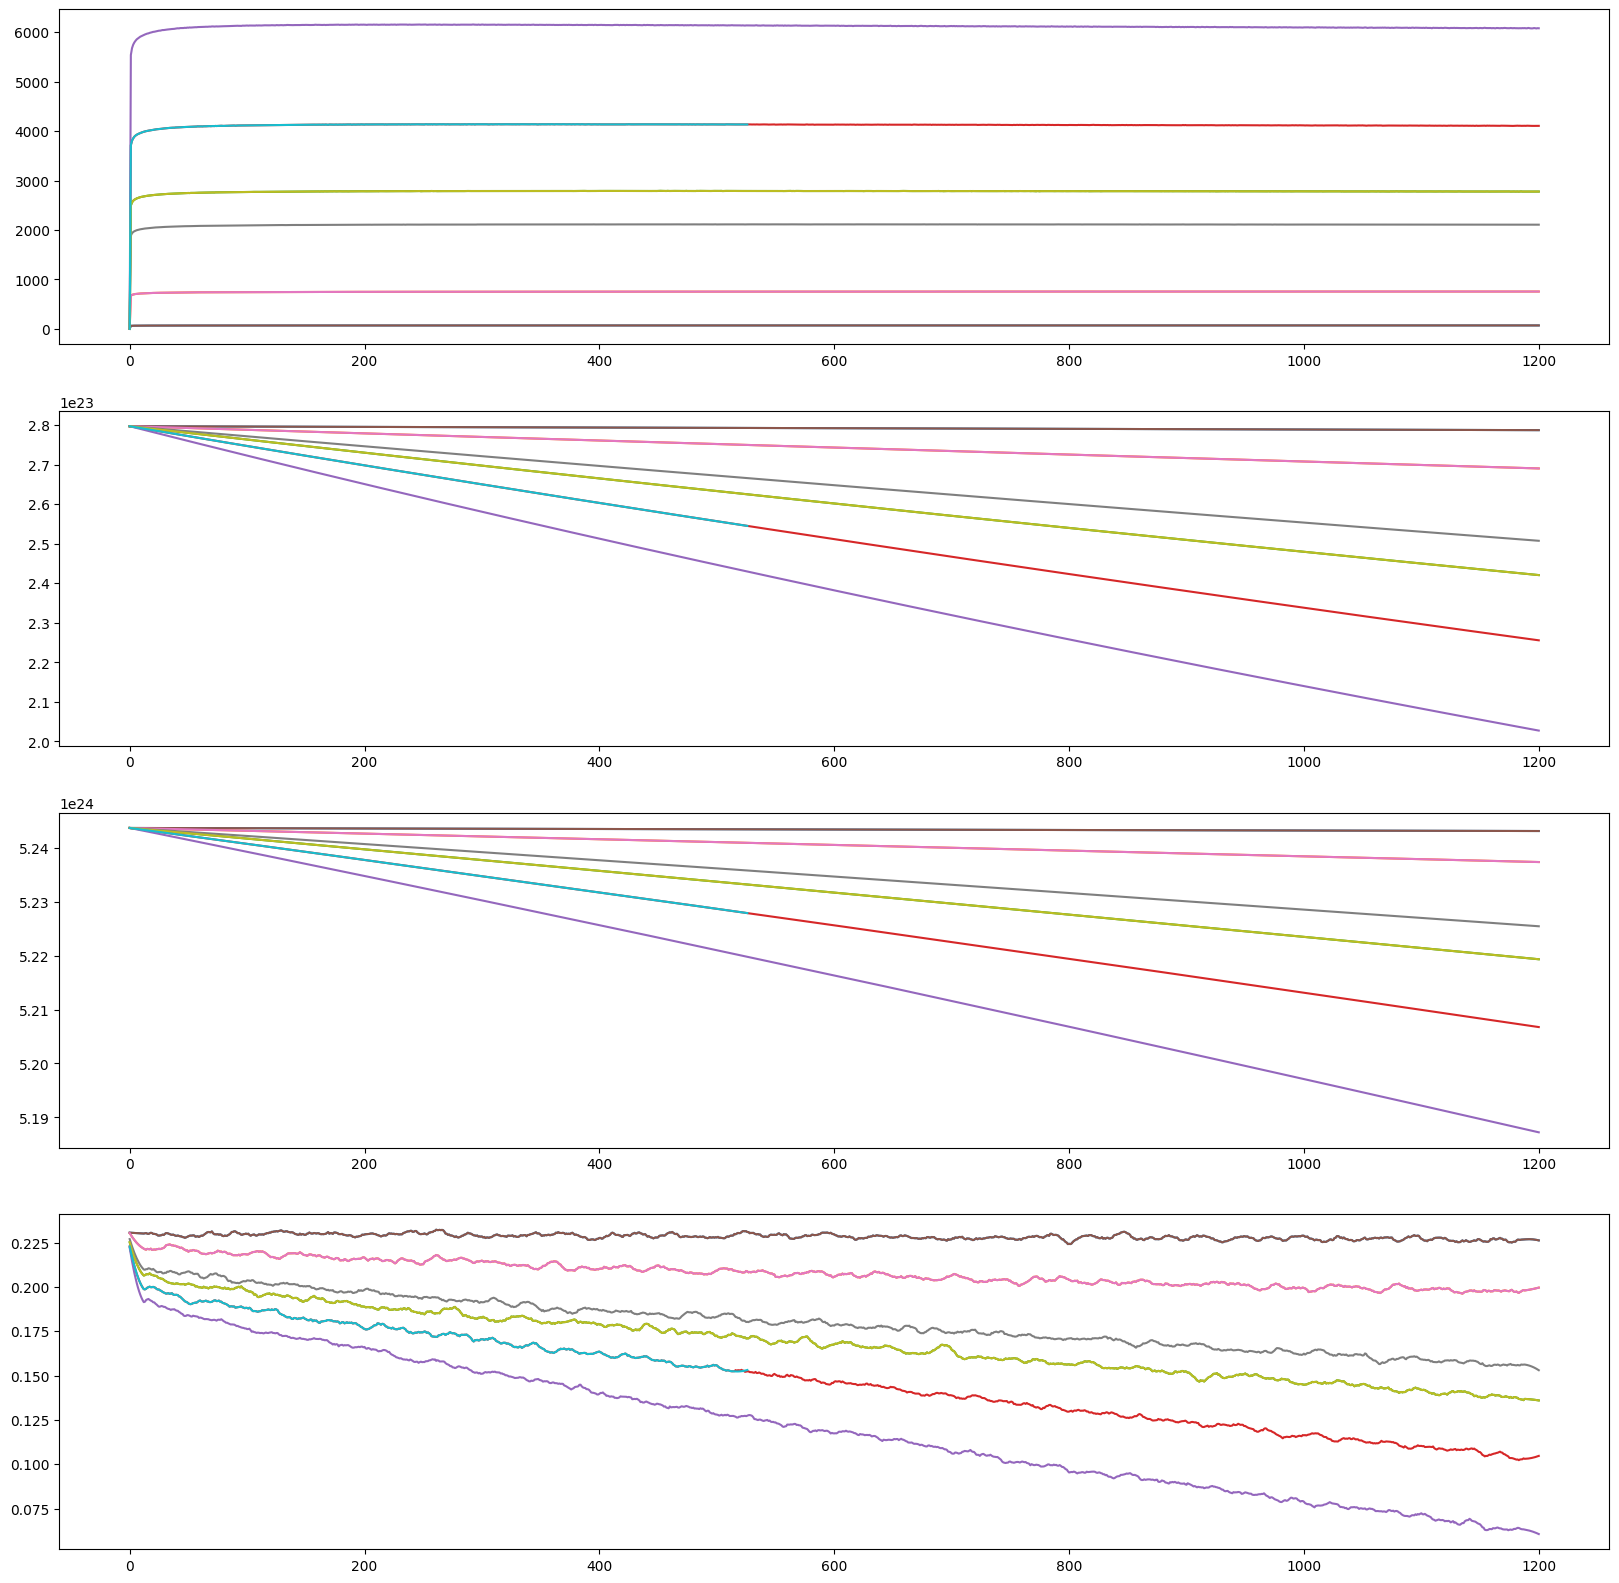

In [71]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))
for i in range(len(os.listdir(neuro_data_path))):
    df_path = os.listdir(neuro_data_path)[i]
    df = pd.read_csv(os.path.join(neuro_data_path, df_path, 'data.csv'), index_col=0)
    df = normalize(df)
    ax[0].plot(df['heat'])
    ax[1].plot(df['U235'])
    # ax[1].set_ylim([0.9,0.91])
    ax[2].plot(df['U238'])
    ax[3].plot(df['k_inf'])


In [72]:
dataset, contexts = [], []
for i in tqdm(range(len(os.listdir(neuro_data_path)))):
    try:
        df_path = os.listdir(neuro_data_path)[i]
        df = pd.read_csv(os.path.join(neuro_data_path, df_path, 'data.csv'), index_col=0)
        df = normalize(df)
        cts = json.load(open(os.path.join(neuro_data_path, df_path, 'context.json')))
        dataset.append(df.values)
        contexts.append(cts)
    except Exception as e:
        print(e)
print(dataset)
dataset = np.array(dataset[:-1])
dataset.shape, len(contexts)

100%|██████████| 11/11 [00:00<00:00, 439.30it/s]

[Errno 20] Not a directory: 'neuro/data/v4/scales.json/data.csv'
[array([[0.00000000e+00, 2.30567815e-01, 1.98962981e-04, 2.79715443e+23,
        5.24373545e+24],
       [6.00000000e+00, 2.30525088e-01, 6.08811124e+01, 2.79714616e+23,
        5.24373498e+24],
       [1.20000000e+01, 2.30482779e-01, 6.23806406e+01, 2.79713789e+23,
        5.24373451e+24],
       ...,
       [7.18800000e+03, 2.26502660e-01, 6.89114337e+01, 2.78726930e+23,
        5.24317045e+24],
       [7.19400000e+03, 2.26368492e-01, 6.89399264e+01, 2.78726107e+23,
        5.24316998e+24],
       [7.20000000e+03, 2.26214652e-01, 6.89218158e+01, 2.78725284e+23,
        5.24316951e+24]], shape=(1201, 5)), array([[0.00000000e+00, 2.30350612e-01, 1.98962981e-04, 2.79715443e+23,
        5.24373545e+24],
       [6.00000000e+00, 2.29279823e-01, 6.69670150e+02, 2.79706344e+23,
        5.24373026e+24],
       [1.20000000e+01, 2.28270487e-01, 6.86173403e+02, 2.79697249e+23,
        5.24372510e+24],
       ...,
       [7.18800000

((9, 1201, 5), 10)

In [73]:
scales = {
    'timestamps': {'min': 0, 'max':3200},
    'k_inf': {
        'min': 0,
        'max': 1
    },

}
for col, _min, _max in zip(df.columns, dataset.min(axis=(0, 1)), dataset.max(axis=(0, 1))):
    if col in scales:
        continue
    scales[col] = {
        'min': _min,
        'max': _max
    }
json.dump(scales, open(os.path.join(neuro_data_path, 'scales.json'), 'w'))
scales

{'timestamps': {'min': 0, 'max': 3200},
 'k_inf': {'min': 0, 'max': 1},
 'heat': {'min': np.float64(0.000198962981389),
  'max': np.float64(6155.853399600044)},
 'U235': {'min': np.float64(2.027206153389757e+23),
  'max': np.float64(2.797154429904509e+23)},
 'U238': {'min': np.float64(5.187219669865002e+24),
  'max': np.float64(5.243735448129248e+24)}}

In [74]:
dataset.min(axis=(0, 1)), dataset.max(axis=(0, 1))

(array([0.00000000e+00, 6.06499005e-02, 1.98962981e-04, 2.02720615e+23,
        5.18721967e+24]),
 array([7.20000000e+03, 2.32238890e-01, 6.15585340e+03, 2.79715443e+23,
        5.24373545e+24]))

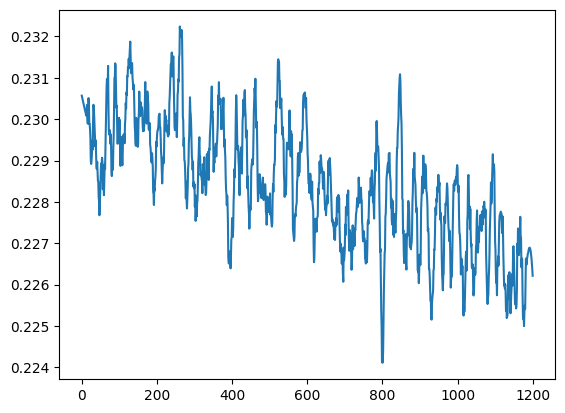

In [75]:
mins, maxs = [], []
for key, value in scales.items():
    mins.append(value['min'])
    maxs.append(value['max'])
mins = np.array(mins)
maxs = np.array(maxs)

scaled = ((dataset - mins) / (maxs - mins))
plt.plot(scaled[0, :, 1])

In [76]:
dataset.max(axis=(0, 1)), dataset.min(axis=(0, 1))

(array([7.20000000e+03, 2.32238890e-01, 6.15585340e+03, 2.79715443e+23,
        5.24373545e+24]),
 array([0.00000000e+00, 6.06499005e-02, 1.98962981e-04, 2.02720615e+23,
        5.18721967e+24]))

In [77]:
mins, maxs

(array([0.00000000e+00, 0.00000000e+00, 1.98962981e-04, 2.02720615e+23,
        5.18721967e+24]),
 array([3.20000000e+03, 1.00000000e+00, 6.15585340e+03, 2.79715443e+23,
        5.24373545e+24]))

In [78]:
scaled[0, ..., 1:]

array([[0.23056781, 0.        , 1.        , 1.        ],
       [0.23052509, 0.00988992, 0.99998926, 0.99999166],
       [0.23048278, 0.01013352, 0.99997852, 0.99998337],
       ...,
       [0.22650266, 0.01119442, 0.9871613 , 0.9900029 ],
       [0.22636849, 0.01119905, 0.98715062, 0.98999452],
       [0.22621465, 0.01119611, 0.98713993, 0.98998616]], shape=(1201, 4))

In [79]:
contexts

[{'enr': 3.0,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'cladding_volume': 537.2123437638545,
  'claddi

In [80]:
class MambaDataset(torch.utils.data.Dataset):

    def __init__(self, data: np.array, context: dict, window_size=16):
        self.data = data
        self.context = context
        self.window_size = window_size

    def __len__(self):
        return self.data.shape[0] - self.window_size + 1

    def __getitem__(self, idx):
        assert idx < len(self), f'idx {idx} out of range'
        _from = max(0, idx - self.window_size)
        window = self.data[_from:idx, :]
        if window.shape[0] < self.window_size:
            zeros = np.zeros((self.window_size - window.shape[0], self.data.shape[1]))
            window = np.vstack((zeros, window))
        pred = self.data[idx:idx + self.window_size, :]
        return window.T, pred.T

In [81]:
test_dataset = MambaDataset(scaled[0, ..., 1:], contexts[0], window_size=8)
test_dataset.data.min(axis=(0))

array([0.22411952, 0.        , 0.98713993, 0.98998616])

In [82]:
contexts

[{'enr': 3.0,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'cladding_volume': 537.2123437638545,
  'claddi

In [83]:
test_context_tensor = torch.as_tensor(np.random.random((4, 8)), dtype=torch.float32).mean(dim=0)
print(test_context_tensor.shape)
# test_ll = torch.nn.Linear(8, 5)
# test_context_tensor = test_ll(test_context_tensor)
test_mamba_tensor = torch.as_tensor(np.random.random((10, 5, 8)), dtype=torch.float32)
(test_context_tensor * test_mamba_tensor).shape

torch.Size([8])


torch.Size([10, 5, 8])

In [84]:
class MyMamba(Mamba):
    train_time = 0

    def __init__(self, config: mambapy.mamba.MambaConfig = None):
        if config is None:
            config = mambapy.mamba.MambaConfig(d_model=8, n_layers=5)
        super().__init__(config)
        self.context_emdedding = torch.nn.Conv1d(1, config.d_model, 1)
        self.context_norm = torch.nn.LayerNorm(config.d_model)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def _reformat_context(self, context):
        _context = (
            context['enr'],
            context['water_volume'],
            context['fuel_volume'],
            context['cladding_volume'],
        )
        _context = torch.as_tensor(np.array(_context)[np.newaxis, :], dtype=torch.float32)
        return _context

    def set_context(self, context: dict):
        self.context = self._reformat_context(context).to(self.device)
        self.cx = self.context_emdedding(self.context).T
        self.cx = self.context_norm(self.cx).mean(dim=0)

    def forward(self, x, context=None):
        if context is None:
            cx = self.cx
        else:
            cx = self.context_emdedding(context).T
            cx = self.context_norm(cx).mean(dim=0)
        x = torch.as_tensor(x, dtype=torch.float32)
        for layer in self.layers:
            x = x + cx
            x = layer(x)
        return x
    
    def _calc_loss(self, true, pred):
        loss_fn = torch.nn.MSELoss(reduction='none')
        loss = (loss_fn(pred, true).mean(dim=1)*(2-true[:,0,:])).mean()
        return loss
        

    def fit(self, data_dicts: list, epochs: int, batch_size: int = 10, savedir='neuro/models'):
        os.makedirs(savedir, exist_ok=True)
        start_train_time = time.perf_counter()
        
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        hist = []
        
        pbar = trange(epochs, desc='Training started...', leave=False)
        for epoch in pbar:
            start = time.perf_counter()
            epoch_loss = []

            pbar.set_description(f'Epoch {epoch}/{epochs}:')
            pbar.refresh()
            optimizer.zero_grad()
            for data_dict in data_dicts:
                context = data_dict['context']
                ds = MambaDataset(data_dict['data'], context, window_size=self.config.d_model)
                self.set_context(data_dict['context'])
                dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=True)
                for x, y in dl:
                    x = torch.as_tensor(x, dtype=torch.float32).to(self.device)
                    y = torch.as_tensor(y, dtype=torch.float32).to(self.device)
                    outputs = self(x, self.context)
                    # Compute the loss and its gradients
                    loss = self._calc_loss(y, outputs)
                    loss.backward()
                    # Adjust learning weights
                    optimizer.step()
                    epoch_loss.append(loss.item())
                    if not hasattr(self, 'best_loss') or loss.item() < self.best_loss:
                        self.best_loss = loss.item()
                        torch.save(self.state_dict(), os.path.join(savedir, 'best.pt'))

            epoch_loss = sum(epoch_loss) / len(epoch_loss)
            pbar.set_postfix_str(f'Loss: {epoch_loss:.4f}. Took {(time.perf_counter() - start) / 60:.2f} minutes')
            hist.append(epoch_loss)

        print(f'Training finished. Best Loss: {self.best_loss}')

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
        ax.plot(hist)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'Loss Curve\nBest Loss: {self.best_loss:.4f}')
        ax.grid()
        delattr(self, 'best_loss')
        plt.savefig(os.path.join(savedir, 'loss.png'))
        torch.save(self.state_dict(), os.path.join(savedir, 'last.pt'))
        self.train_time = time.perf_counter() - start_train_time
        return hist

    def test(self, data, context, savedir='neuro/models'):
        test_dataset = MambaDataset(data, context, window_size=self.config.d_model)
        test_data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
        self.set_context(context)

        true, pred = [], []
        for x, y in test_data_loader:
            x = torch.as_tensor(x, dtype=torch.float32).to(mmb.device)
            y = torch.as_tensor(y, dtype=torch.float32).to(mmb.device)
            true.append(y.cpu().numpy()[0, :, 0])
            pred.append(mmb(x).cpu().detach().numpy()[0, :, 0])
        true = np.array(true)
        pred = np.array(pred)

        fig, ax = plt.subplots(nrows=true.shape[-1], ncols=1, figsize=(20, 20))
        for i in range(len(ax)):
            ax[i].plot(true[:, i], label='true')
            ax[i].plot(pred[:, i], label='pred')
            ax[i].legend()
            ax[i].grid()
        plt.savefig(os.path.join(savedir, 'testing.jpeg'))
        dif = abs((true[:, 3:] - pred[:, 3:]) / true[:, 3:])
        mean_dif  = dif.mean()
        max_dif = dif.max()
        with open(os.path.join(savedir, 'testing_results.json'), 'w') as f:
            json.dump({
                'training_time': int(self.train_time),
                'testing_results': {
                    "mean_dif": float(mean_dif),
                    "max_dif": float(max_dif)
                }
            }, f)
        print(f'Testing finished. Error: {mean_dif*100:.4}%')

In [85]:
prepared_data = [{'data': scaled[i], 'context': contexts[i]} for i in range(1, len(contexts)-1)]

In [86]:
scaled[0]

array([[0.00000000e+00, 2.30567815e-01, 0.00000000e+00, 1.00000000e+00,
        1.00000000e+00],
       [1.87500000e-03, 2.30525088e-01, 9.88992288e-03, 9.99989256e-01,
        9.99991659e-01],
       [3.75000000e-03, 2.30482779e-01, 1.01335168e-02, 9.99978522e-01,
        9.99983375e-01],
       ...,
       [2.24625000e+00, 2.26502660e-01, 1.11944246e-02, 9.87161304e-01,
        9.90002899e-01],
       [2.24812500e+00, 2.26368492e-01, 1.11990532e-02, 9.87150617e-01,
        9.89994525e-01],
       [2.25000000e+00, 2.26214652e-01, 1.11961112e-02, 9.87139928e-01,
        9.89986161e-01]], shape=(1201, 5))

In [87]:
mpg = ParamGrid({
    'd_model': [6,8,14,20],
    'n_layers': [12, 24, 48, 64, 96],
})

dict_keys(['d_model', 'n_layers']) <itertools.product object at 0x7c435f4fa0c0>


Training finished. Best Loss: 0.0015892436495050788
Testing finished. Error: 5.71%


Training finished. Best Loss: 0.0053138695657253265
Testing finished. Error: 10.08%


Training finished. Best Loss: 0.006353148724883795
Testing finished. Error: 6.66%


Training finished. Best Loss: 0.10601747035980225
Testing finished. Error: 13.44%


Training finished. Best Loss: 0.07296977937221527
Testing finished. Error: 45.91%


Training finished. Best Loss: 0.001963860122486949
Testing finished. Error: 6.941%


Training finished. Best Loss: 0.006483590230345726
Testing finished. Error: 11.9%


Training finished. Best Loss: 0.024226969107985497
Testing finished. Error: 12.39%


Training finished. Best Loss: 0.01654215157032013
Testing finished. Error: 8.815%


Training finished. Best Loss: -142.24244689941406
Testing finished. Error: 1.05e+03%


/tmp/ipykernel_26591/1376785347.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))


Training finished. Best Loss: 0.004657533951103687
Testing finished. Error: 9.559%


Training finished. Best Loss: 0.004398503806442022
Testing finished. Error: 6.205%


Training finished. Best Loss: 0.01757298968732357
Testing finished. Error: 8.338%


Training finished. Best Loss: 0.02968803234398365
Testing finished. Error: 20.43%


Training finished. Best Loss: 0.022761257365345955
Testing finished. Error: 8.365%


Training finished. Best Loss: 0.007969500496983528
Testing finished. Error: 9.814%


Training finished. Best Loss: 0.009947960264980793
Testing finished. Error: 3.554%


Training finished. Best Loss: -255796155777024.0
Testing finished. Error: 1.008e+09%


Training finished. Best Loss: -1769451421696.0
Testing finished. Error: 8.018e+07%


Training finished. Best Loss: -181243593359360.0
Testing finished. Error: 2.615e+08%


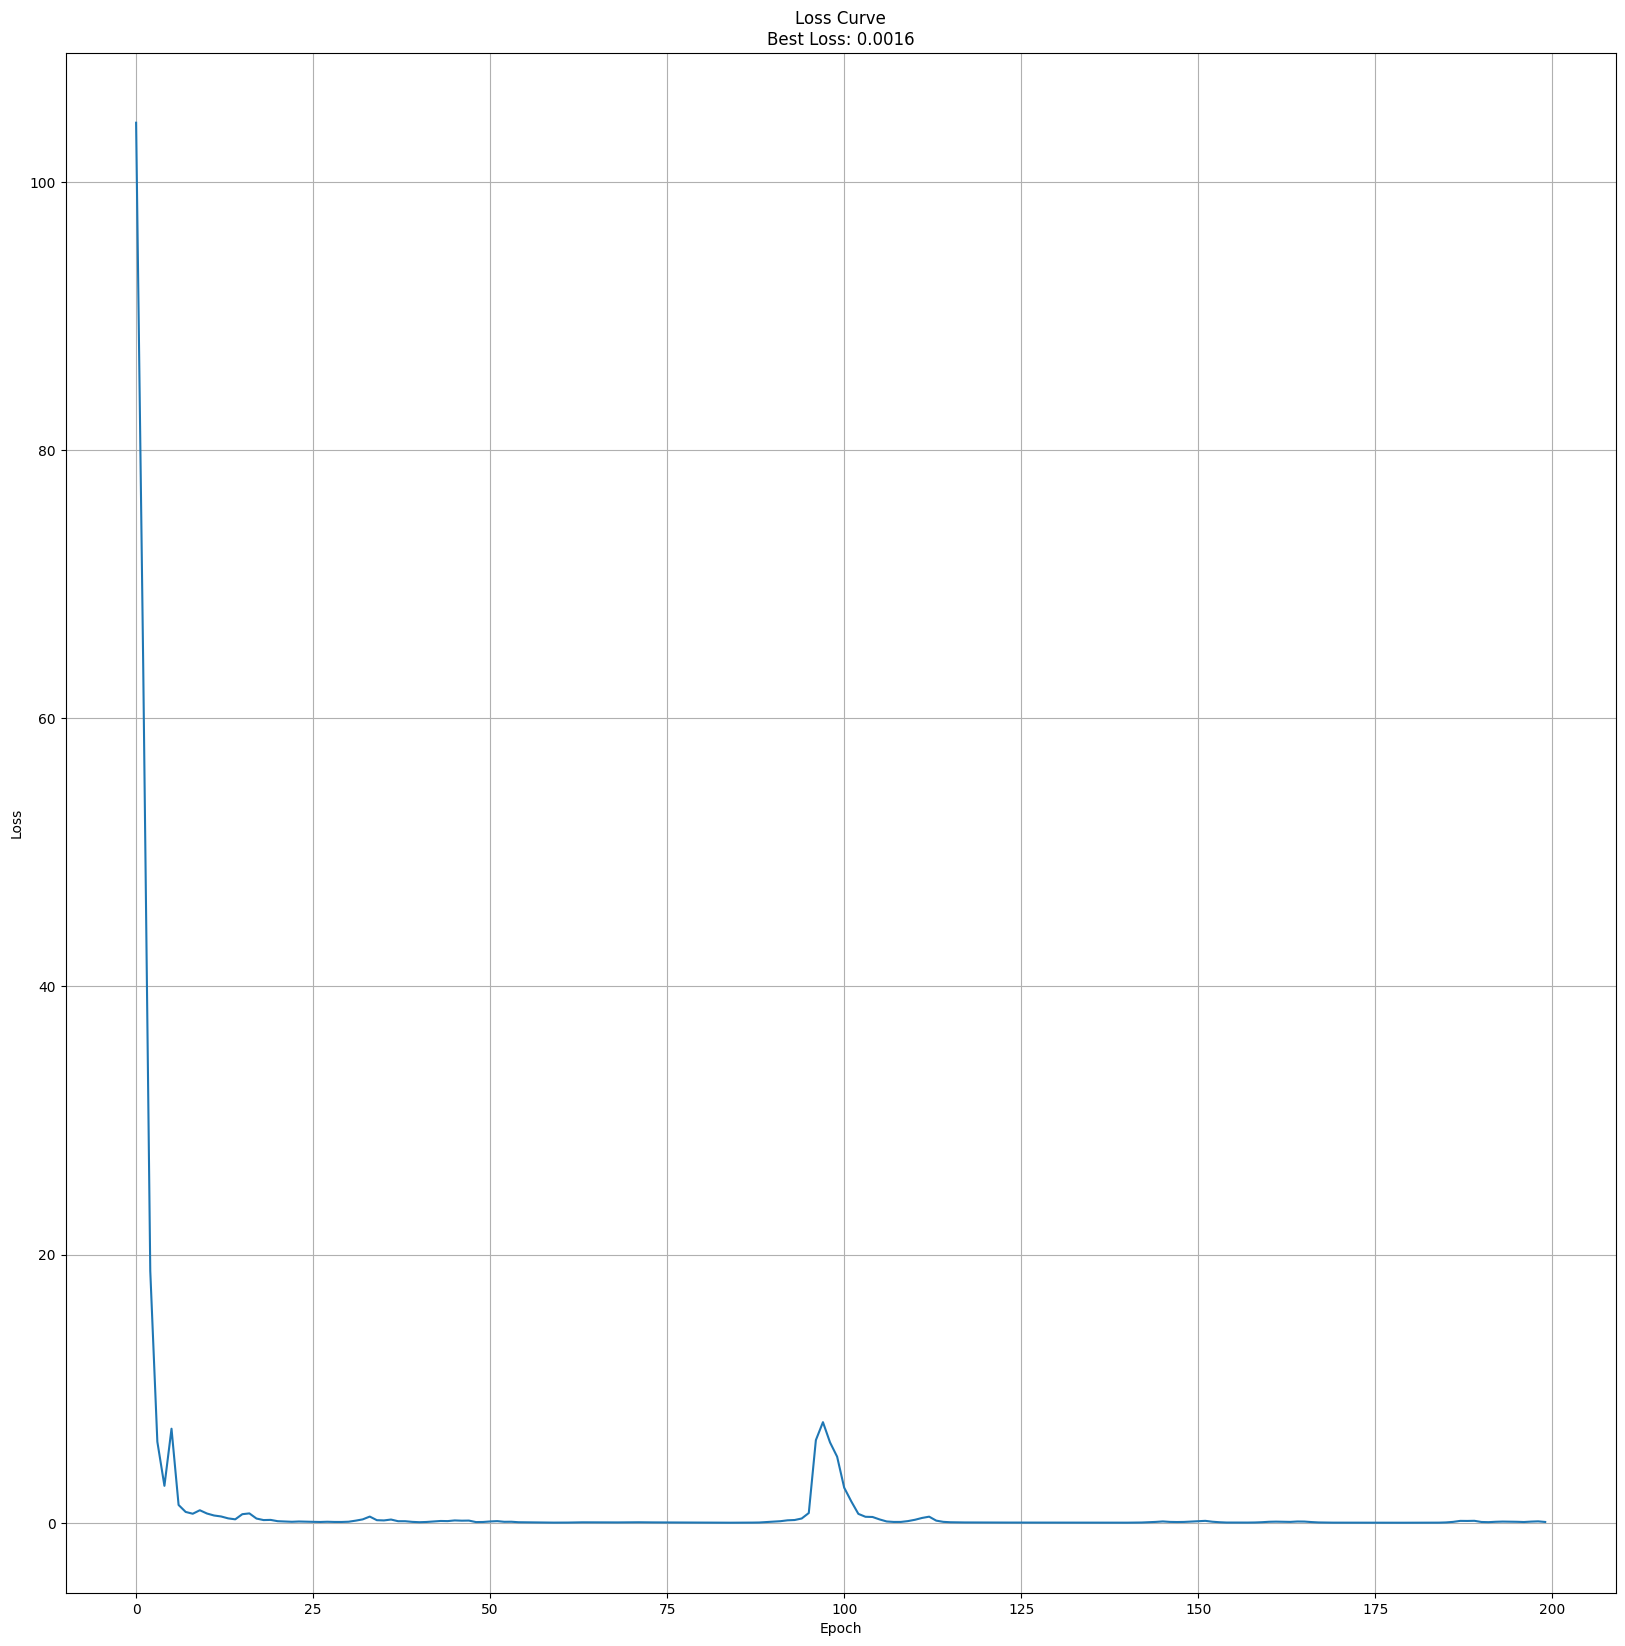

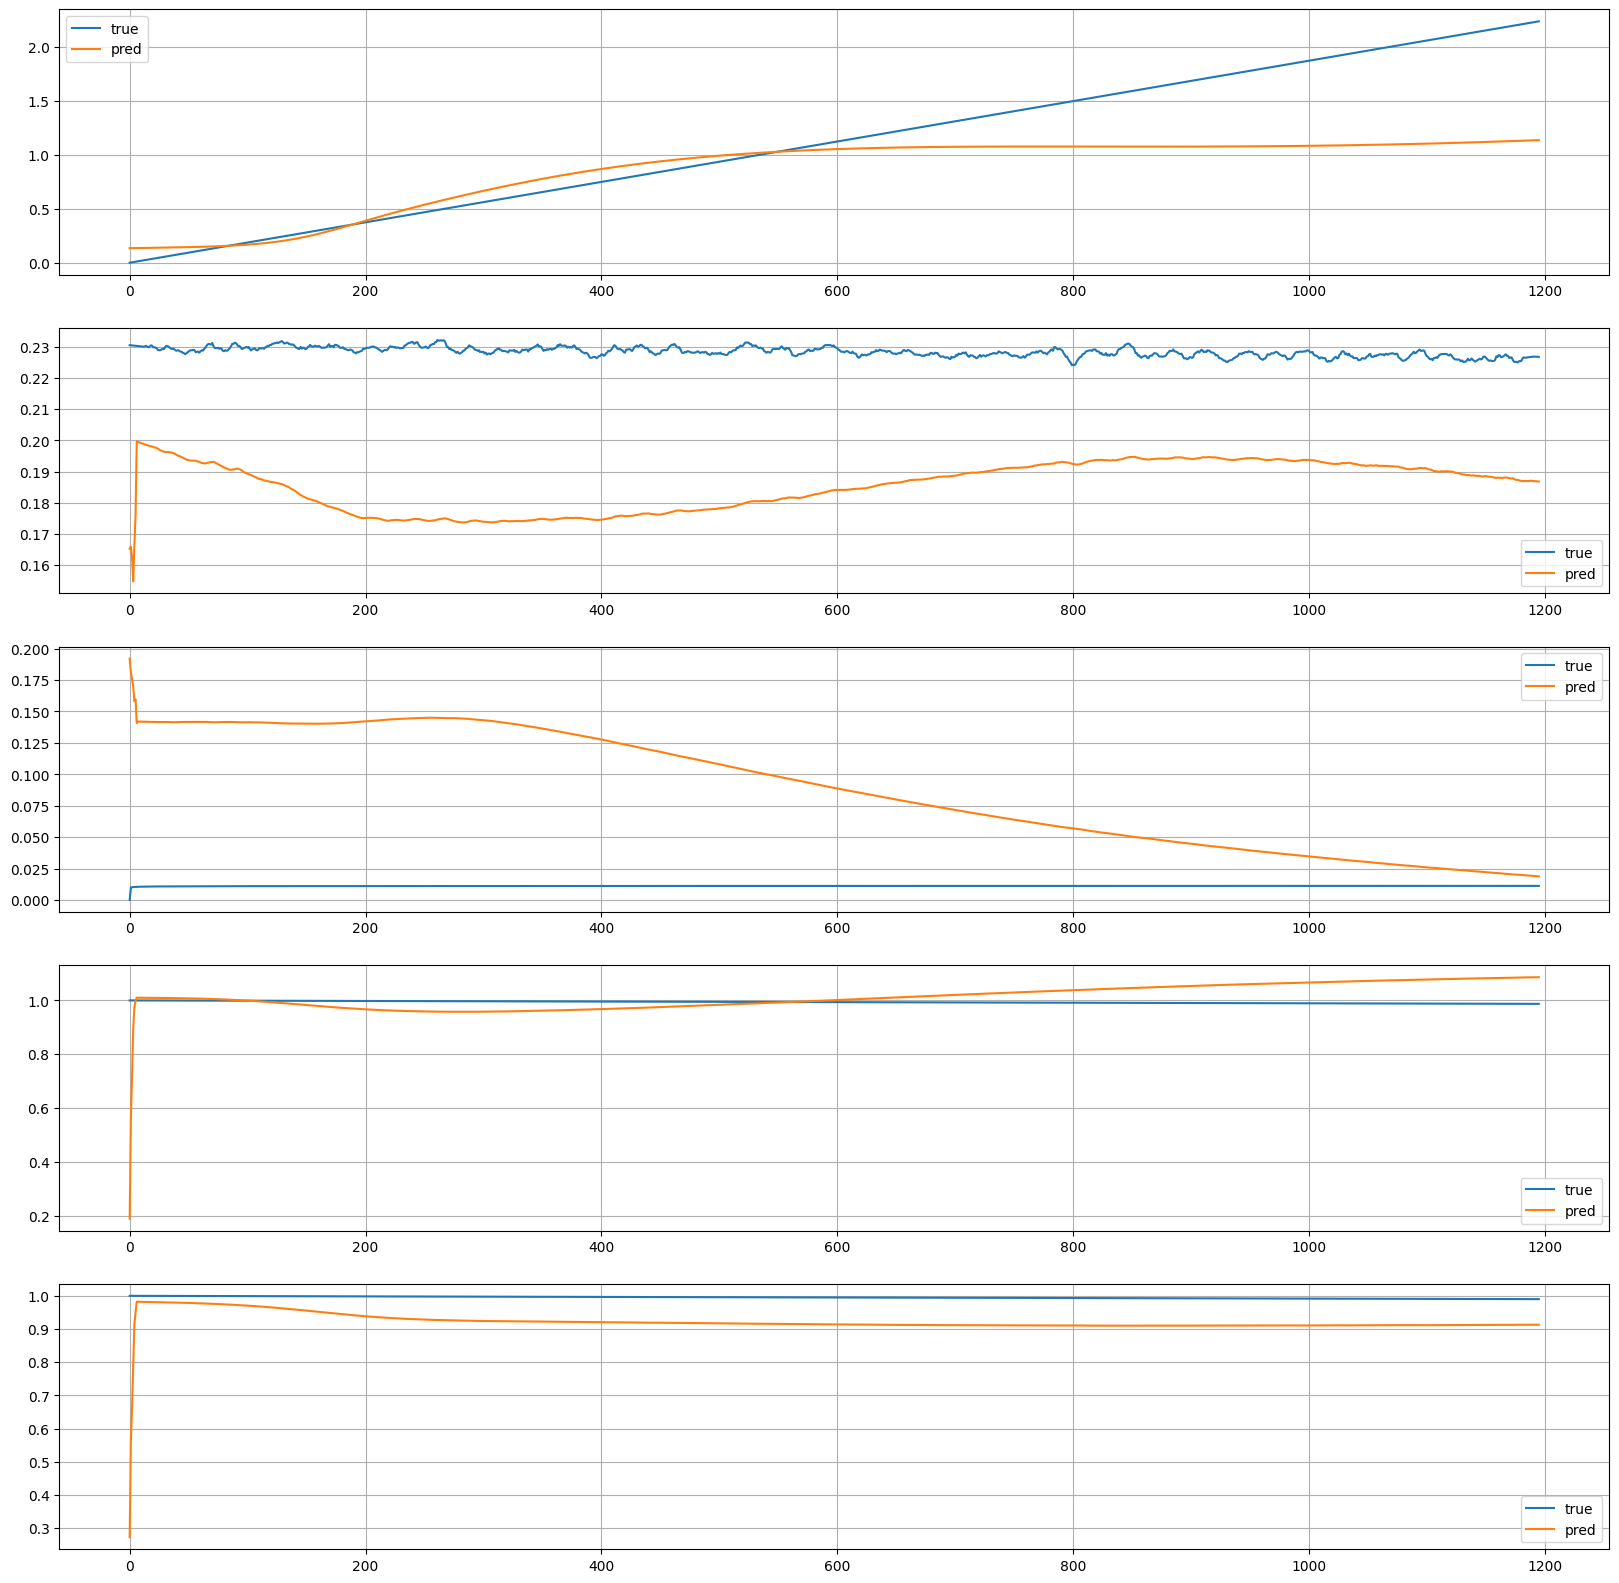

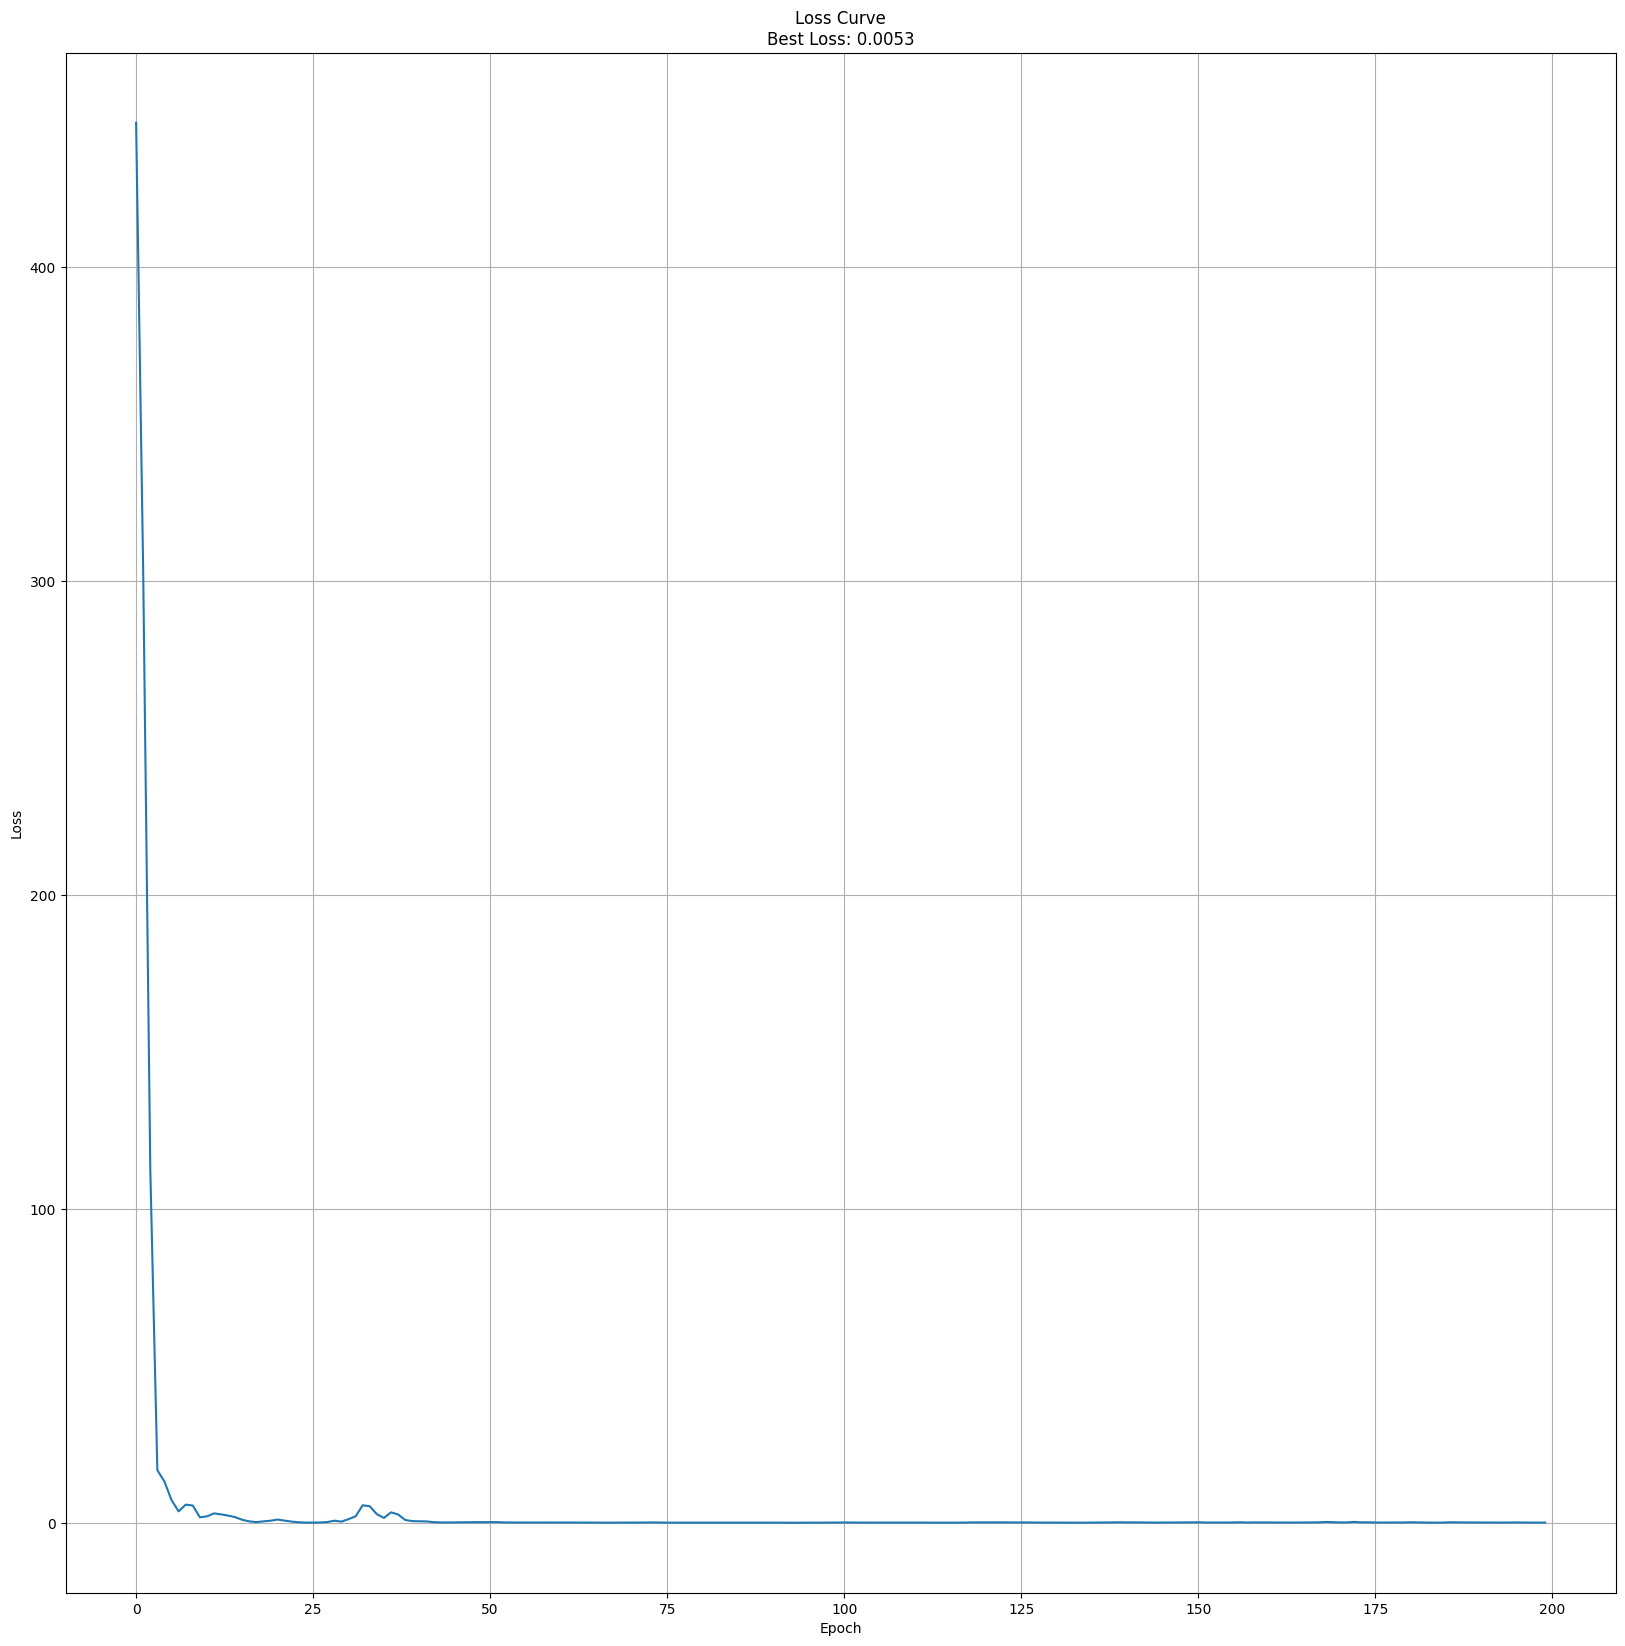

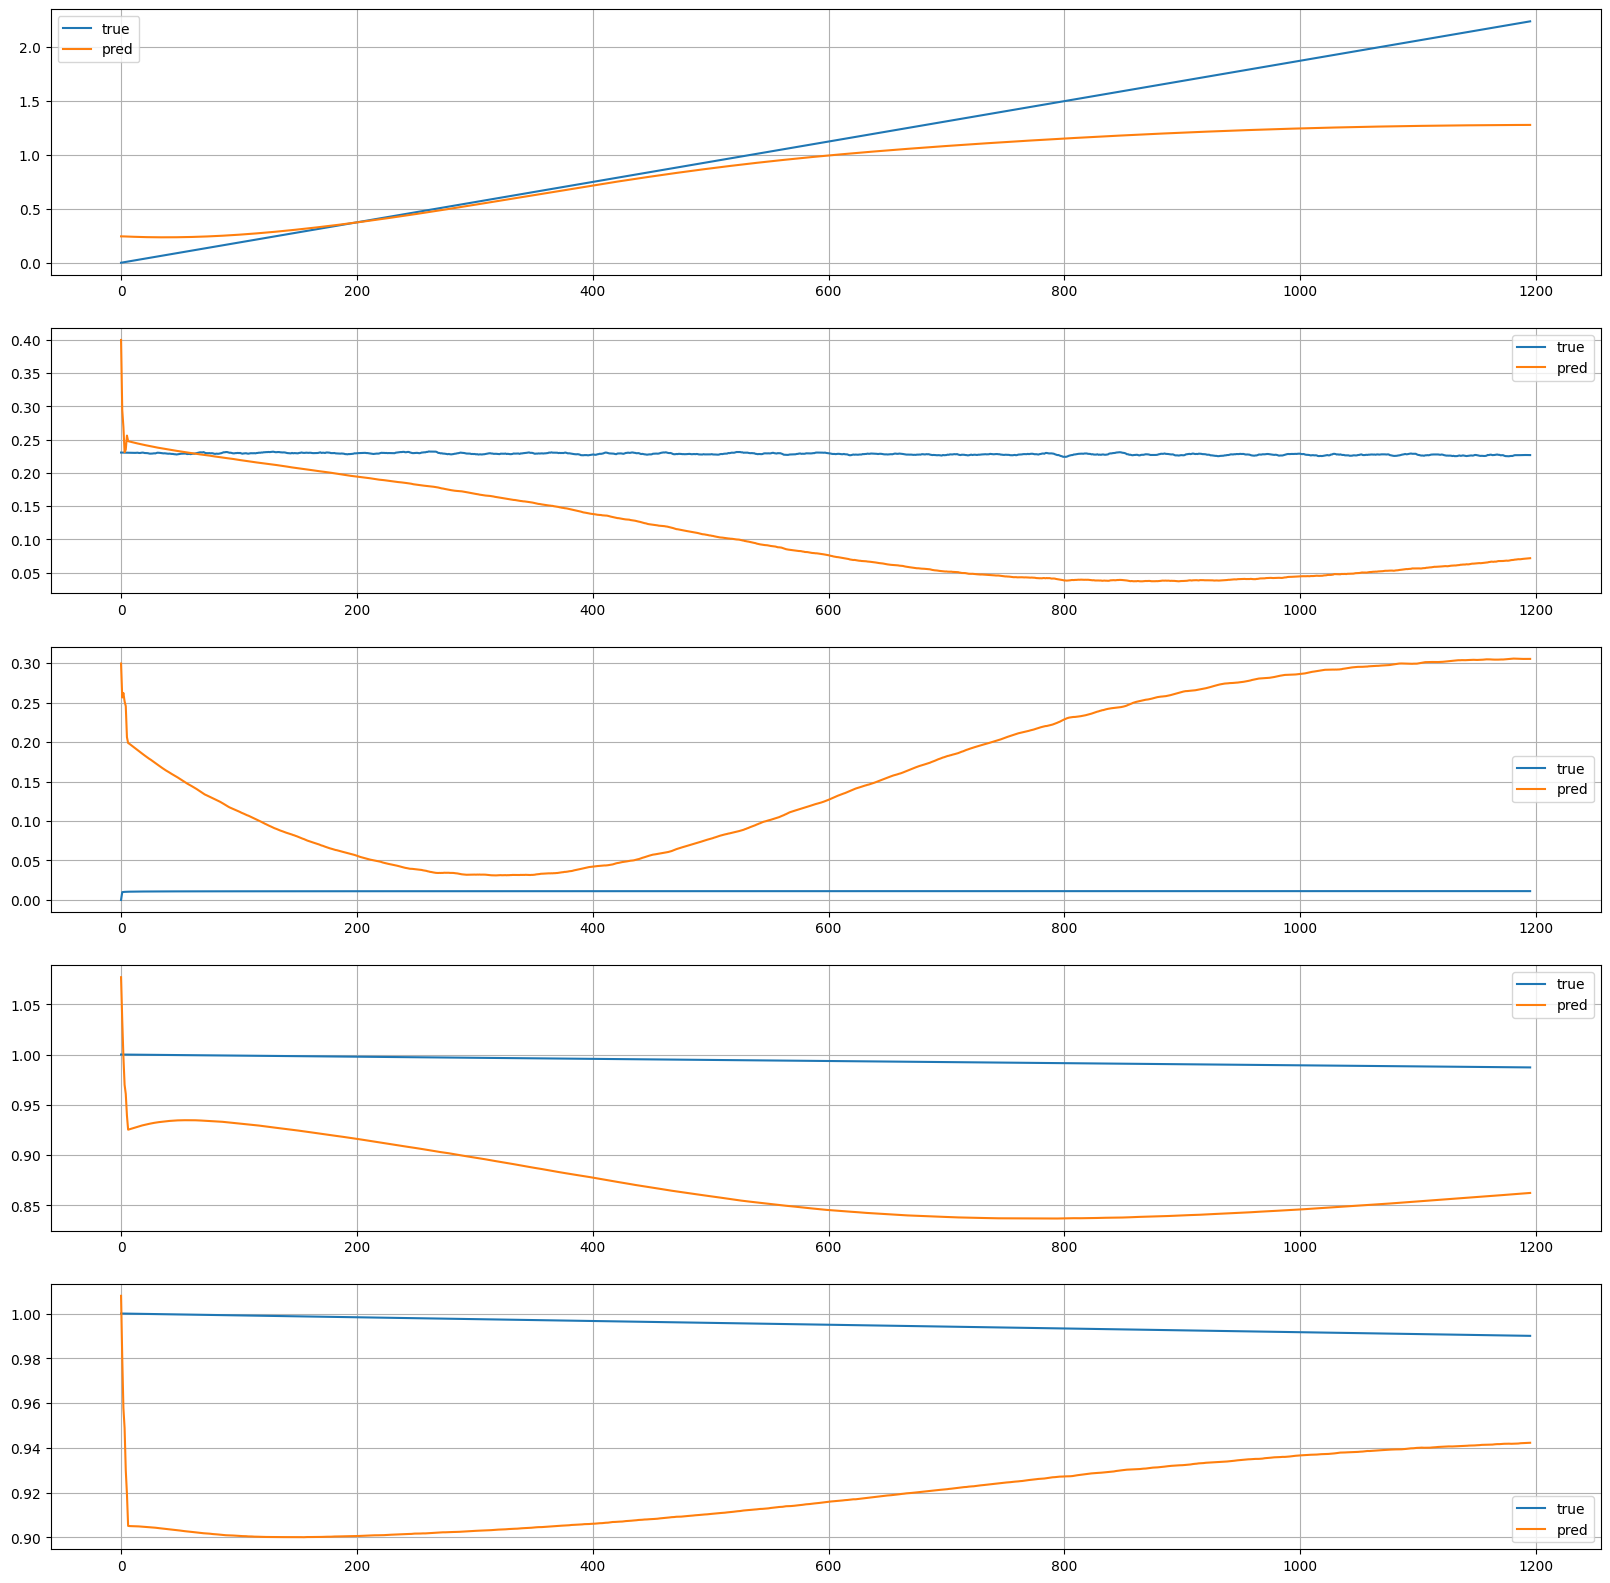

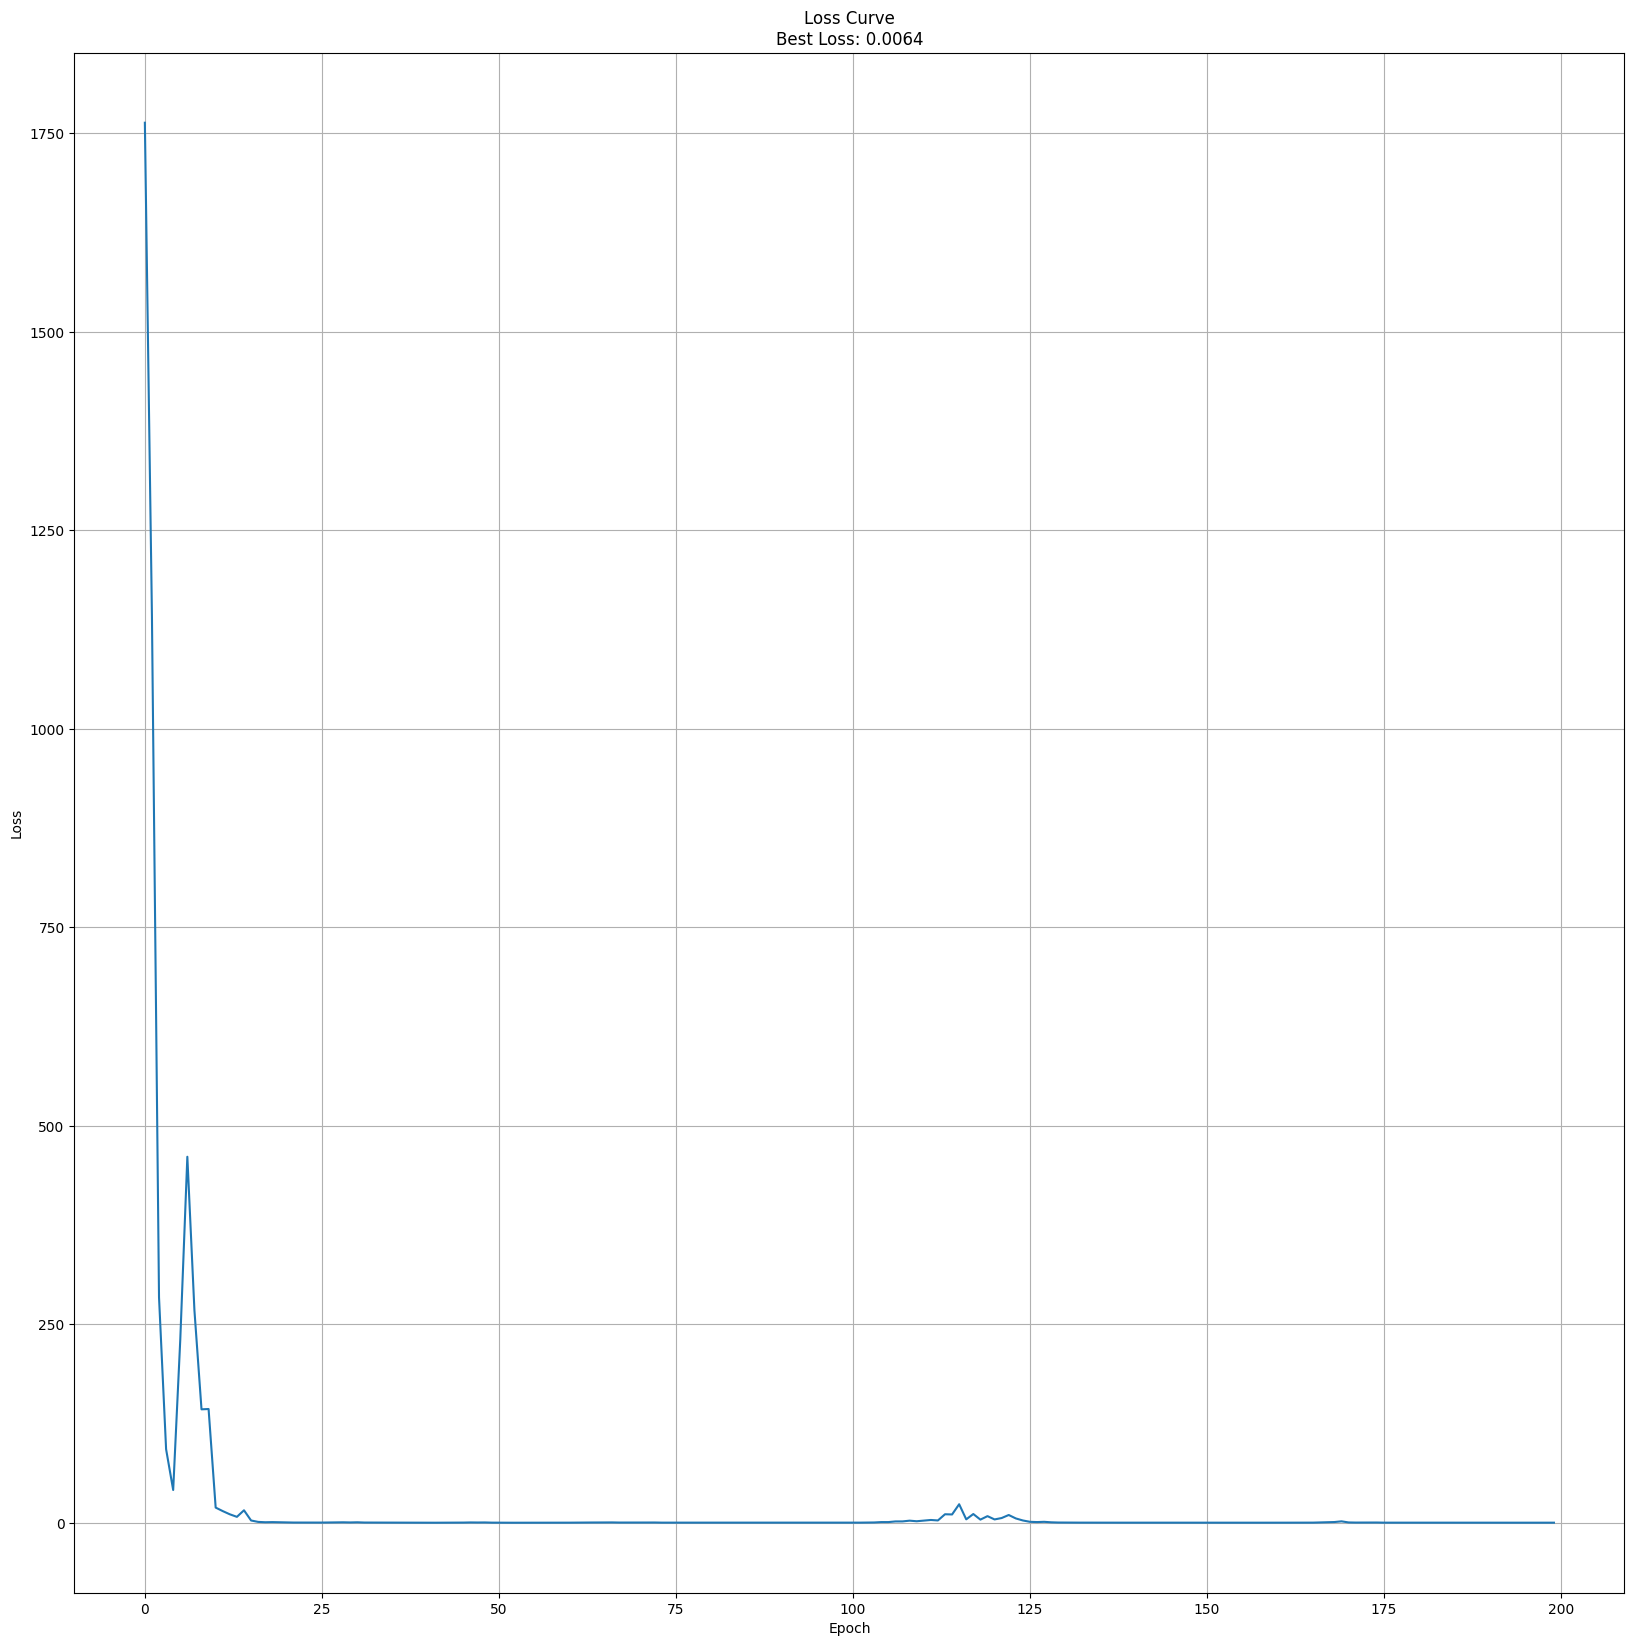

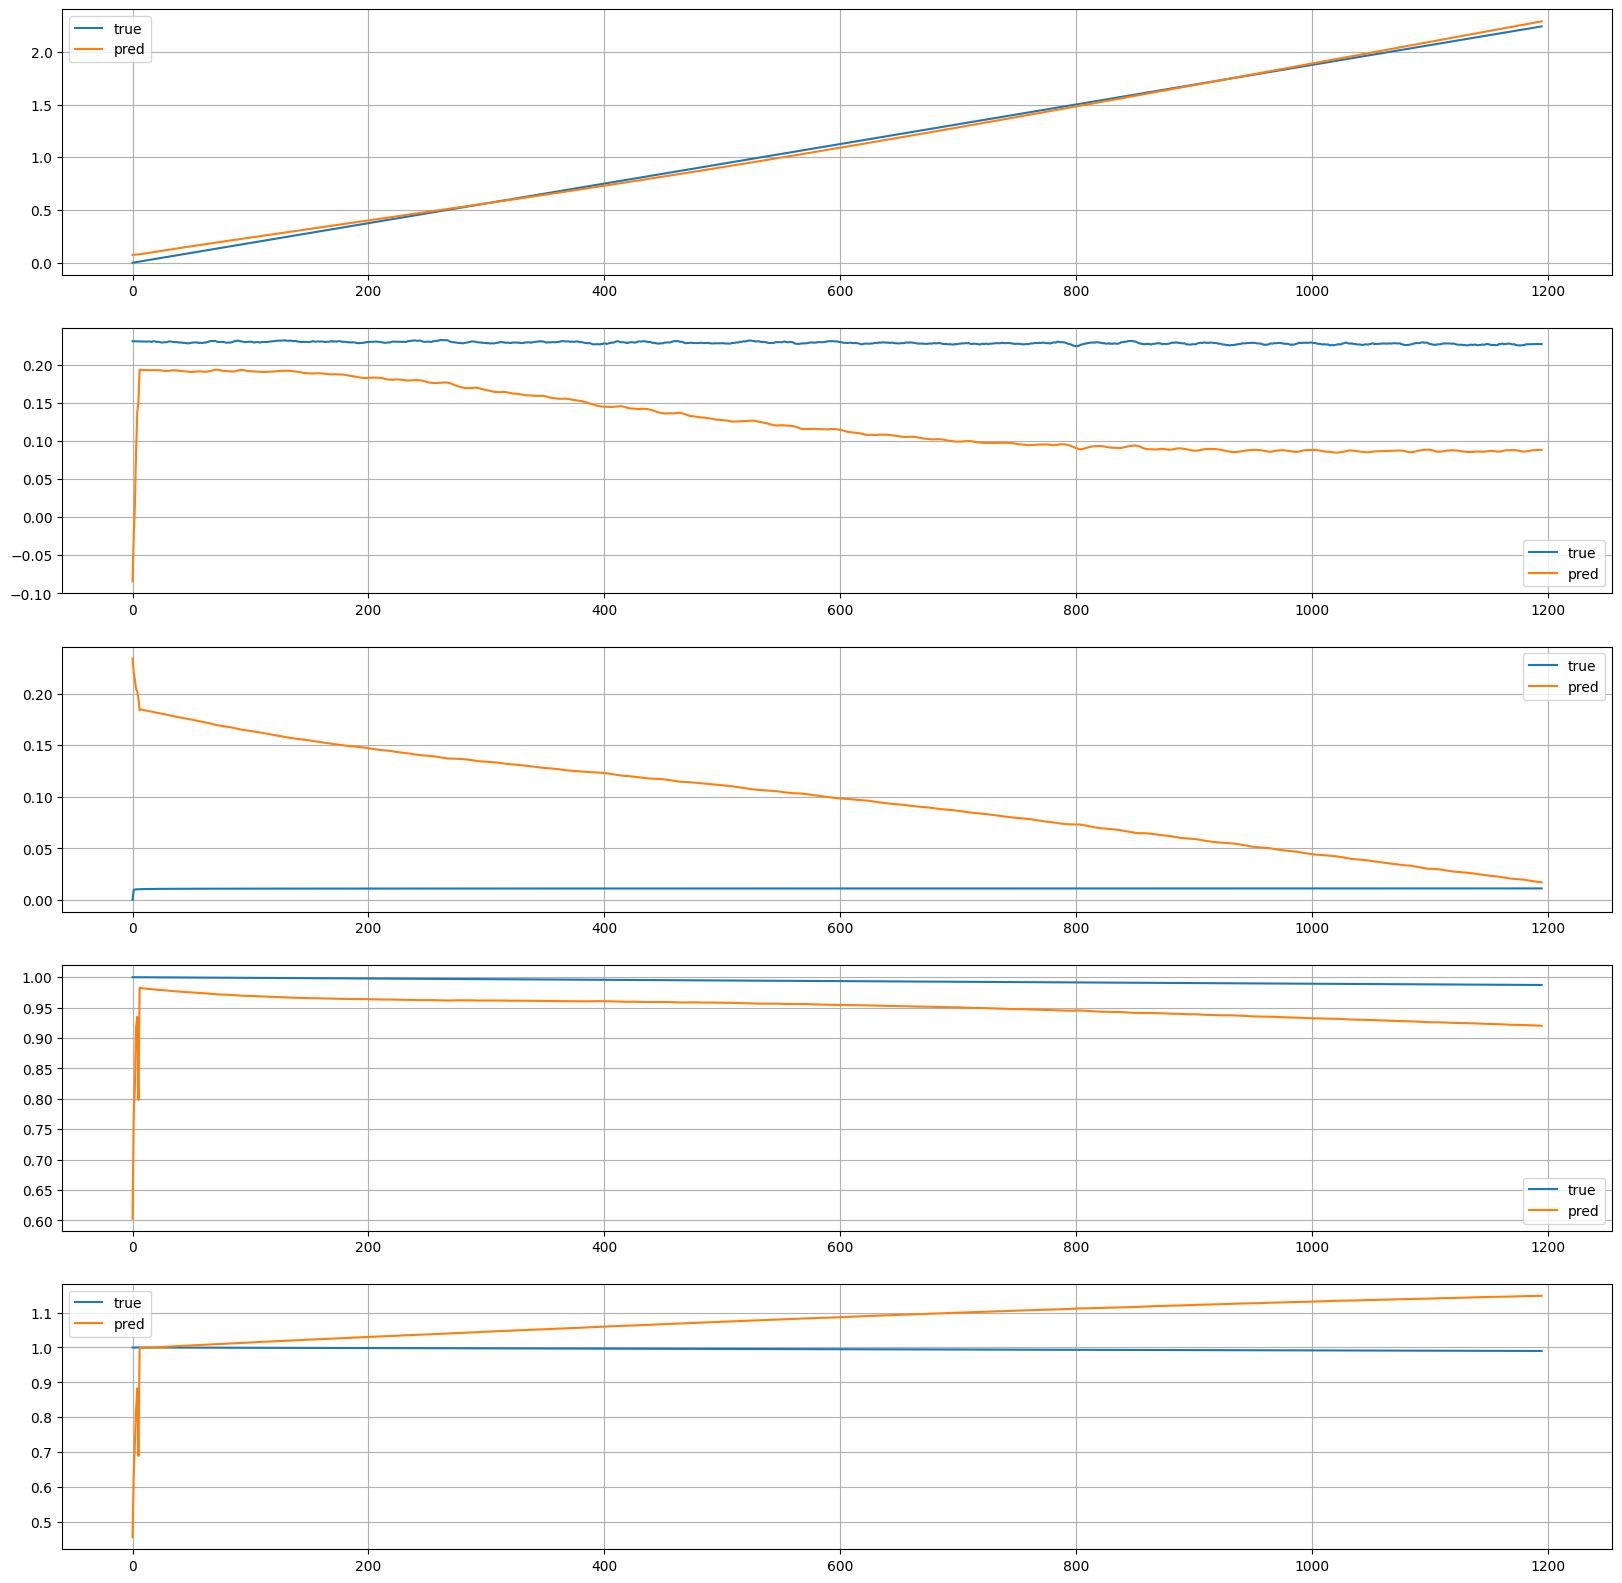

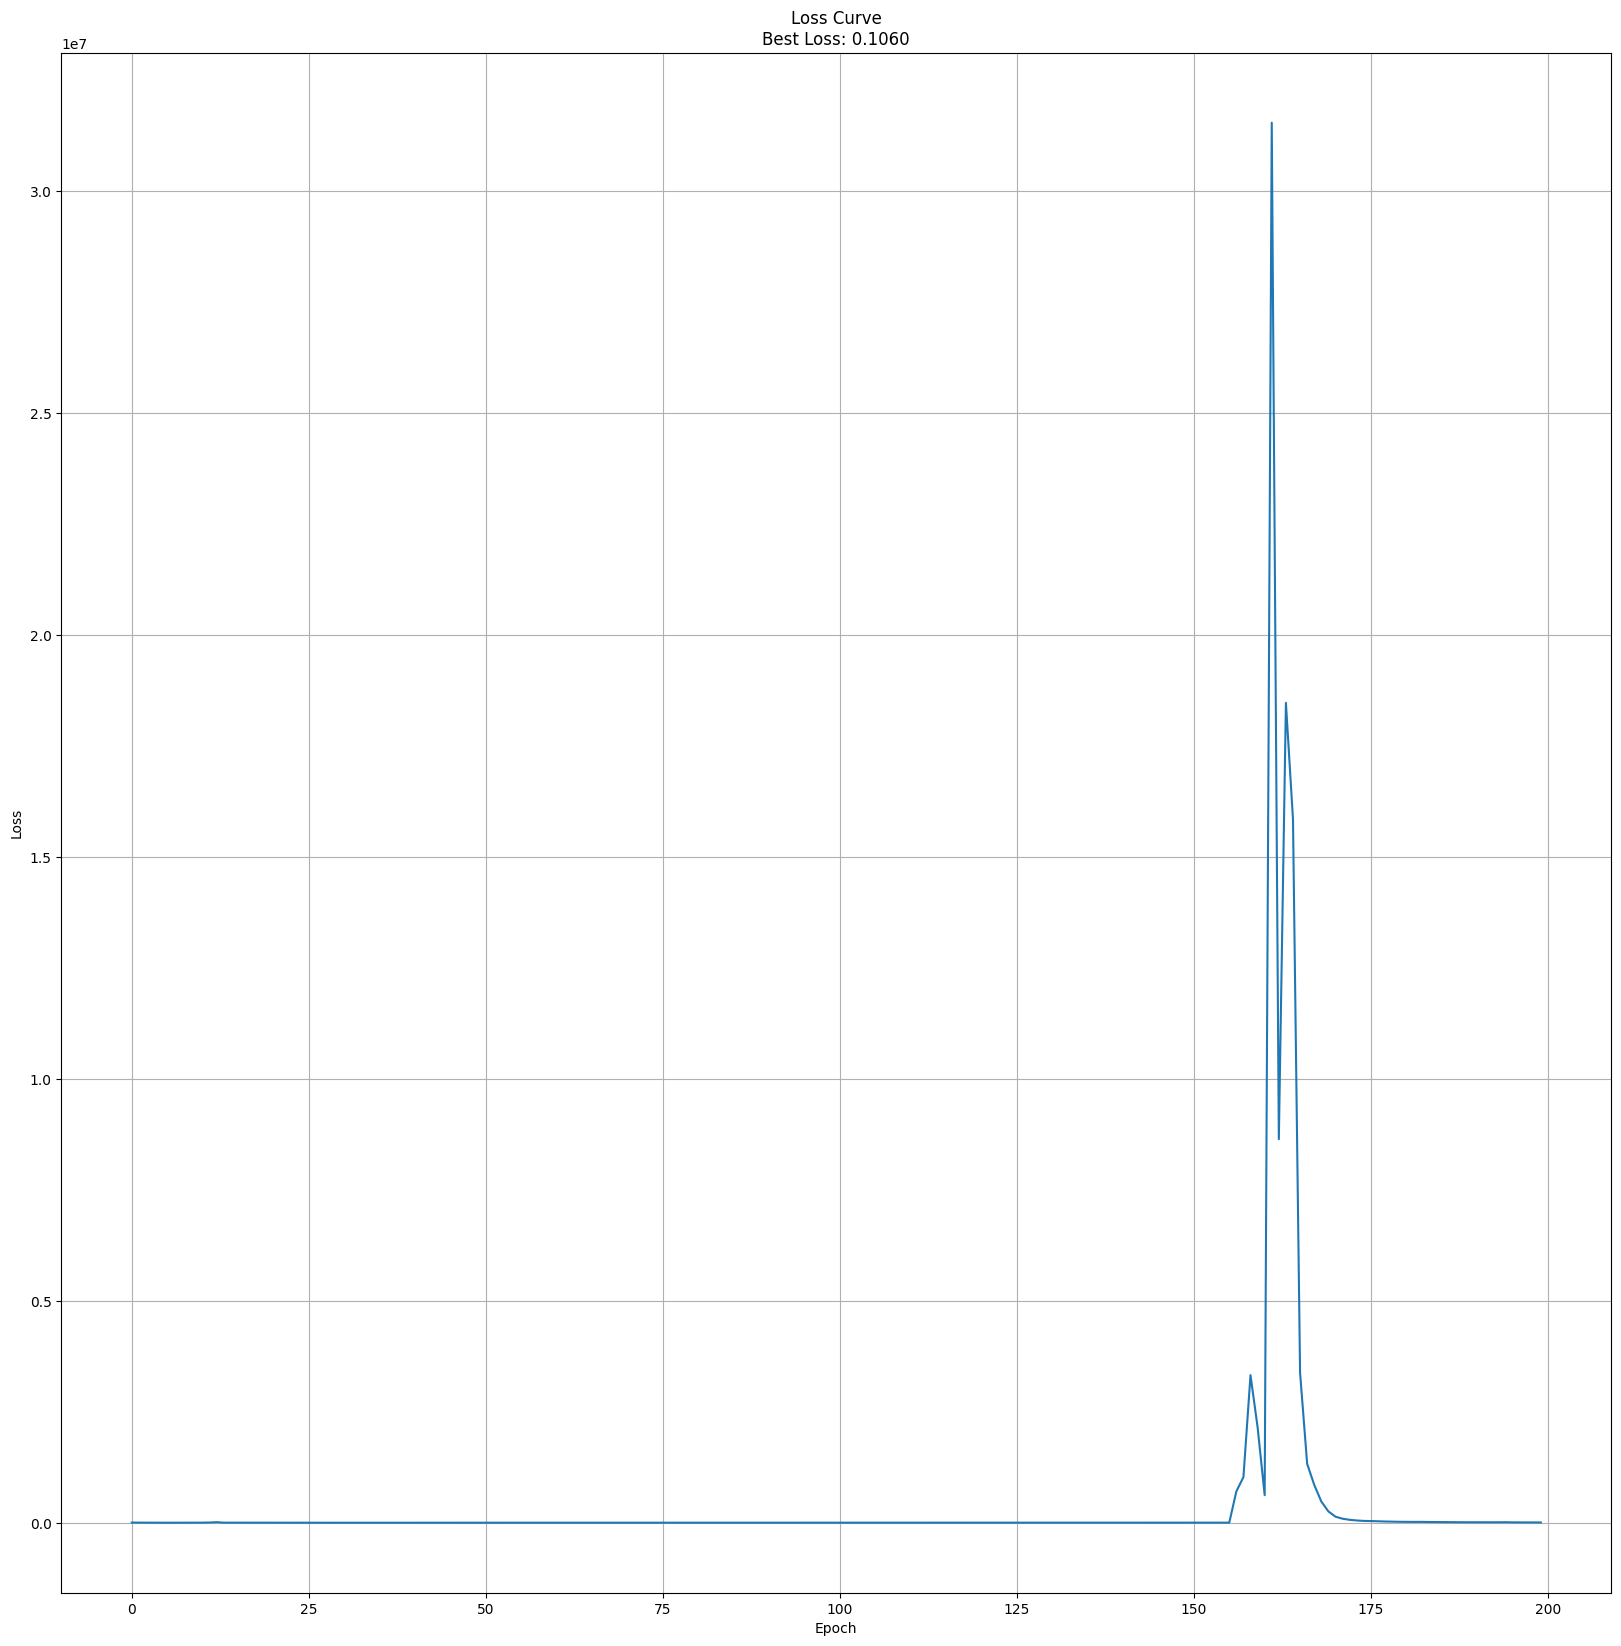

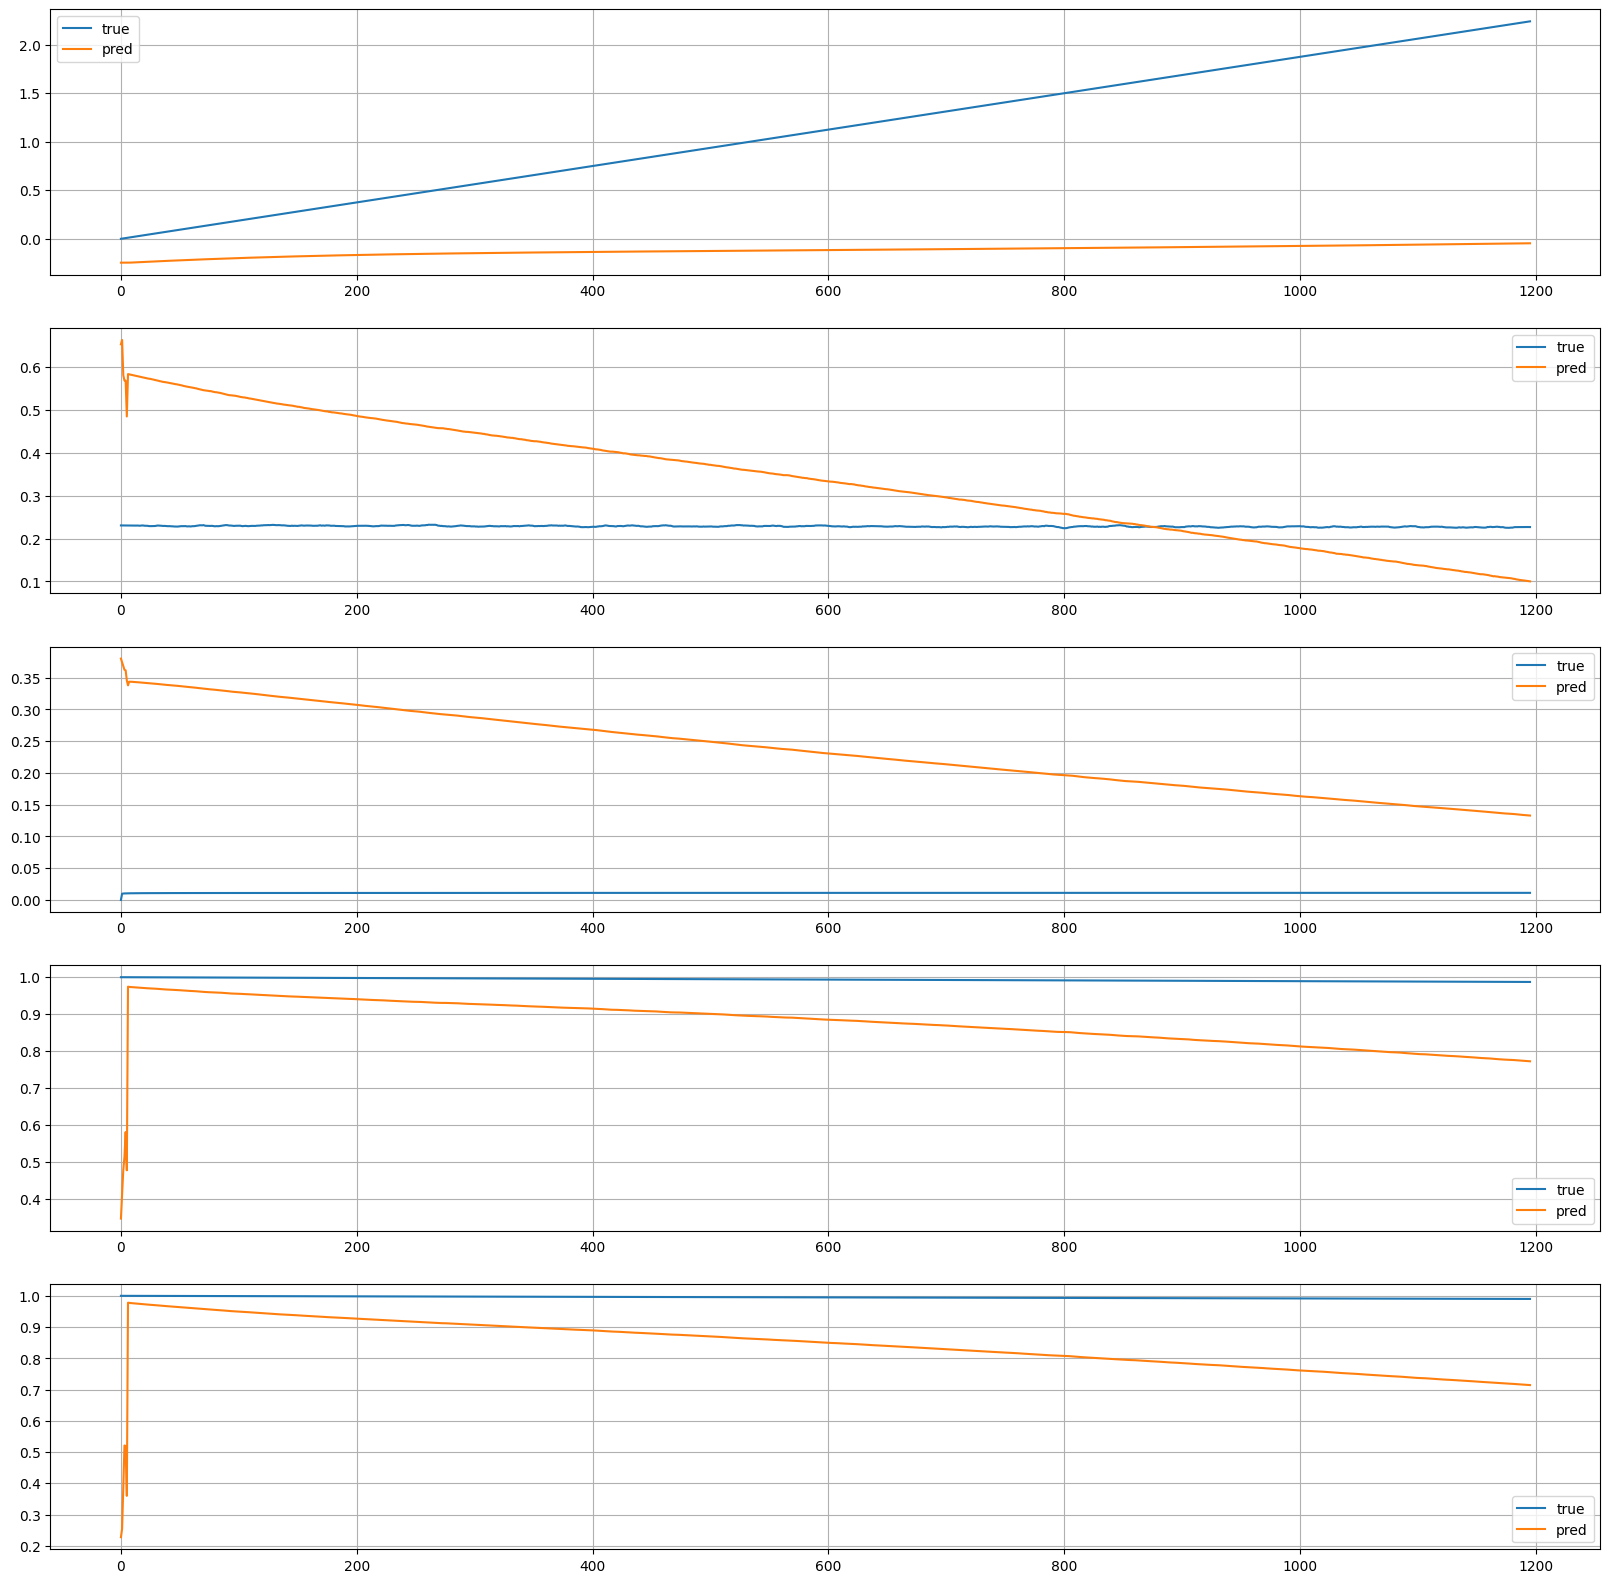

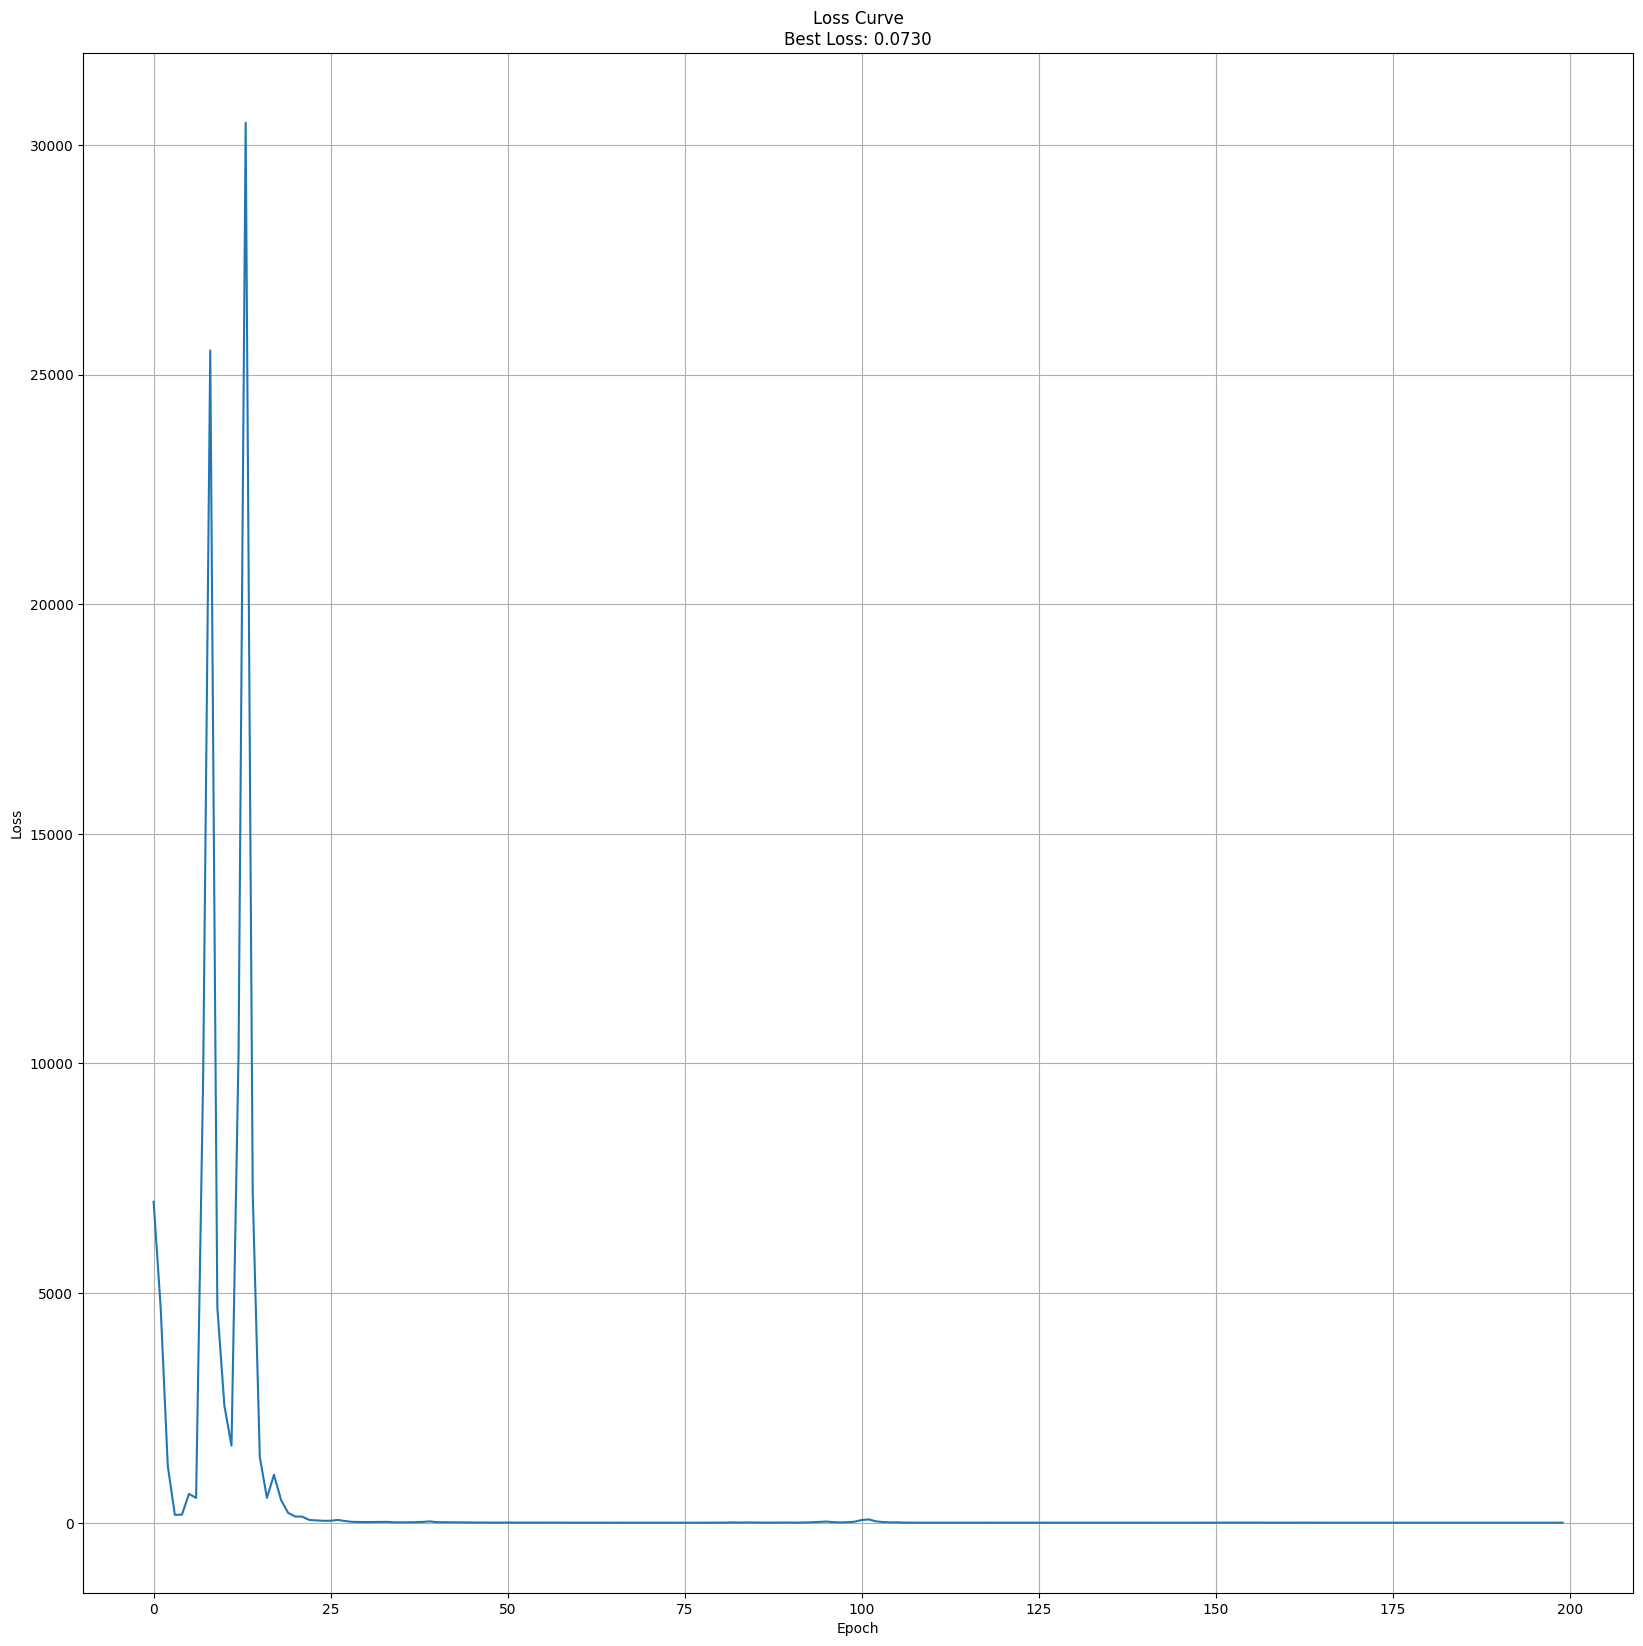

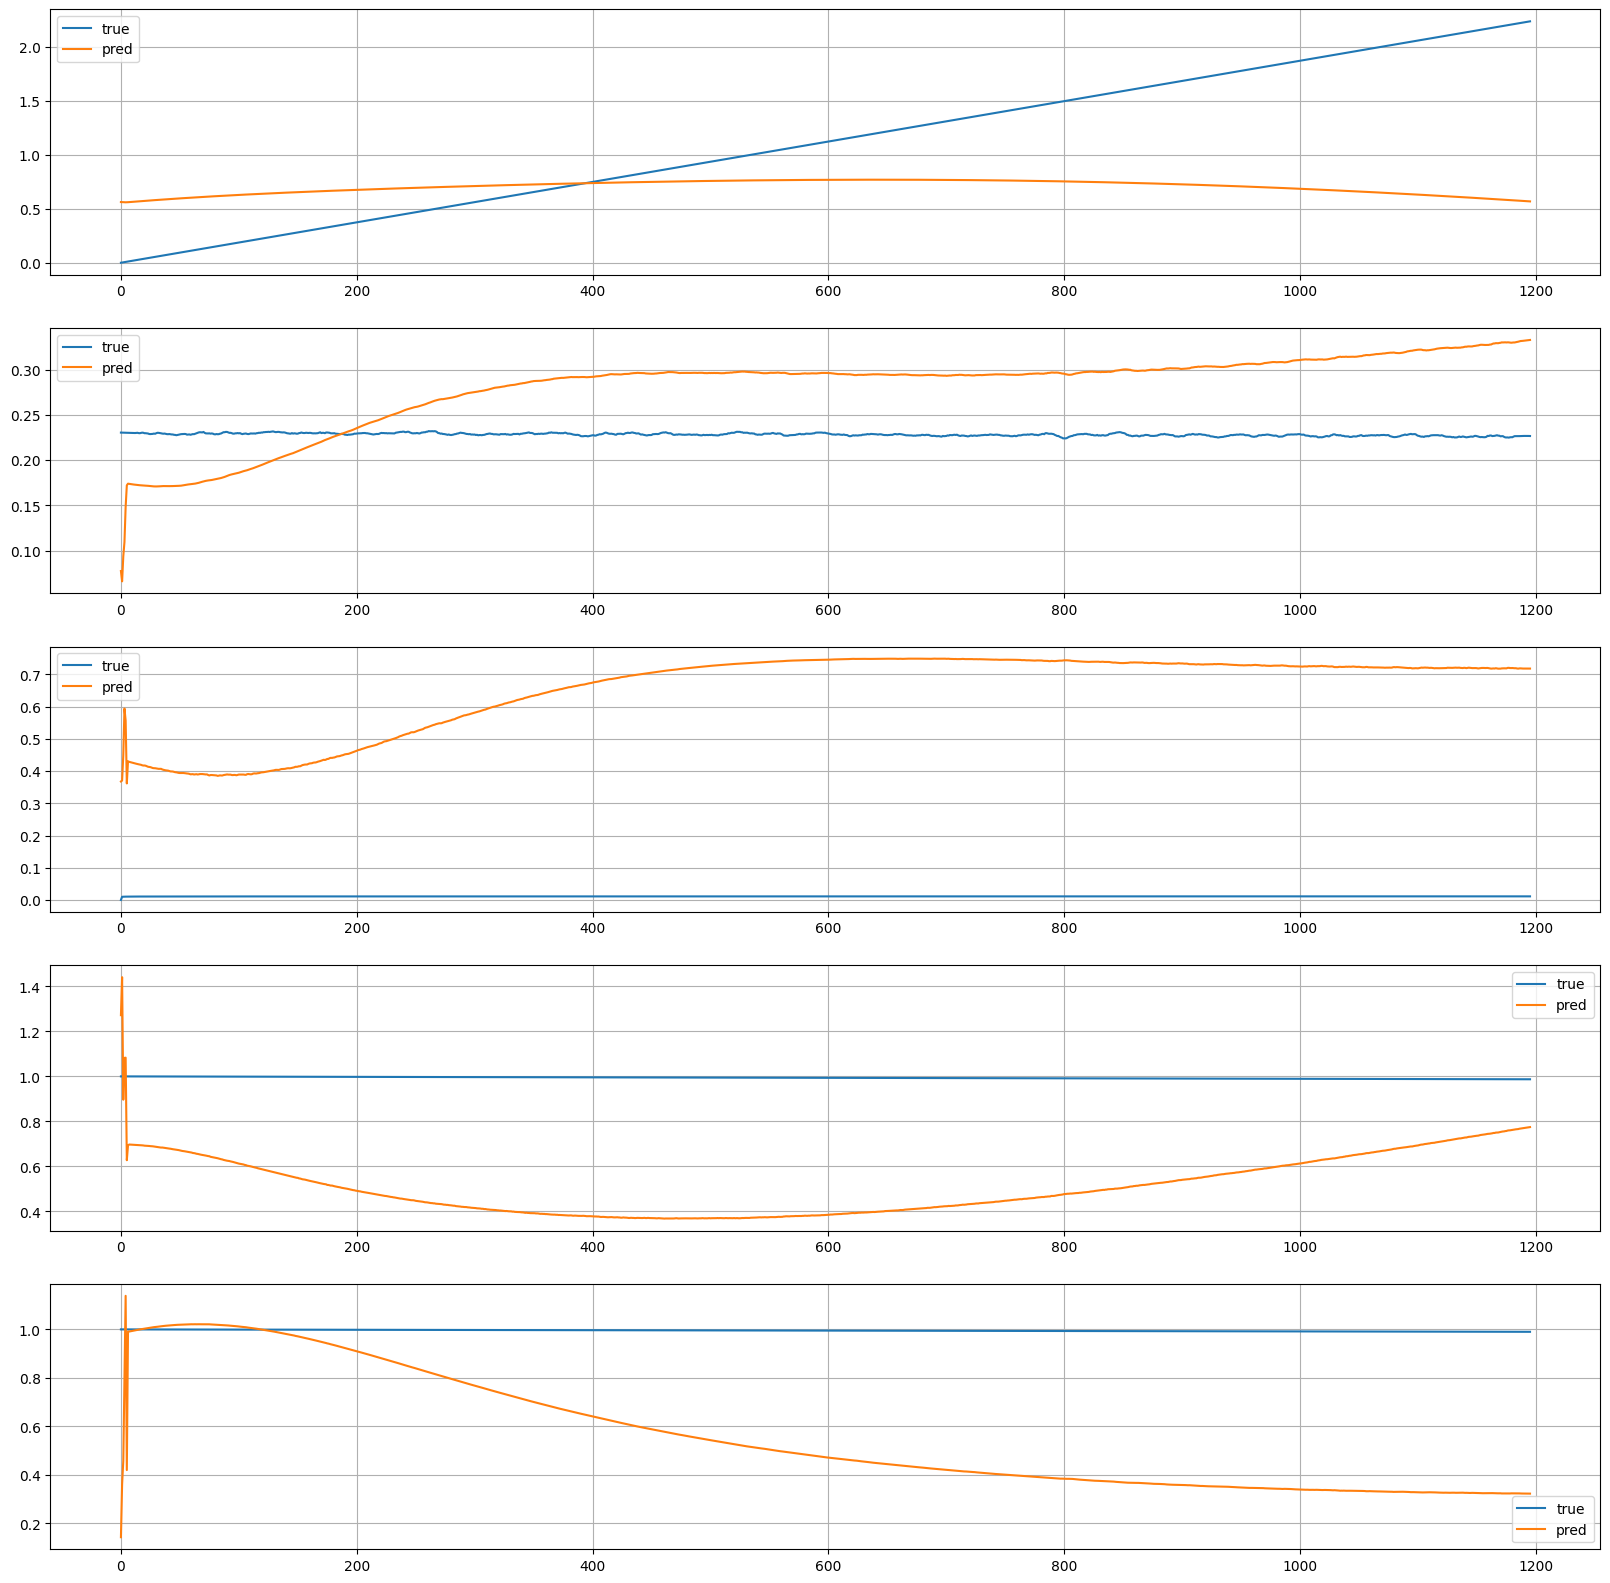

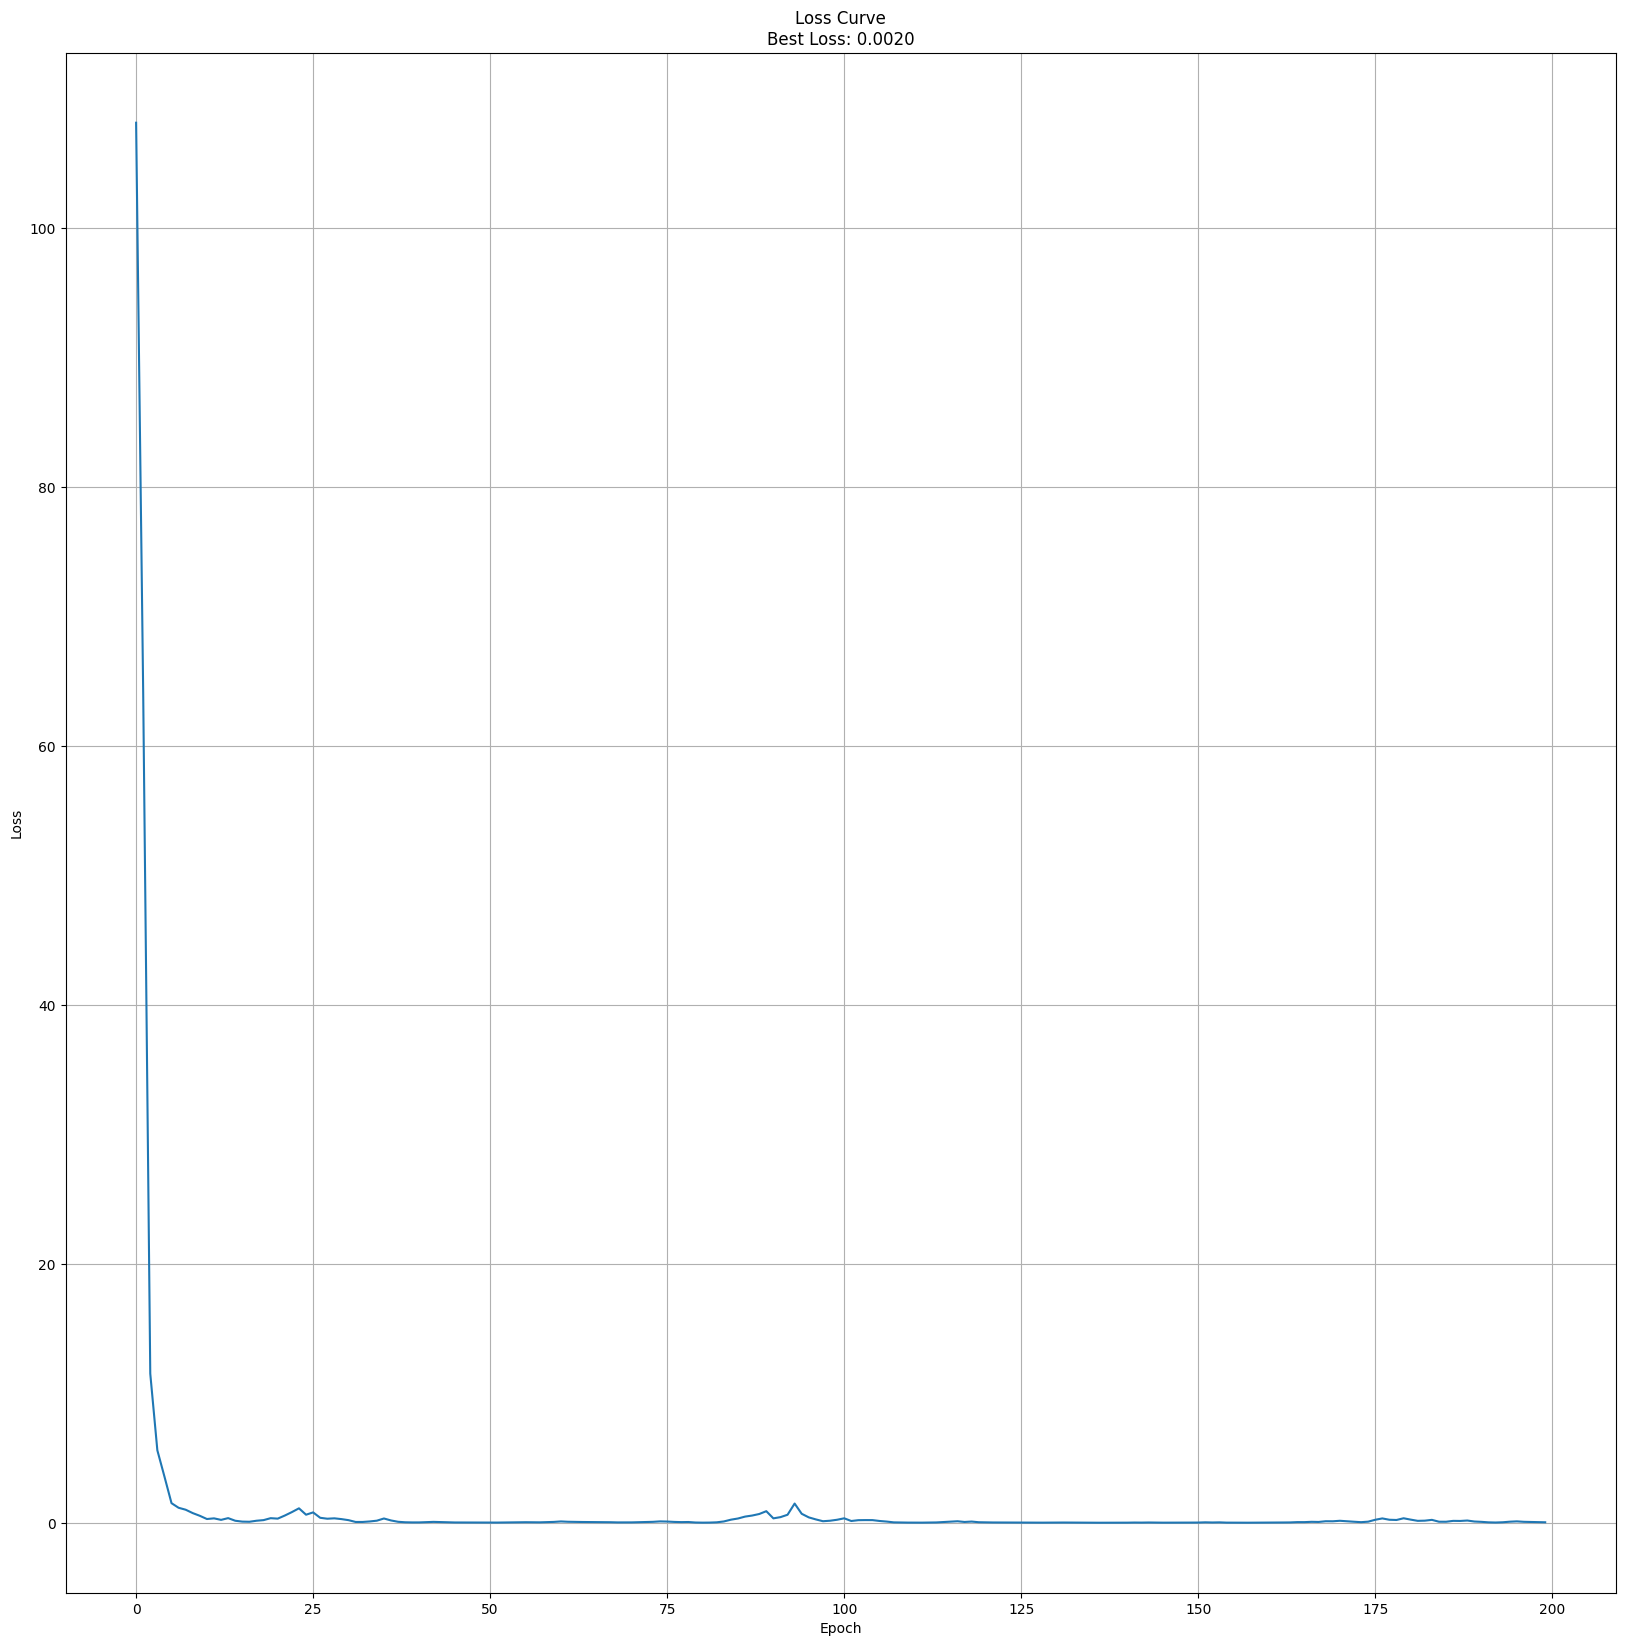

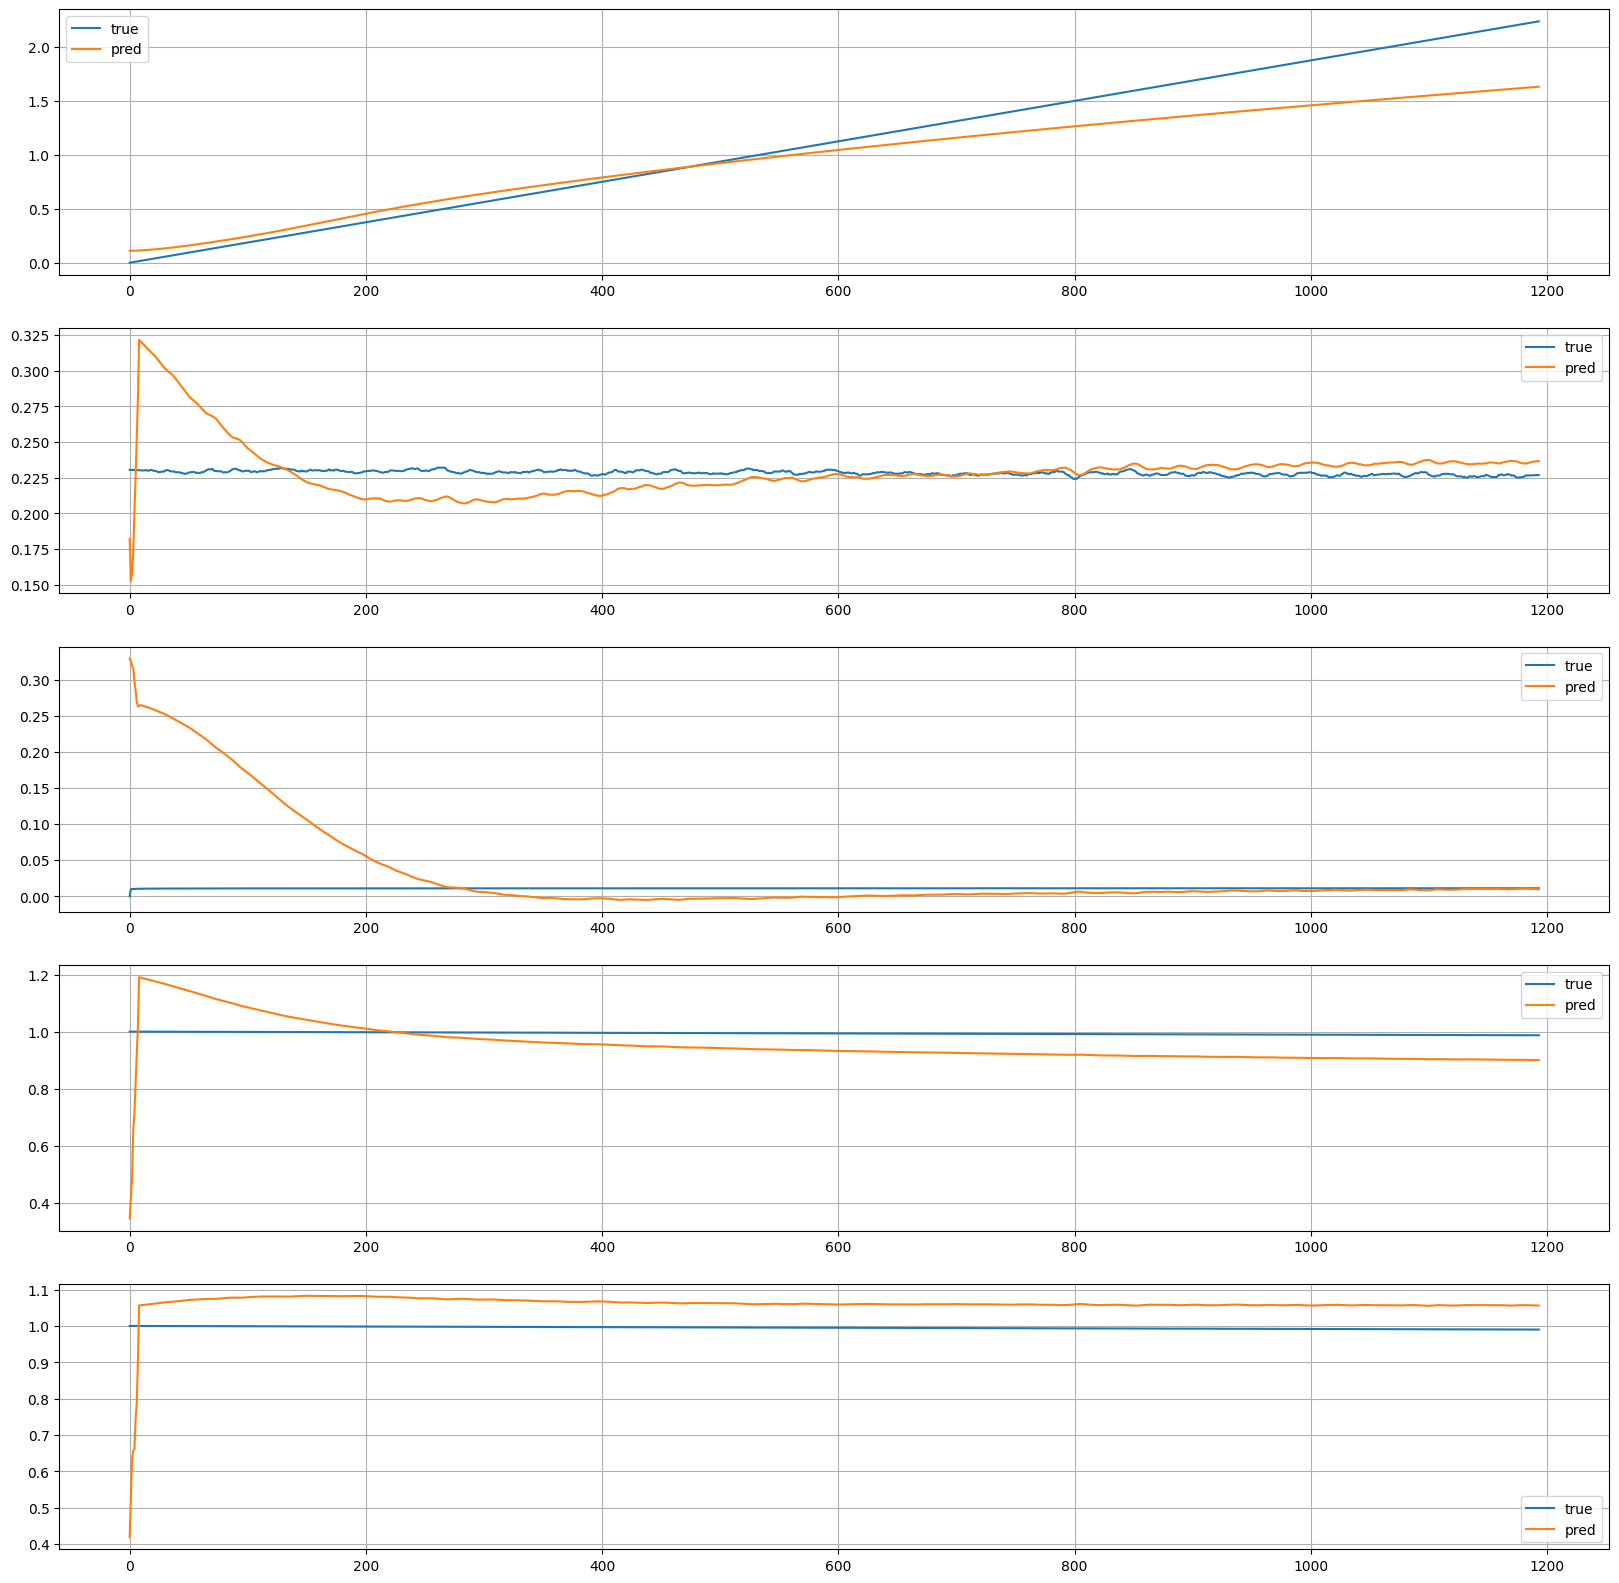

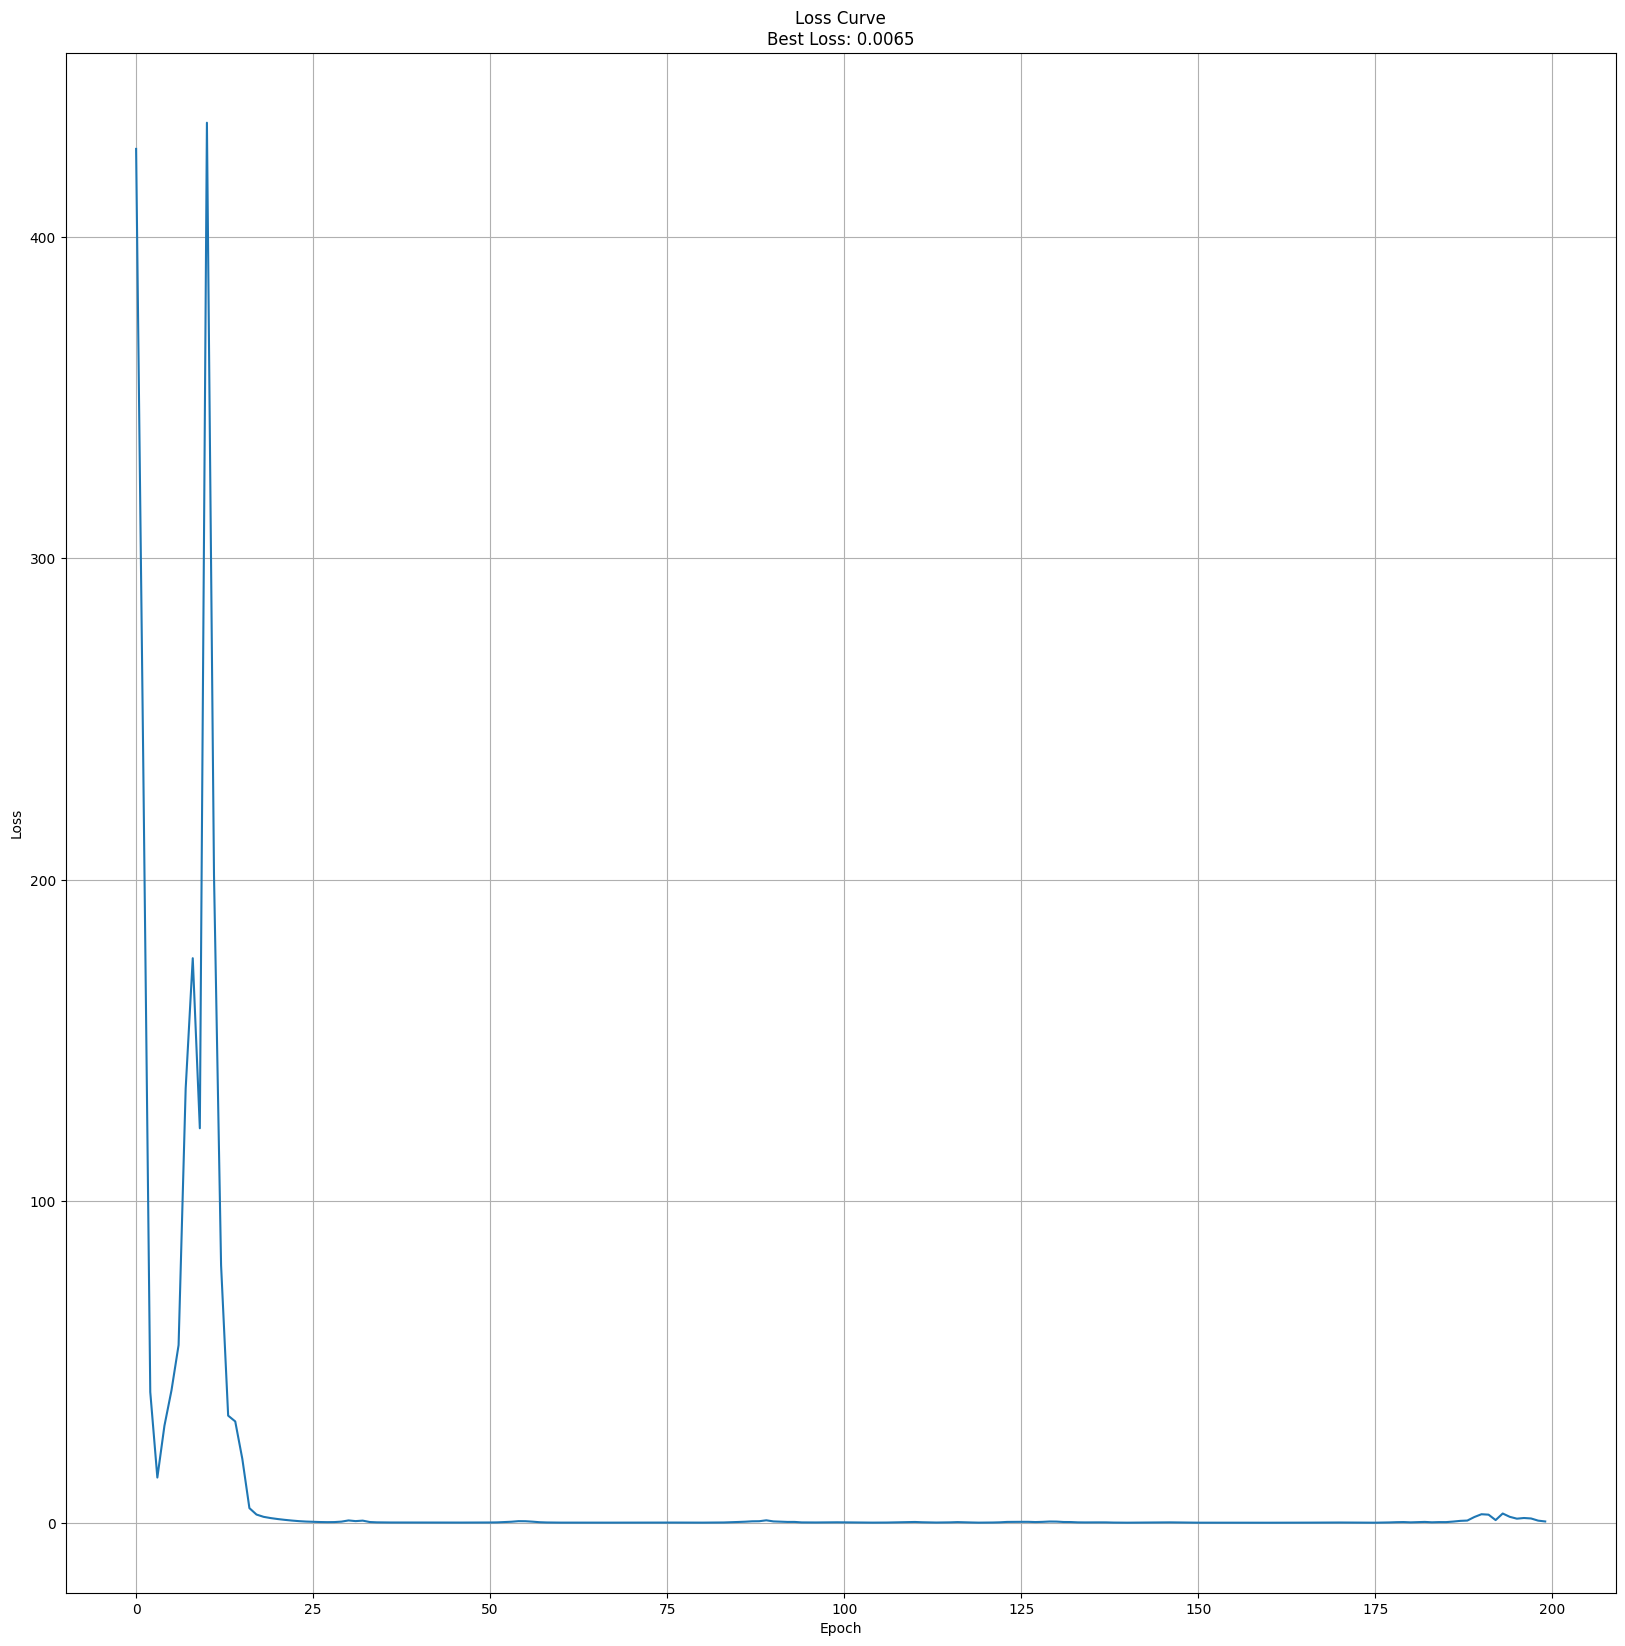

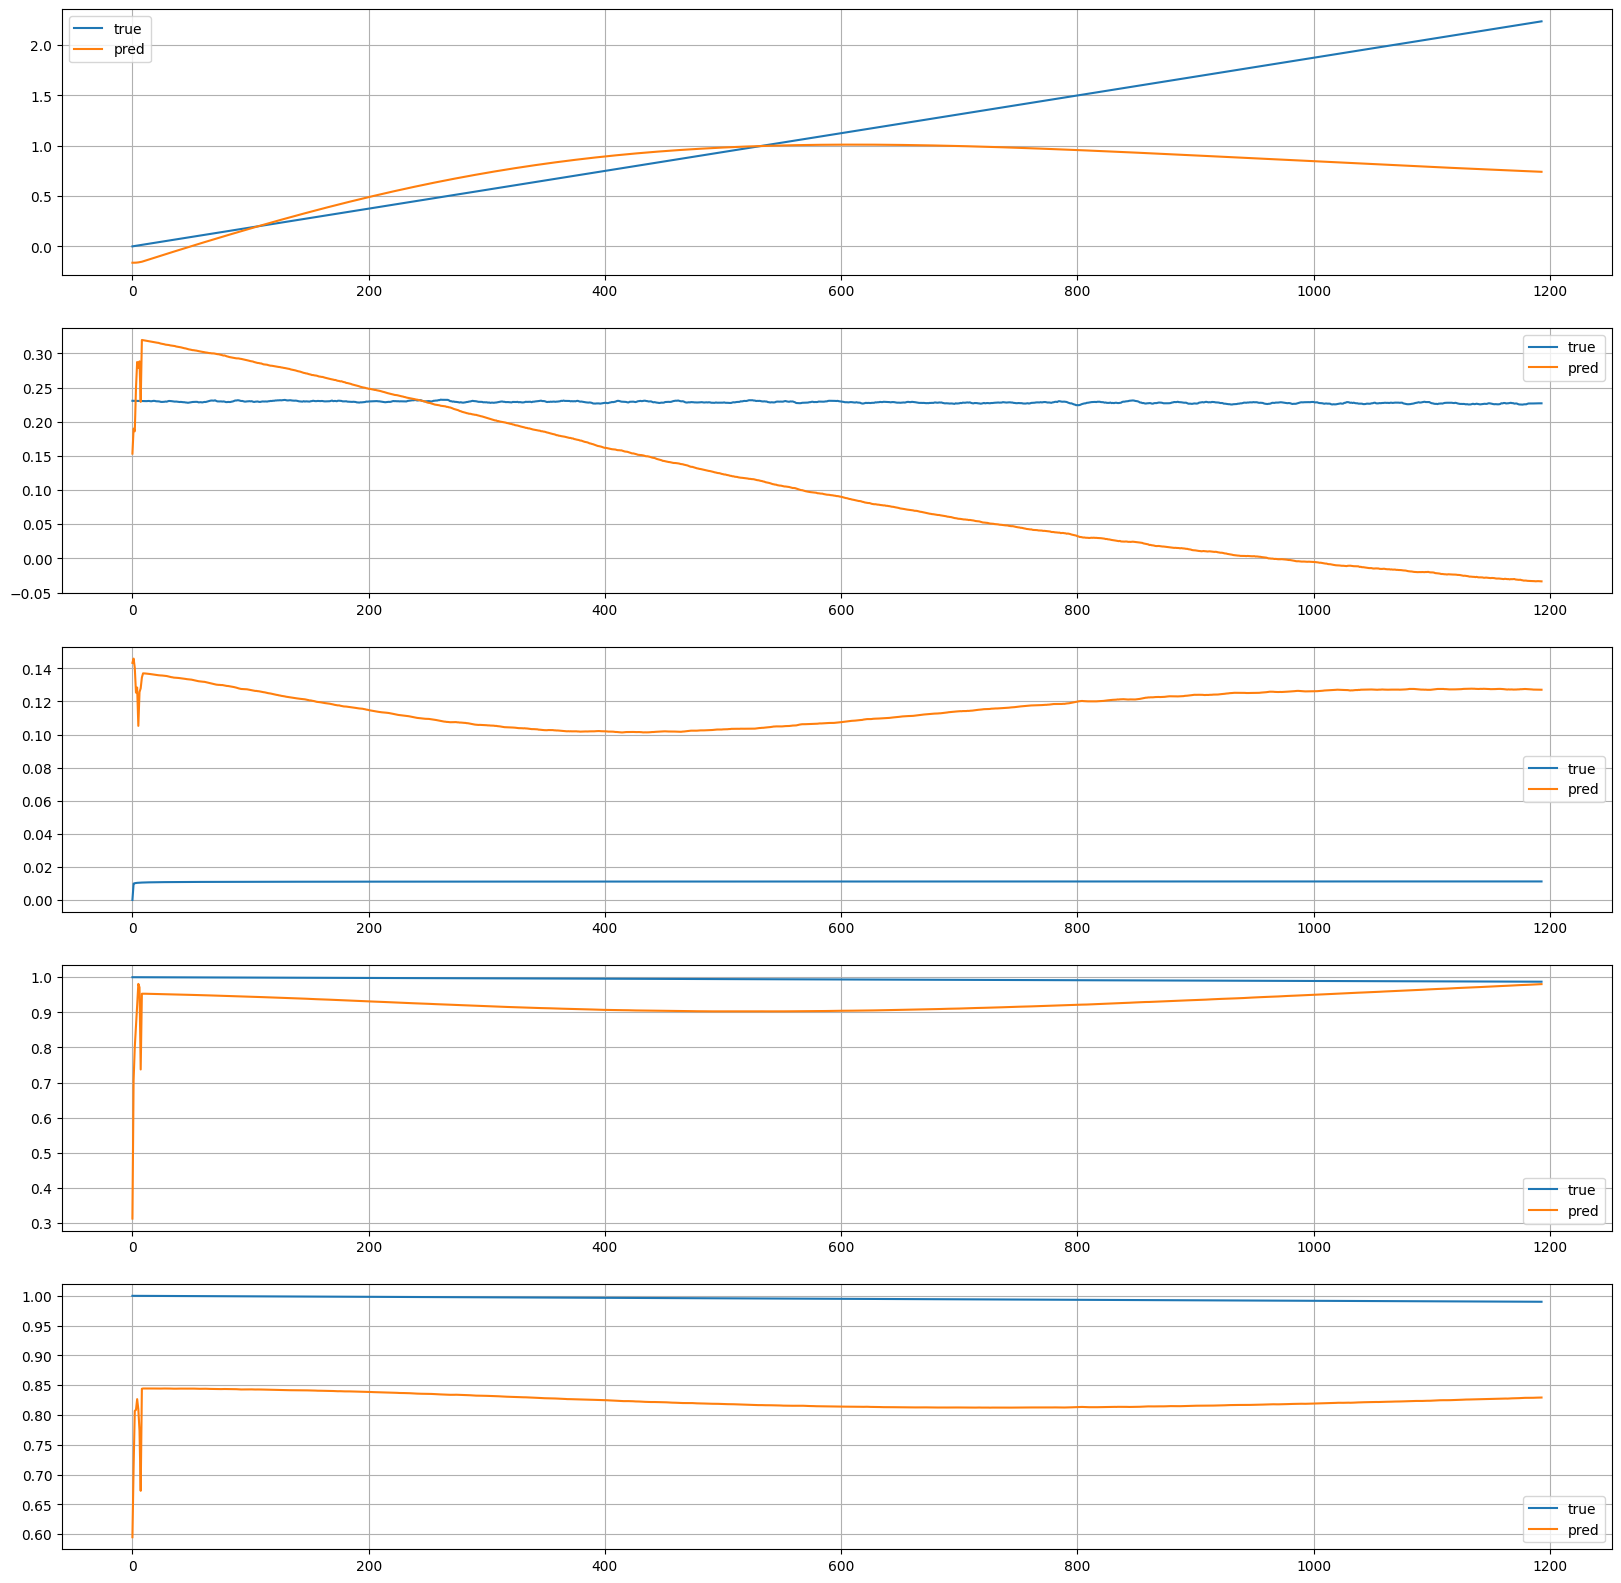

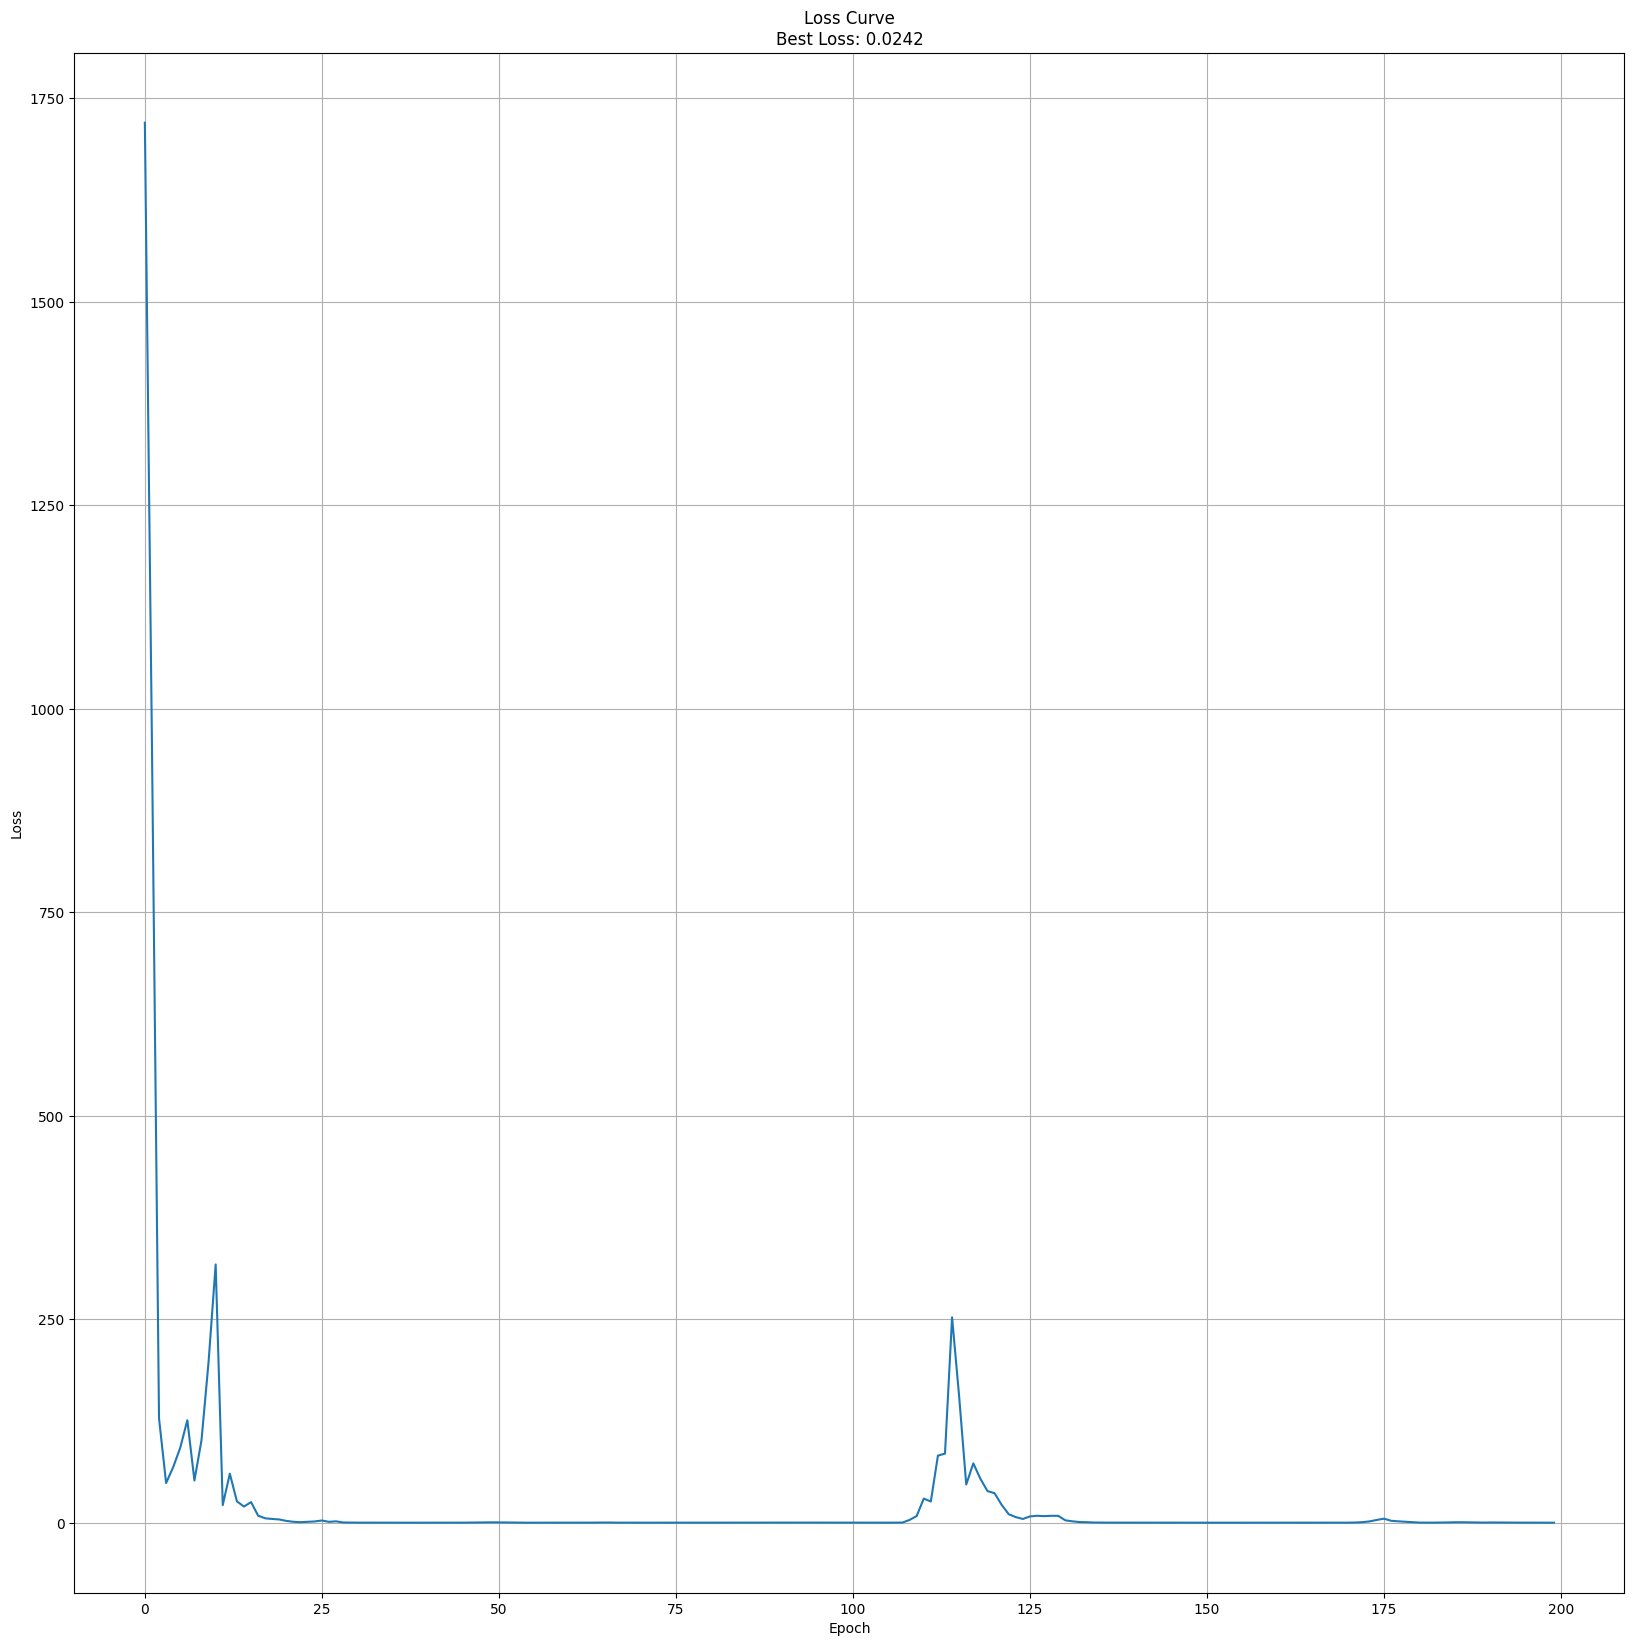

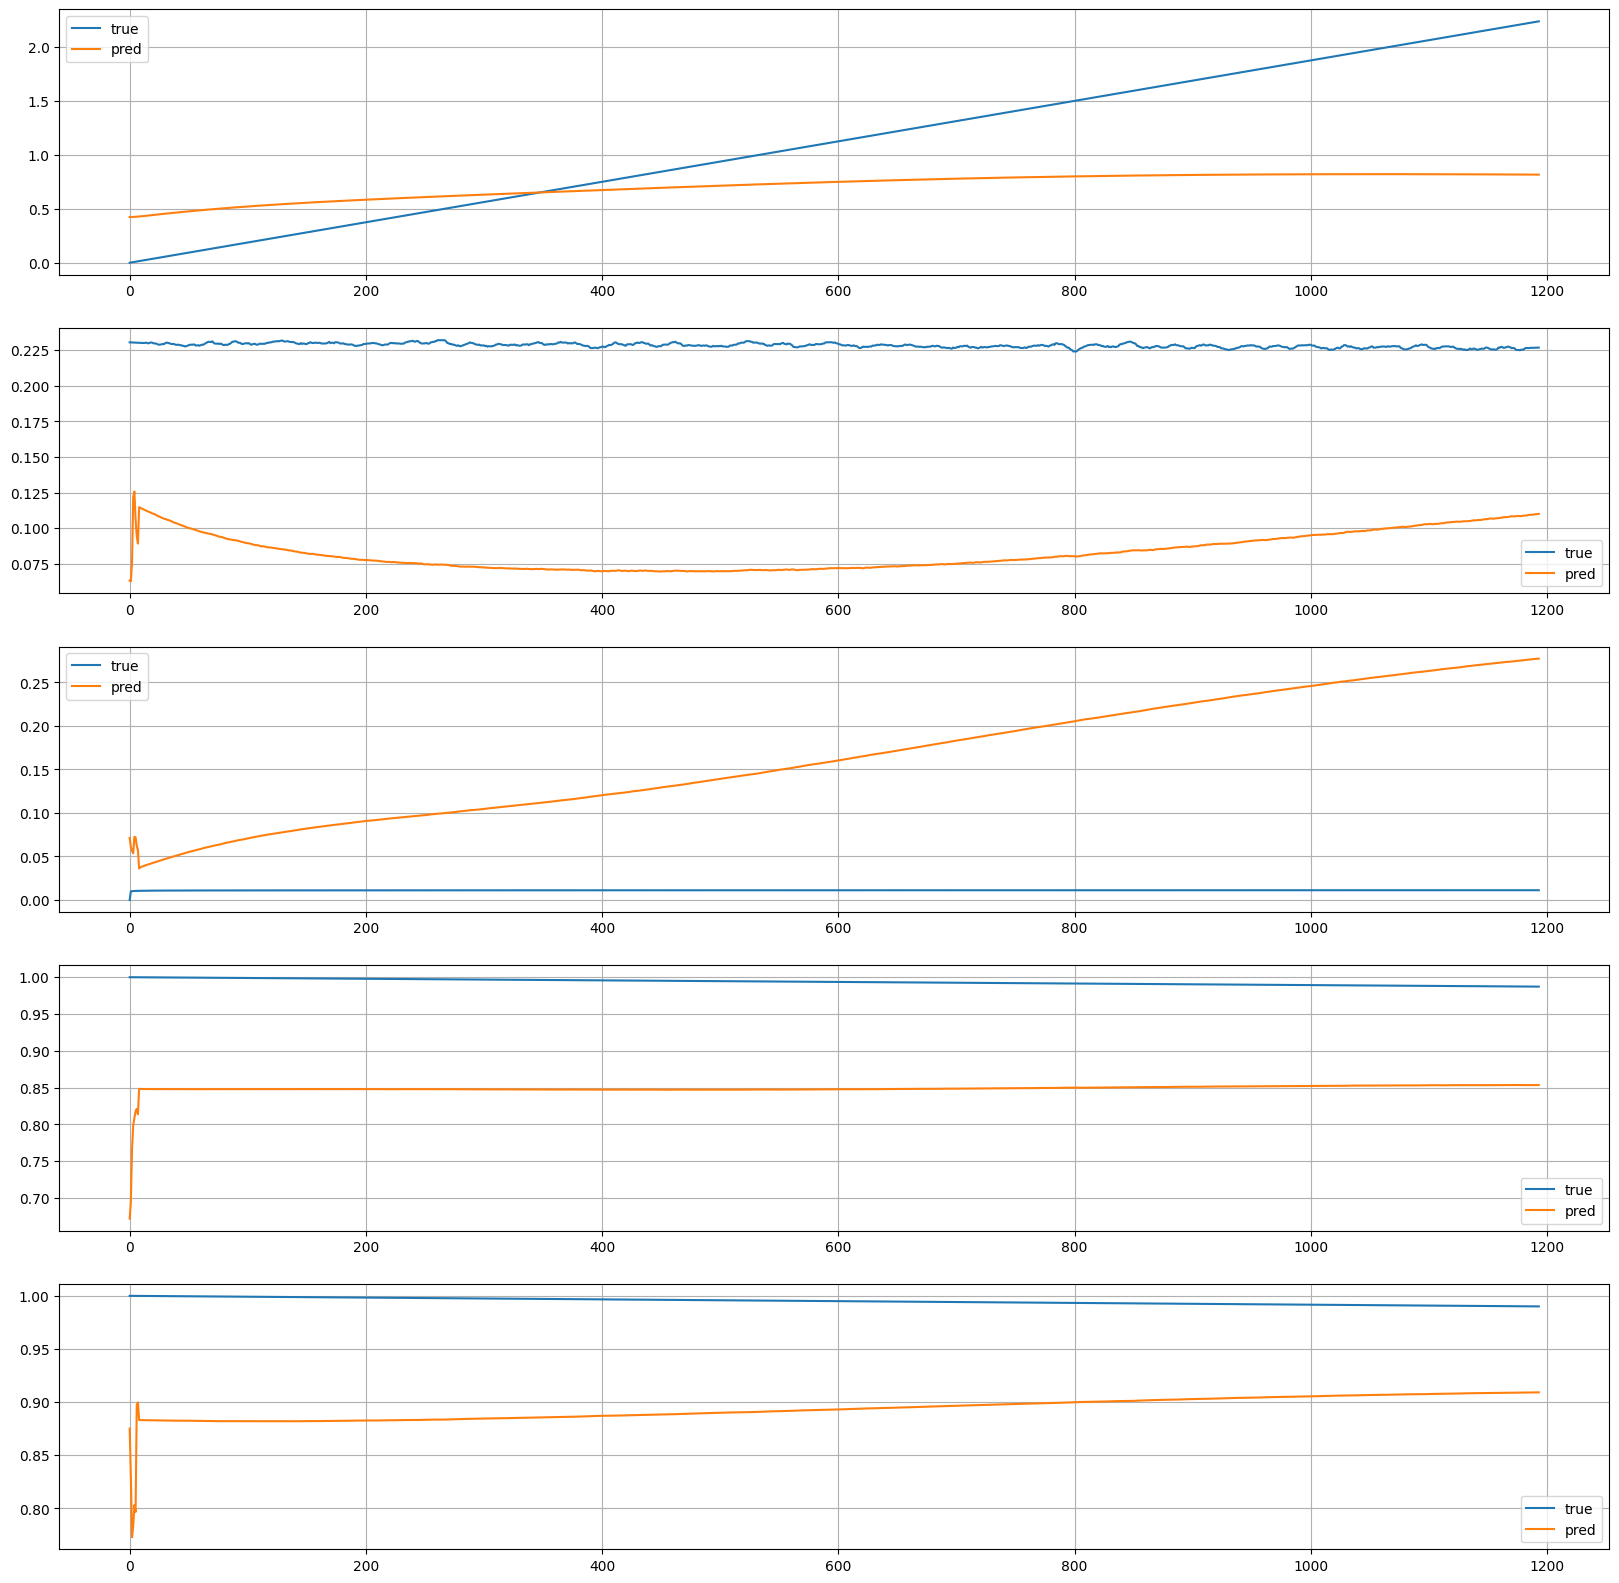

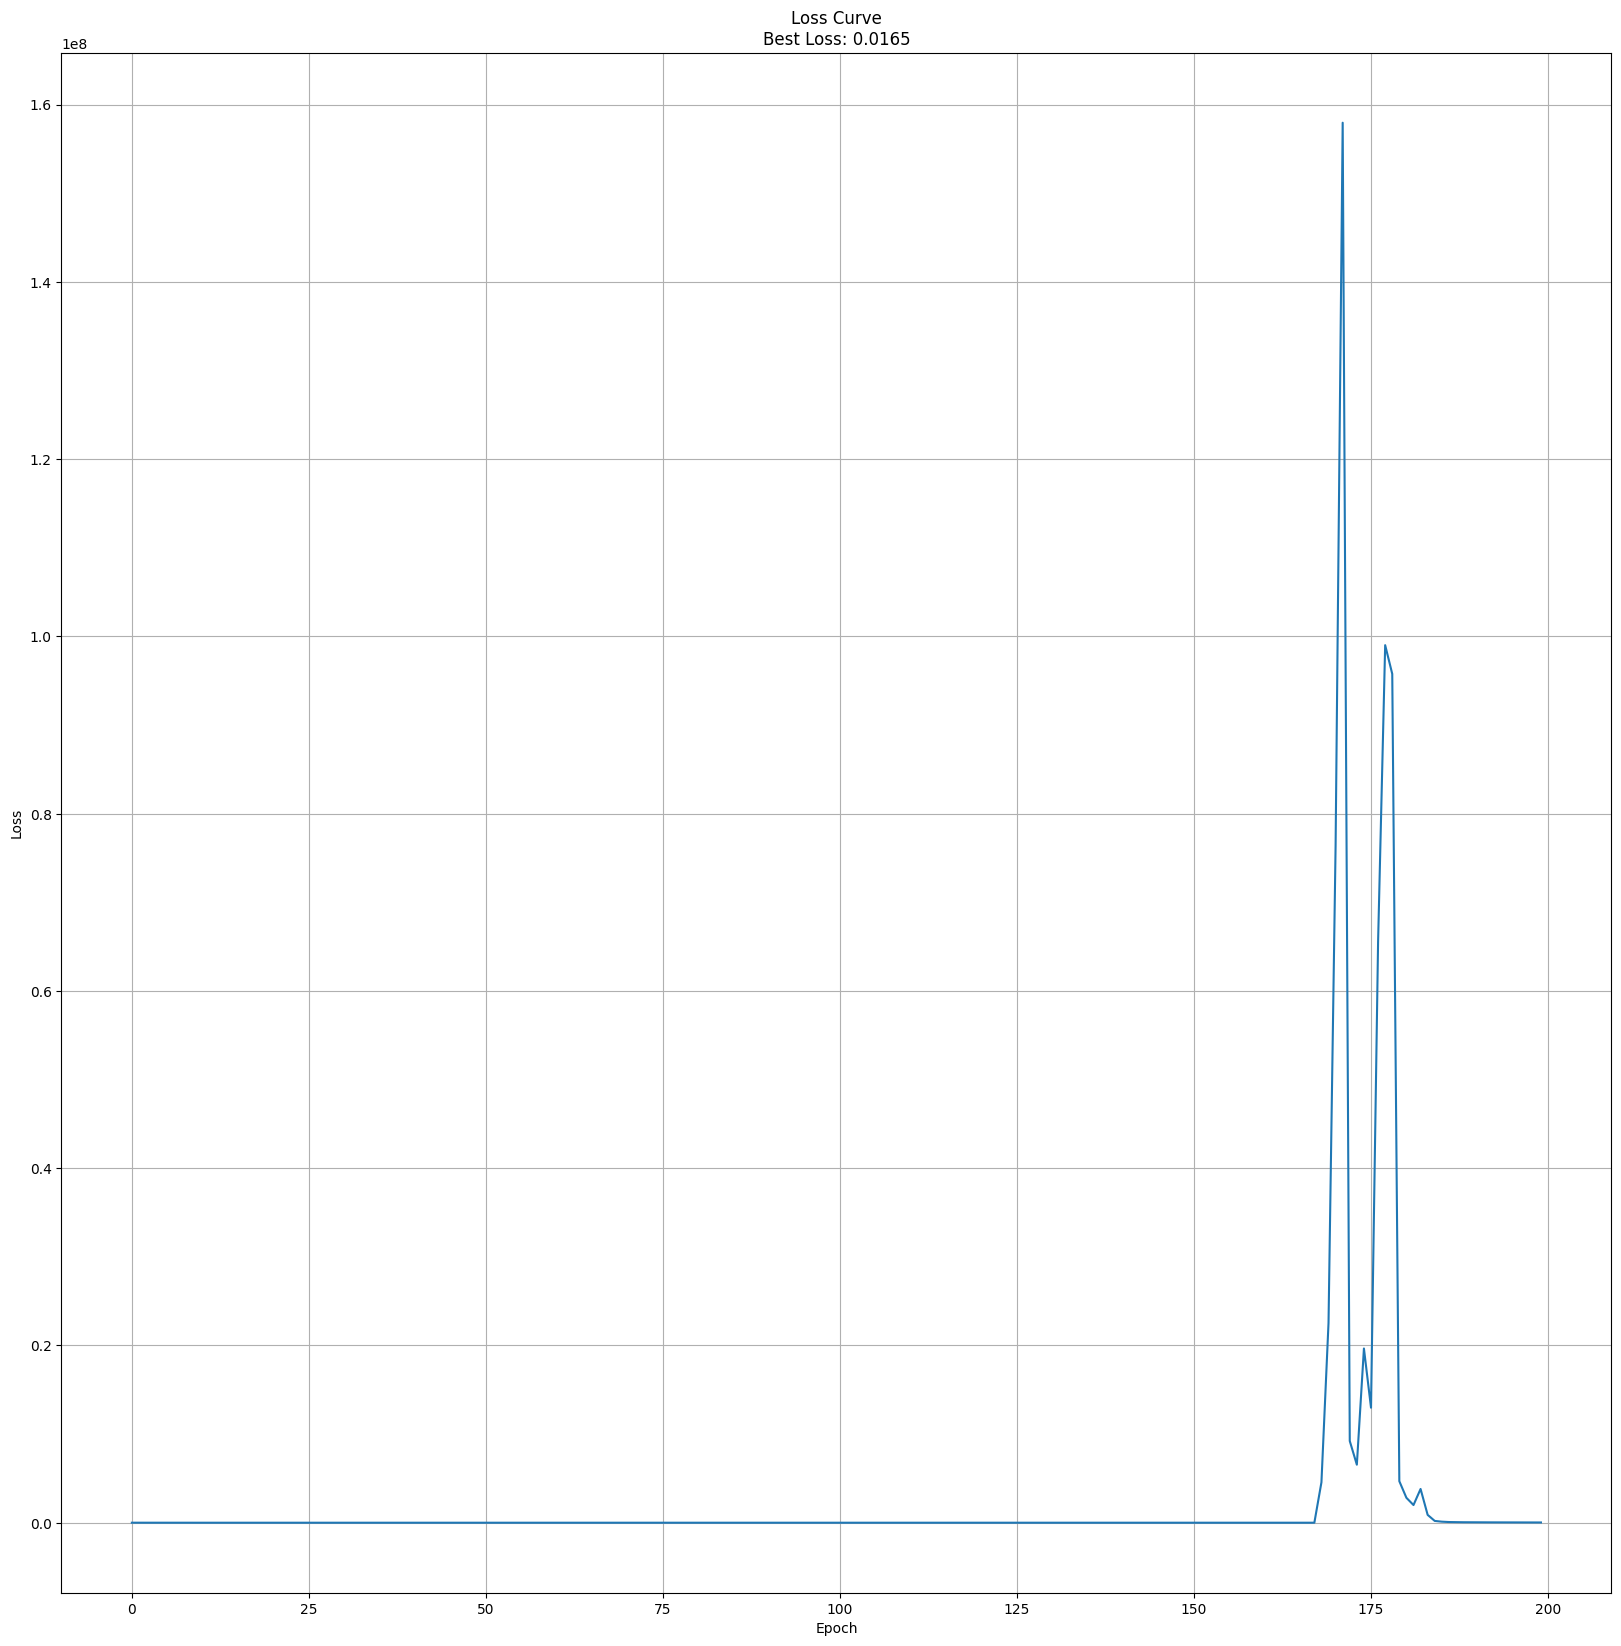

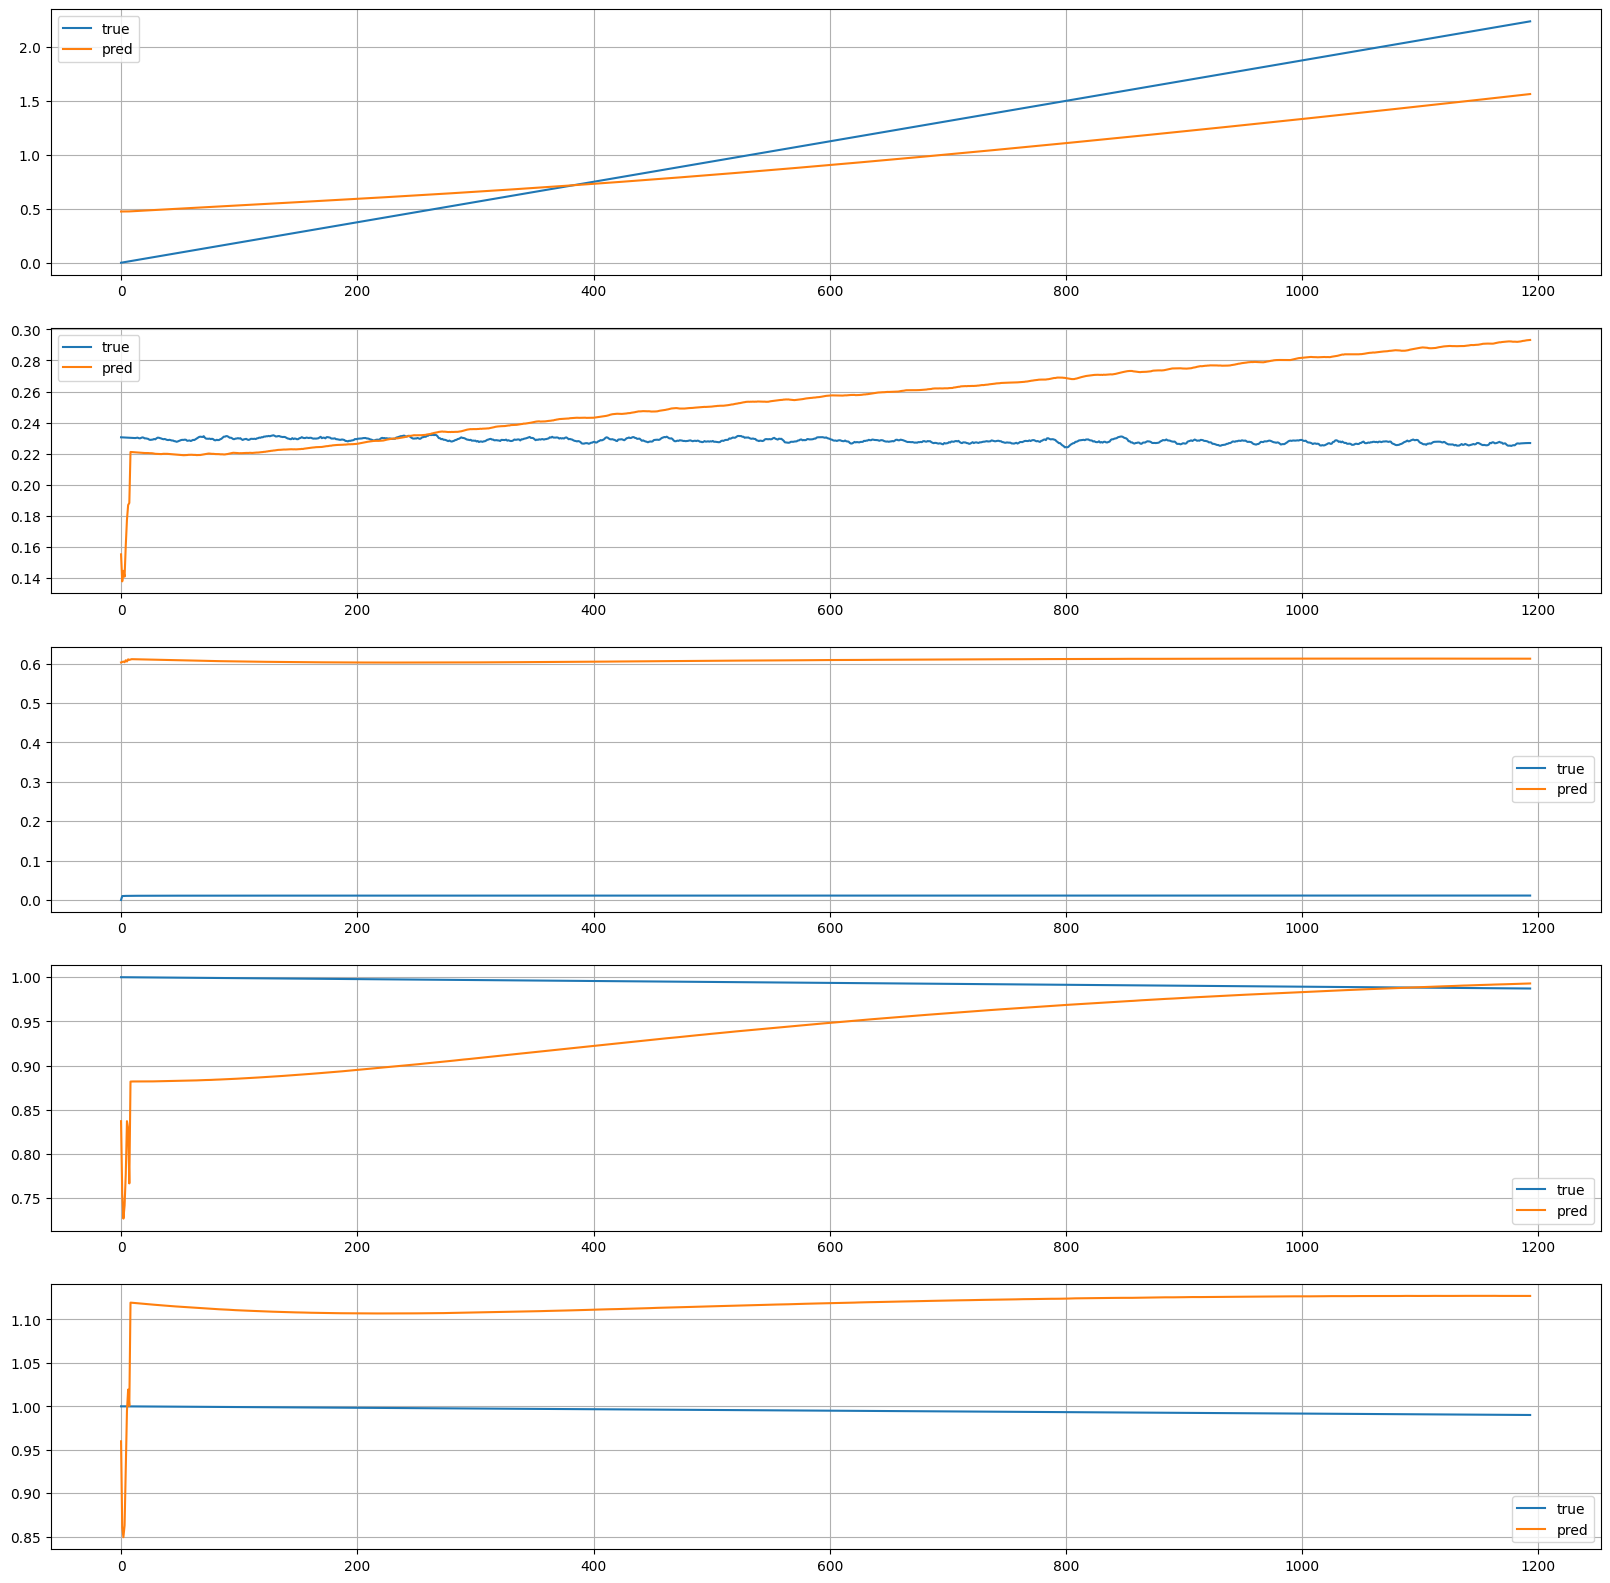

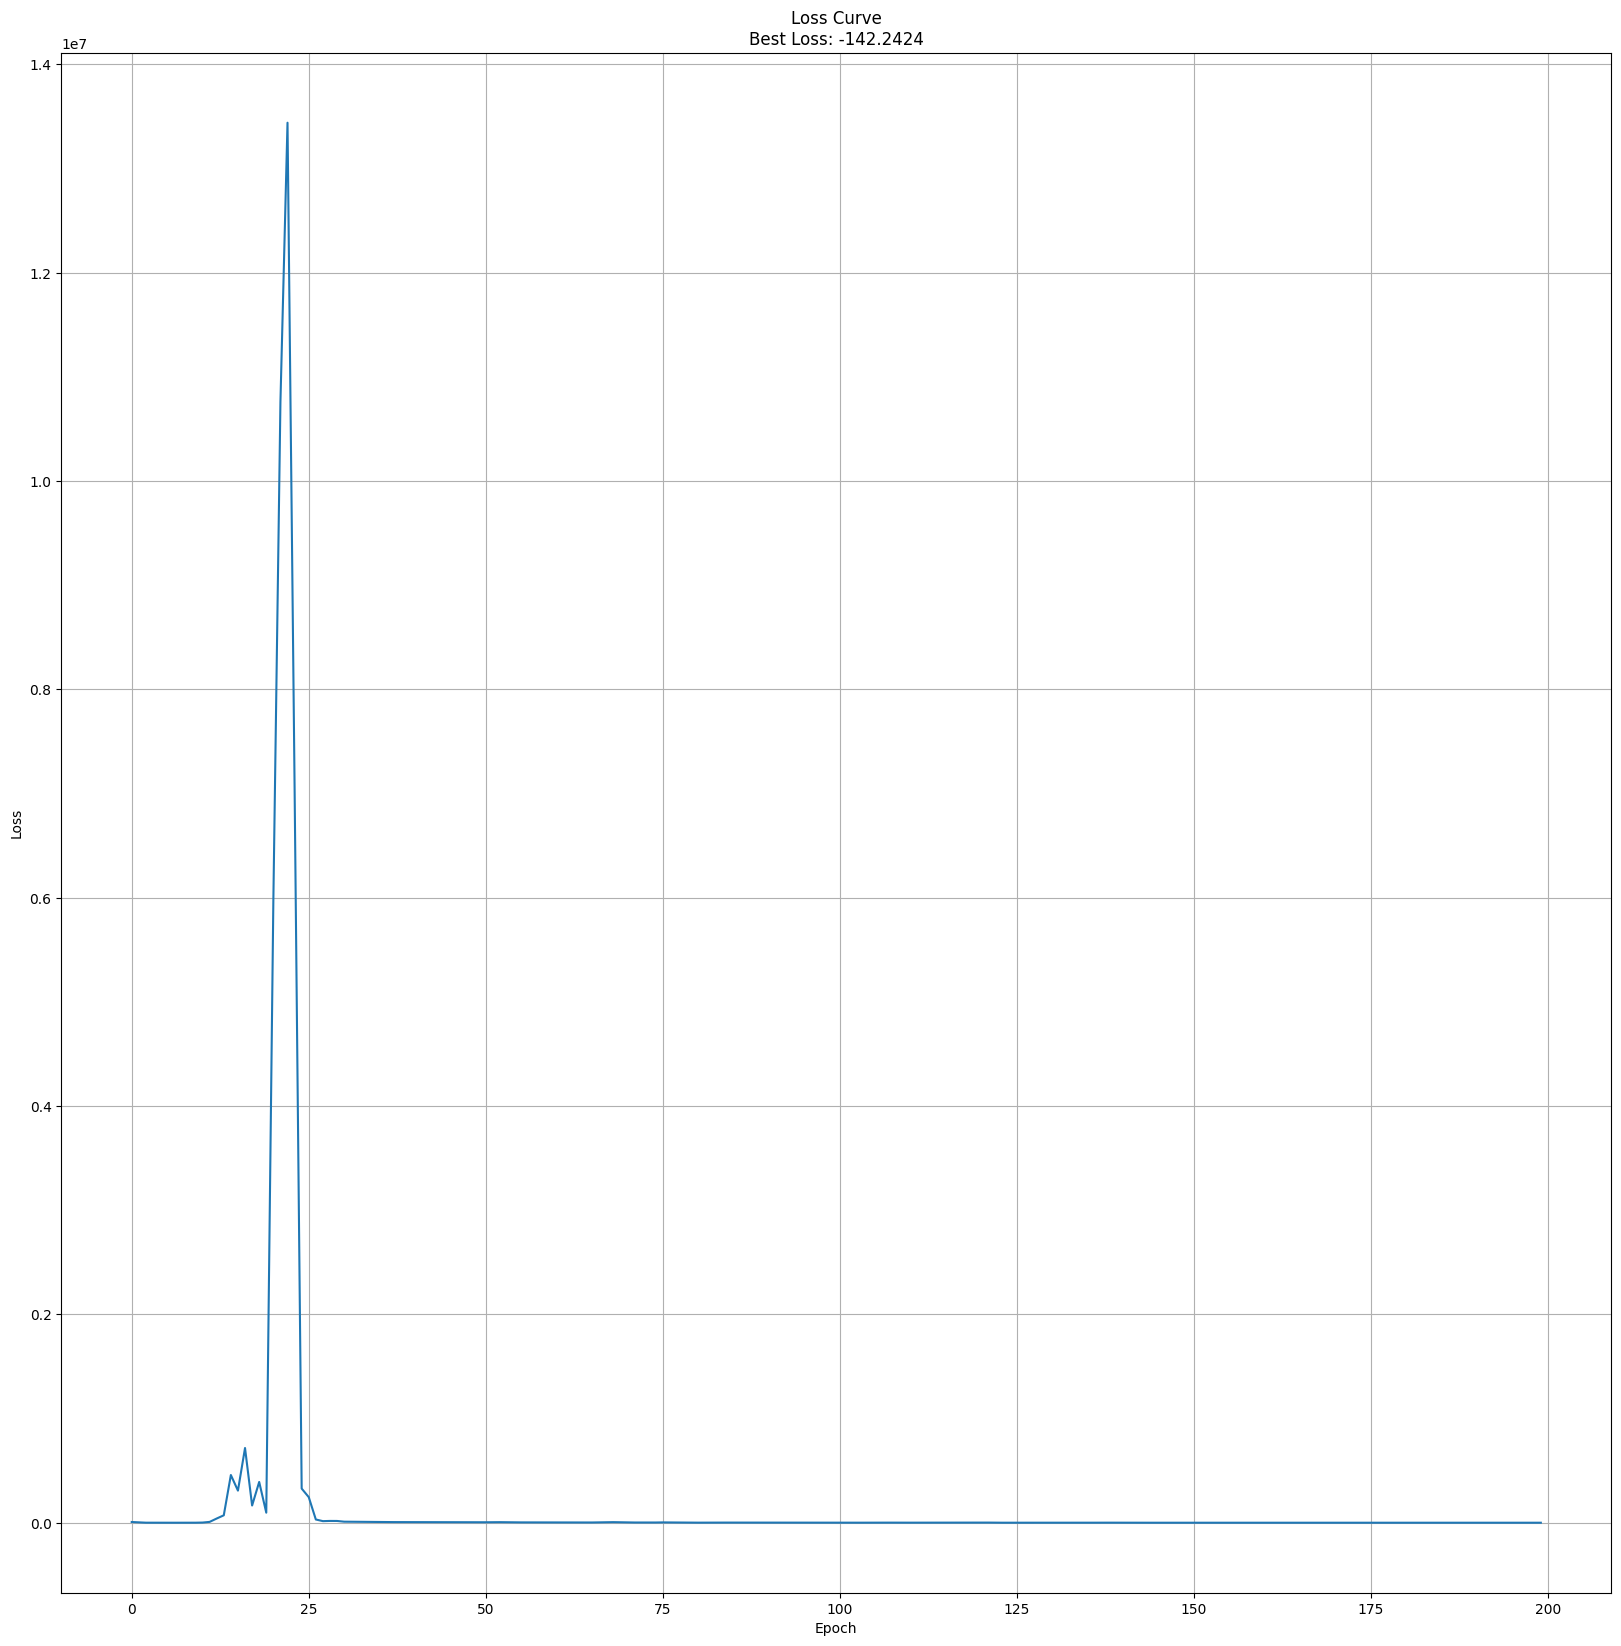

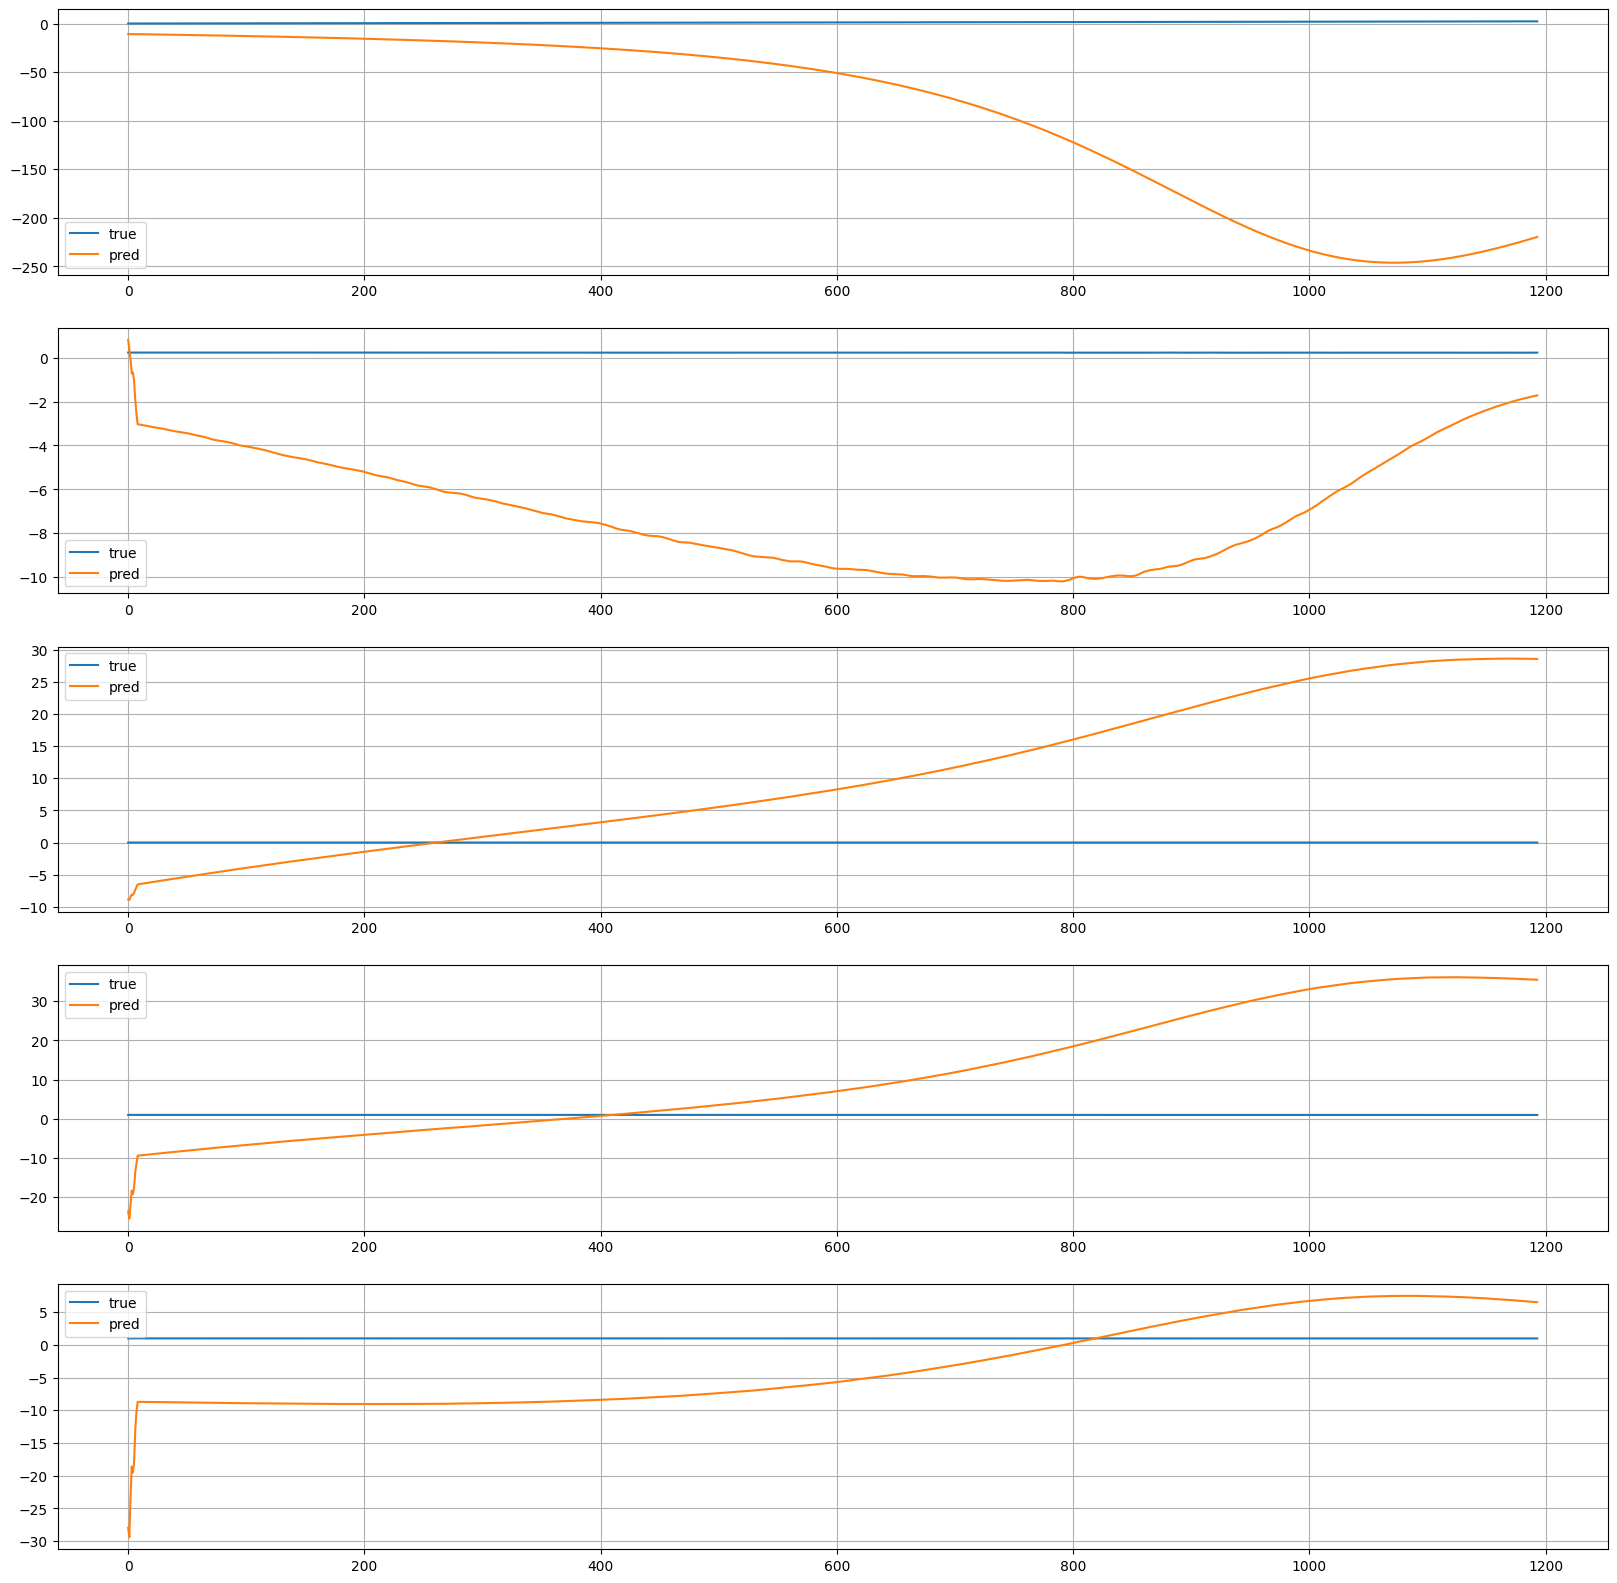

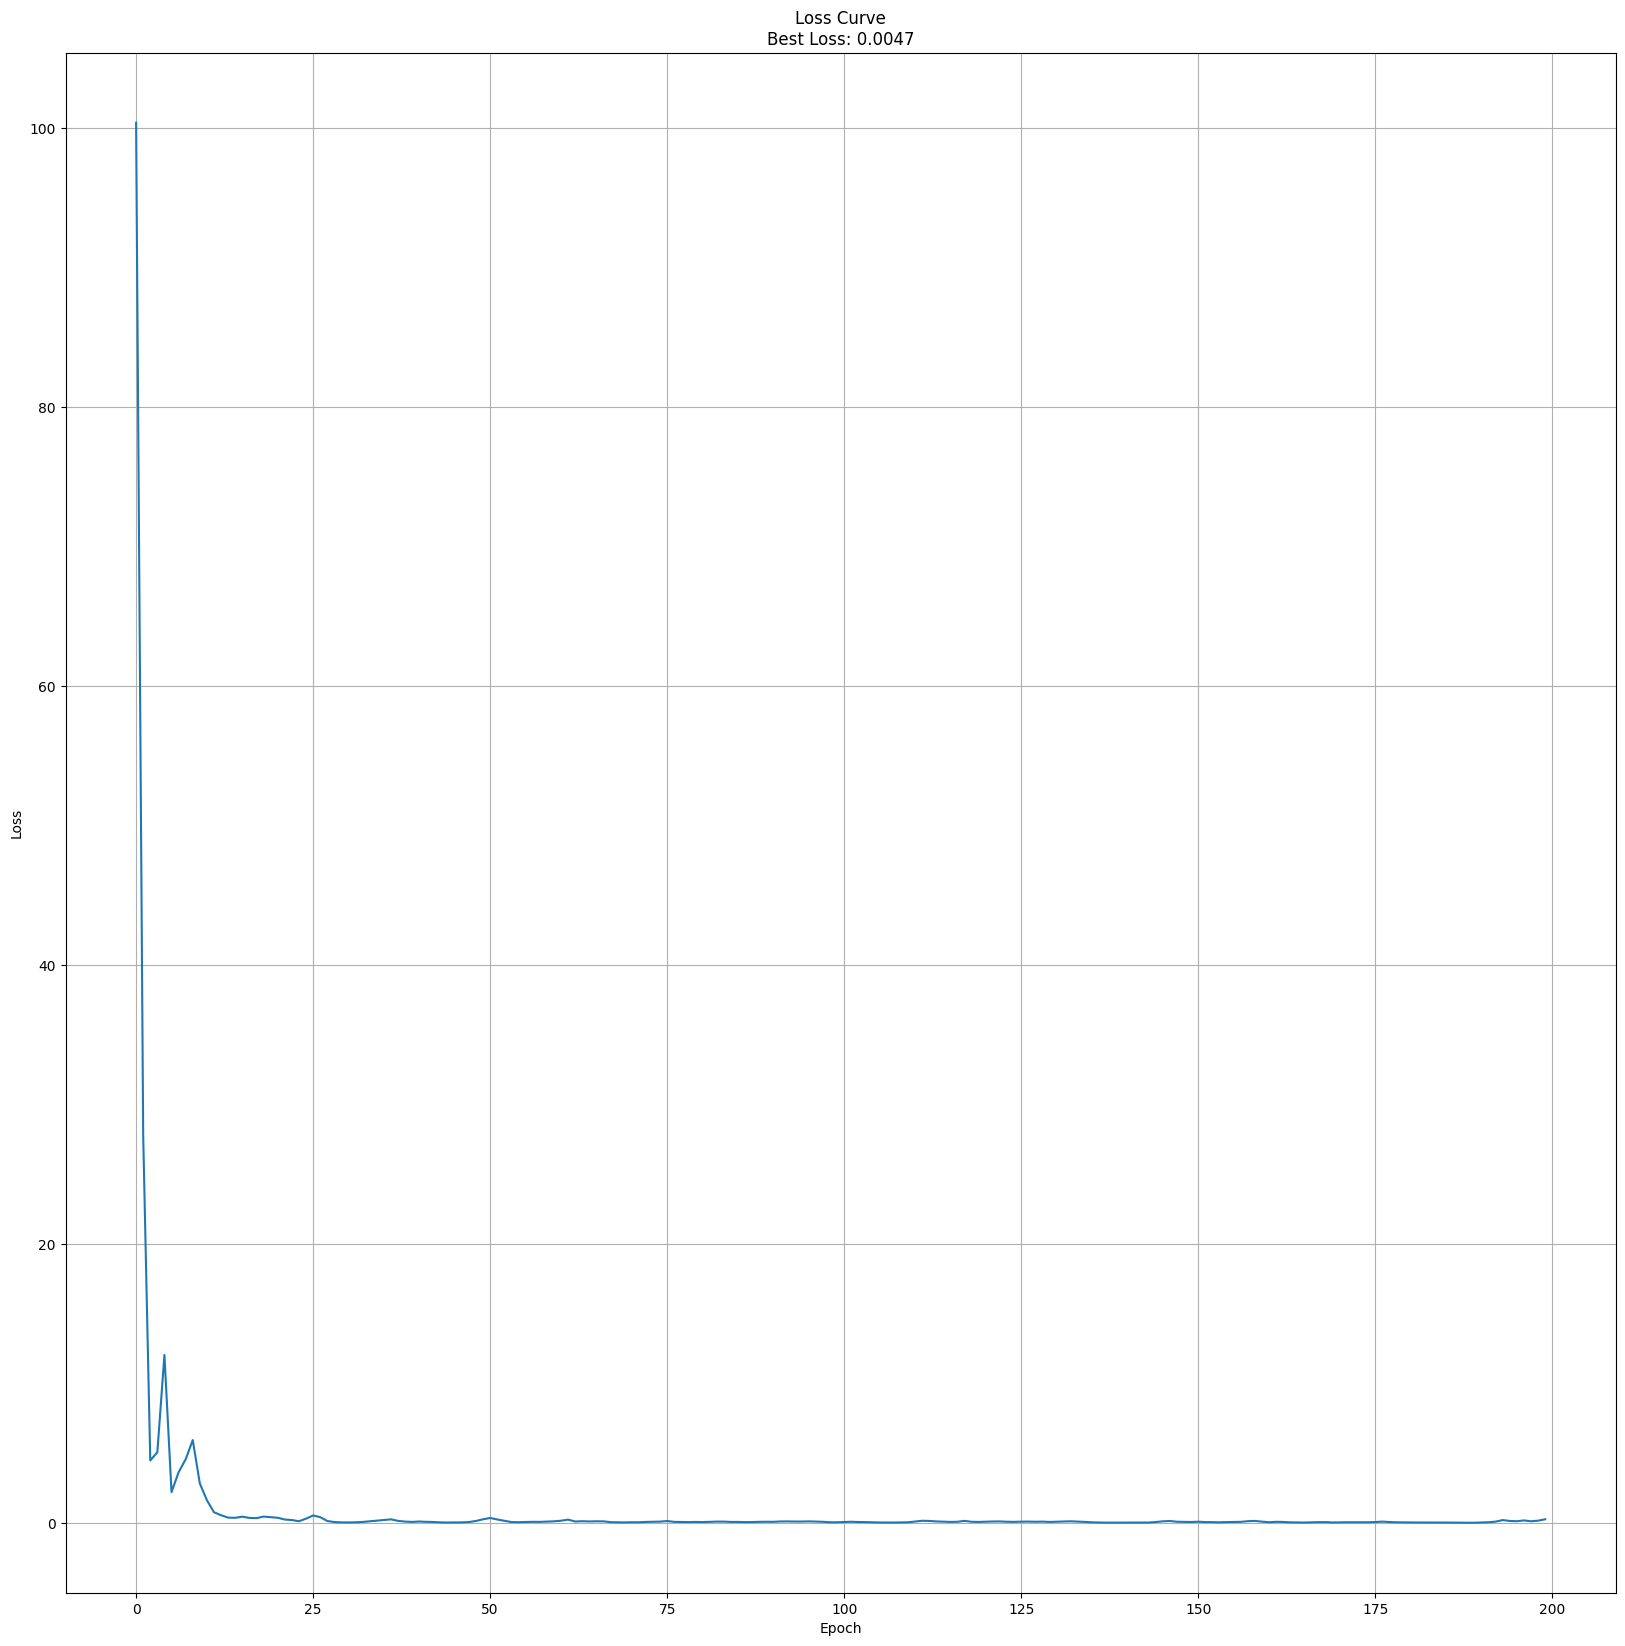

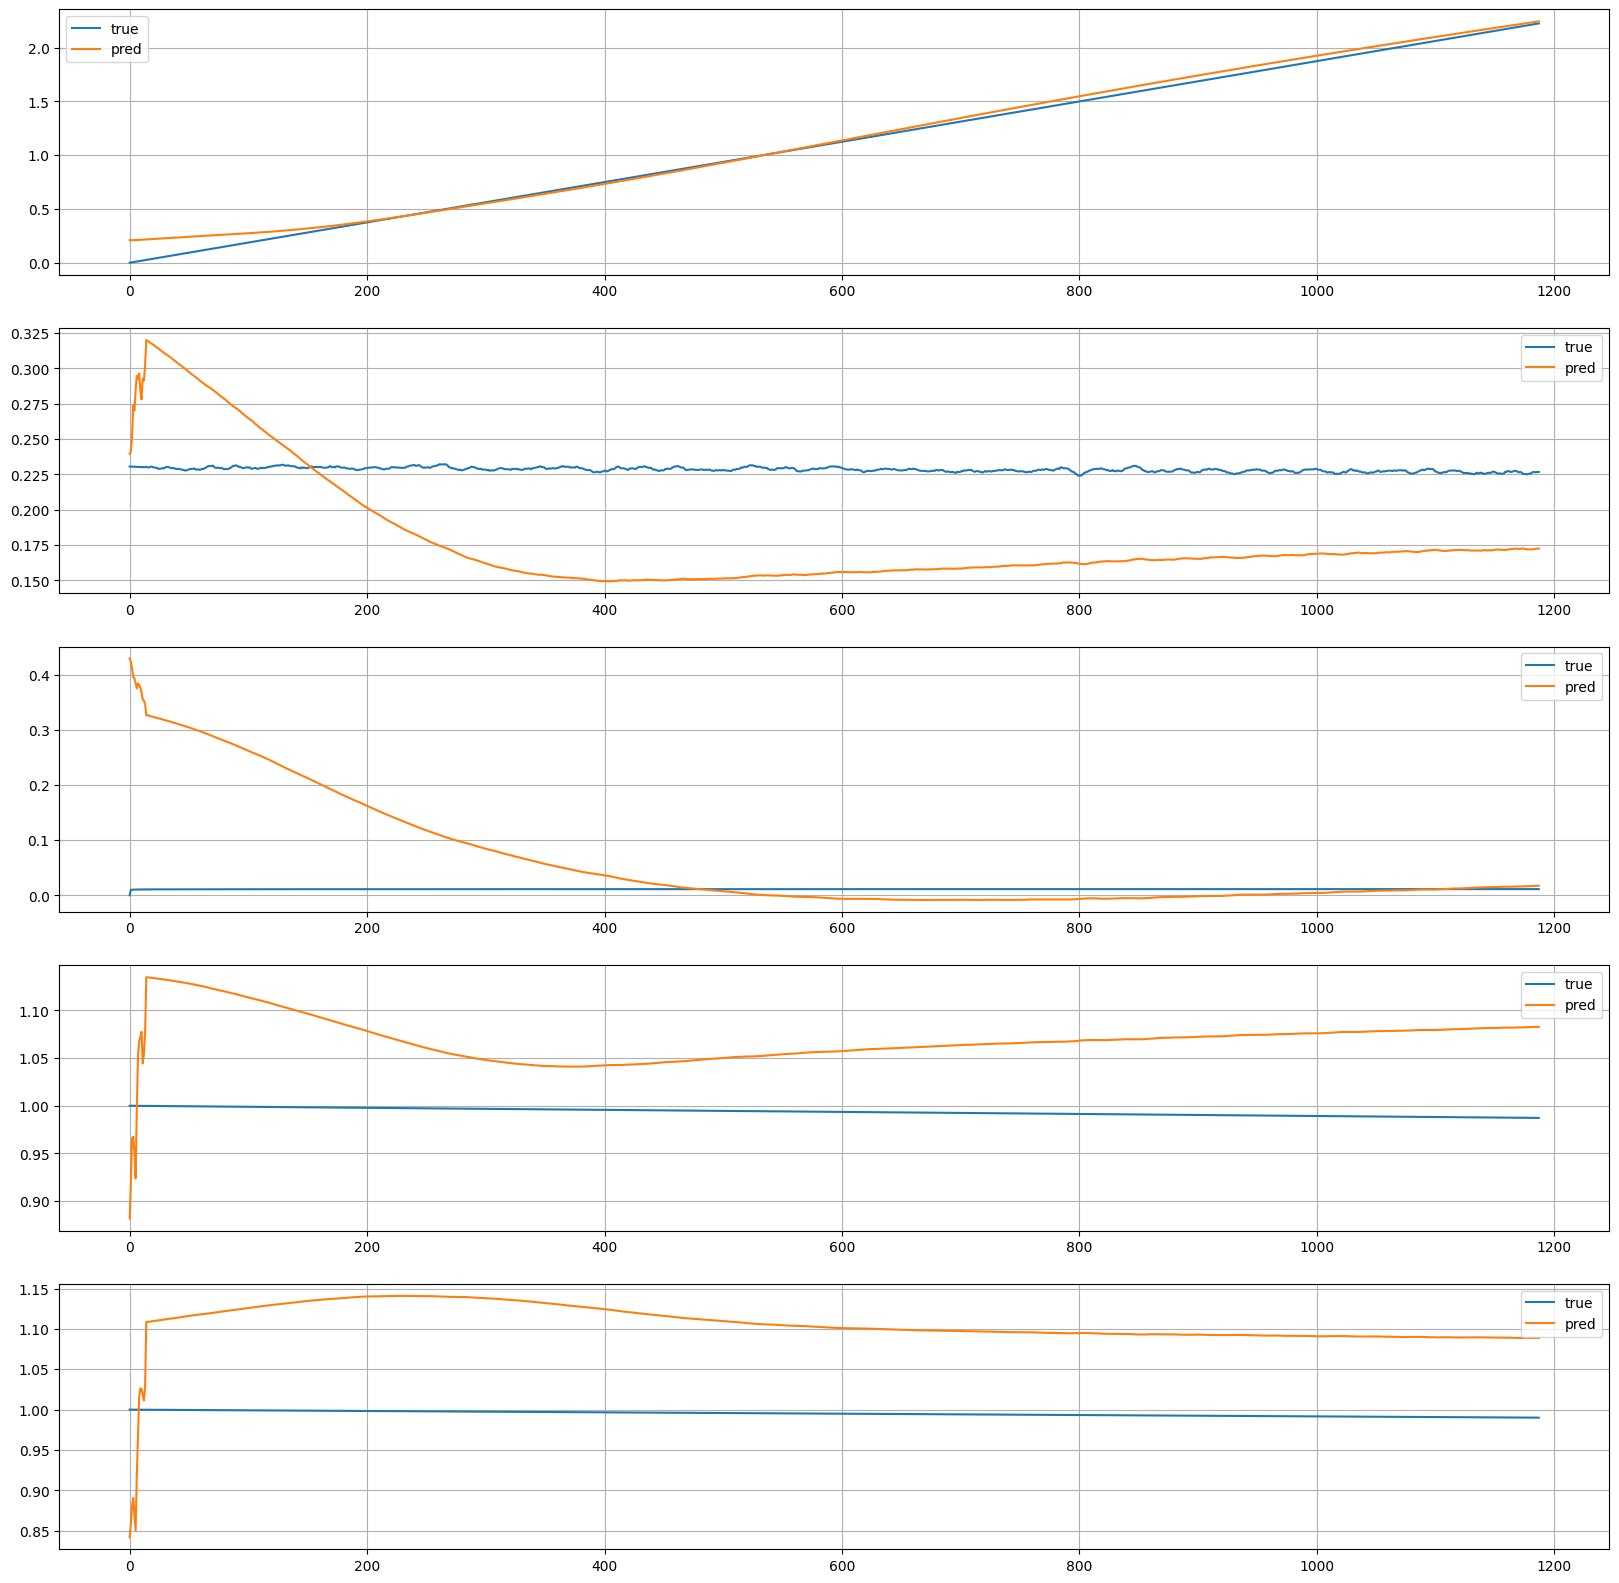

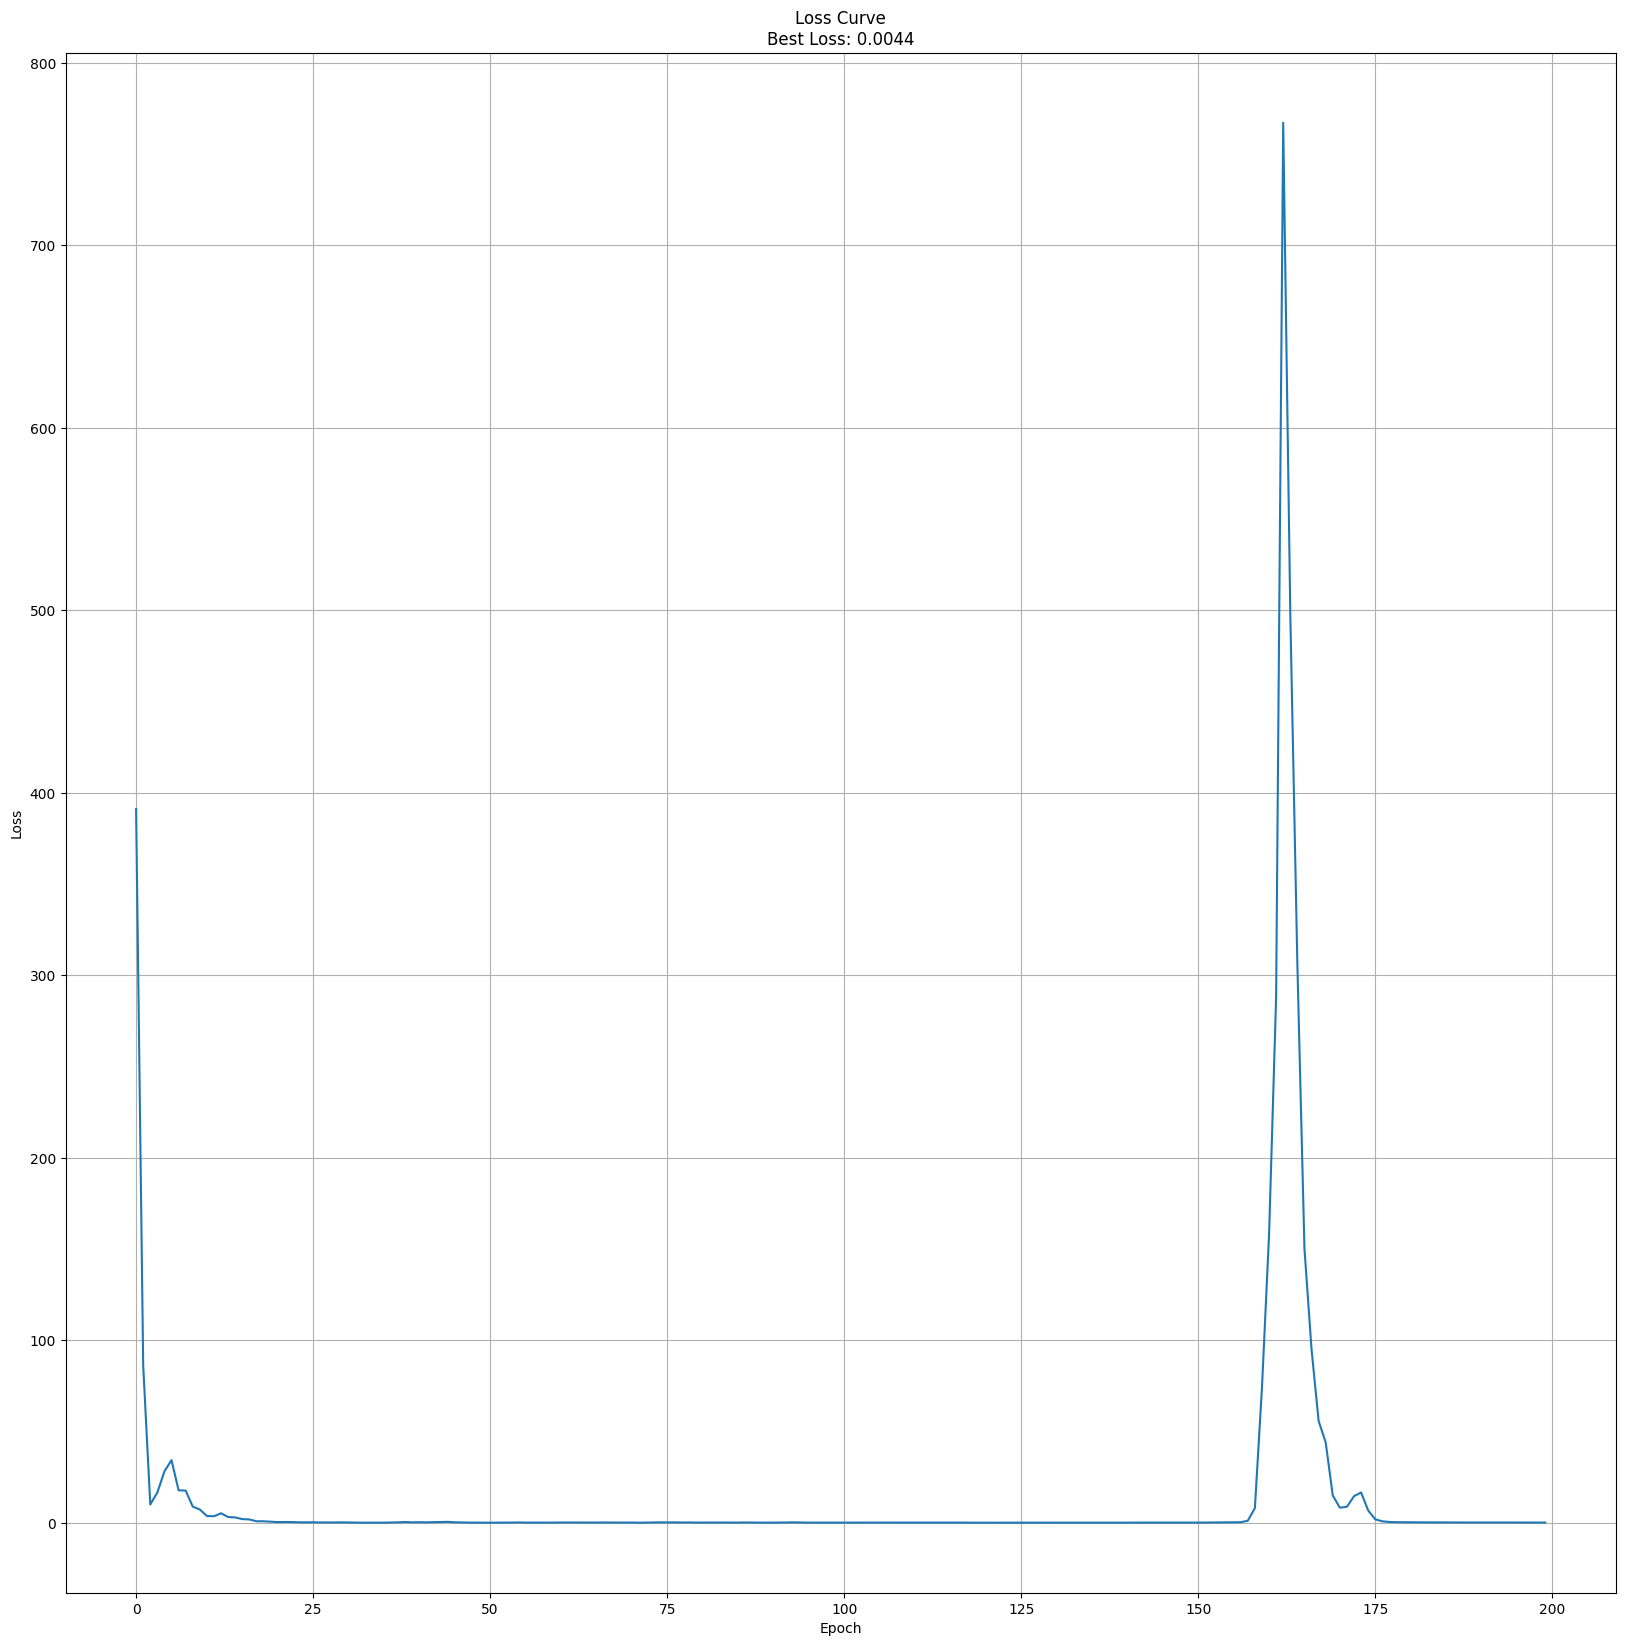

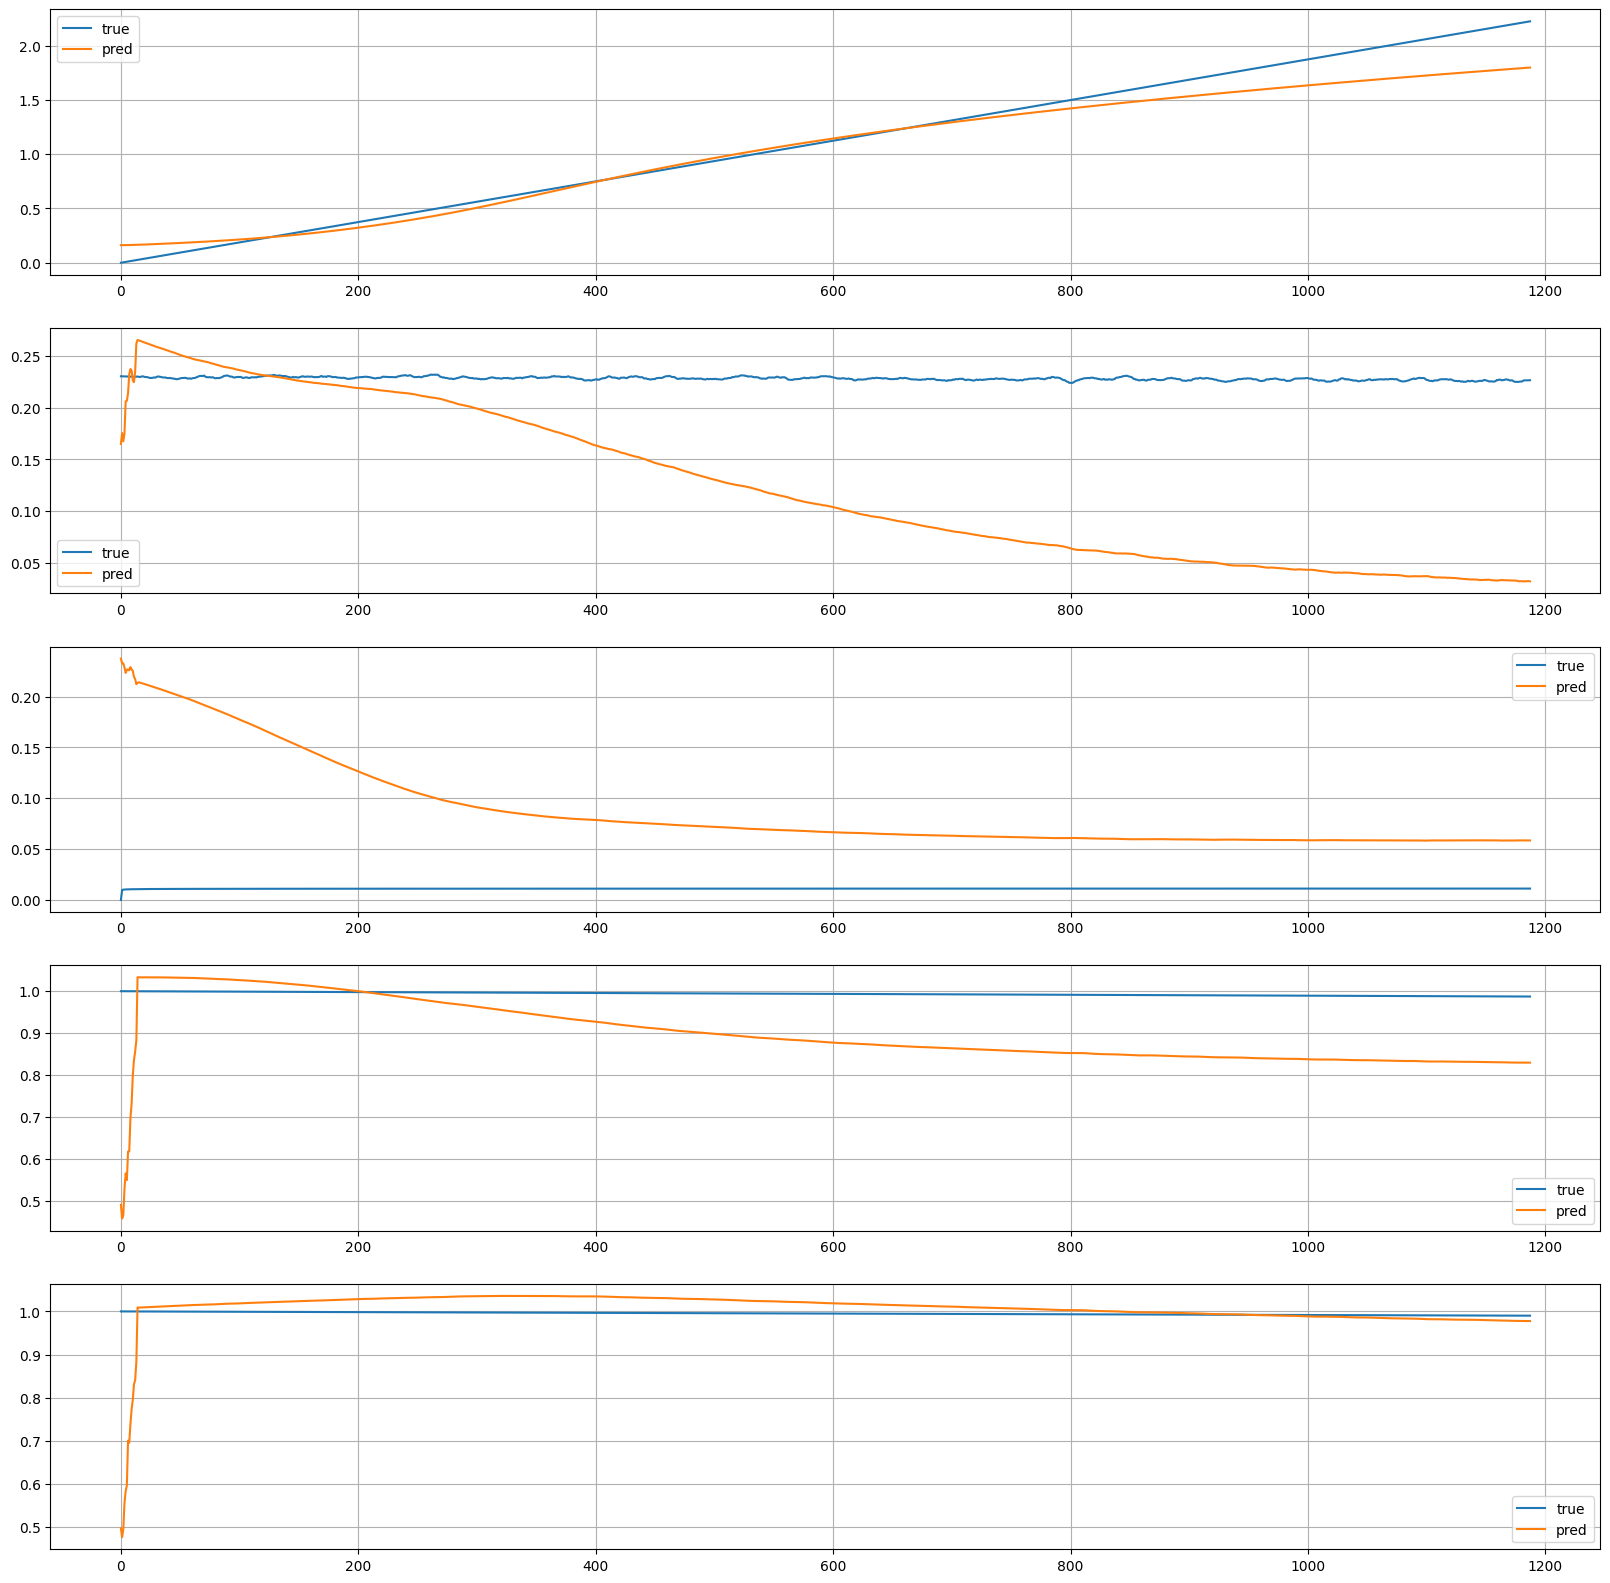

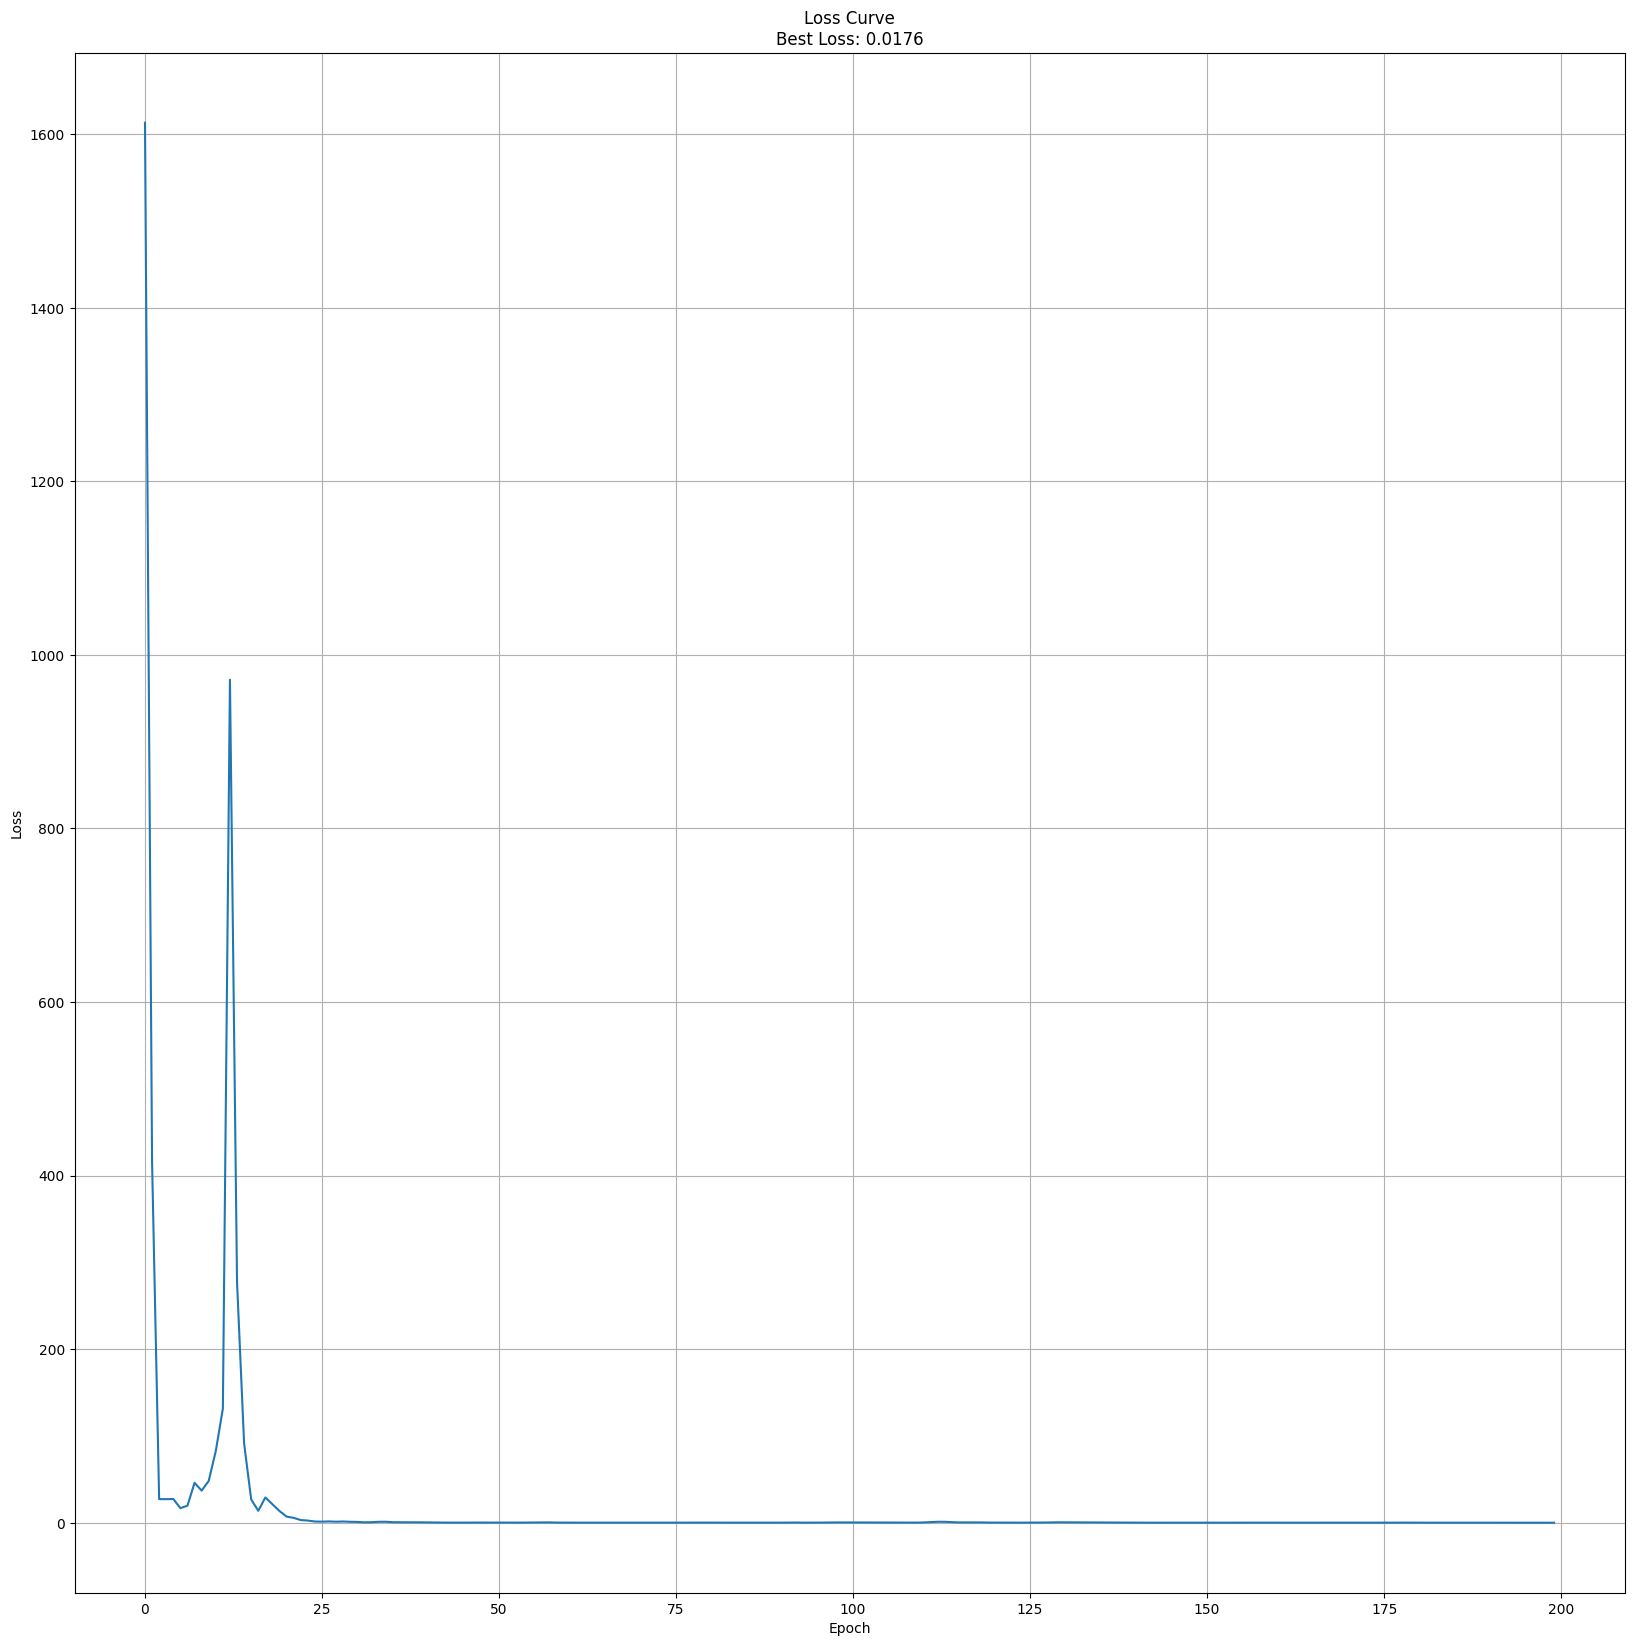

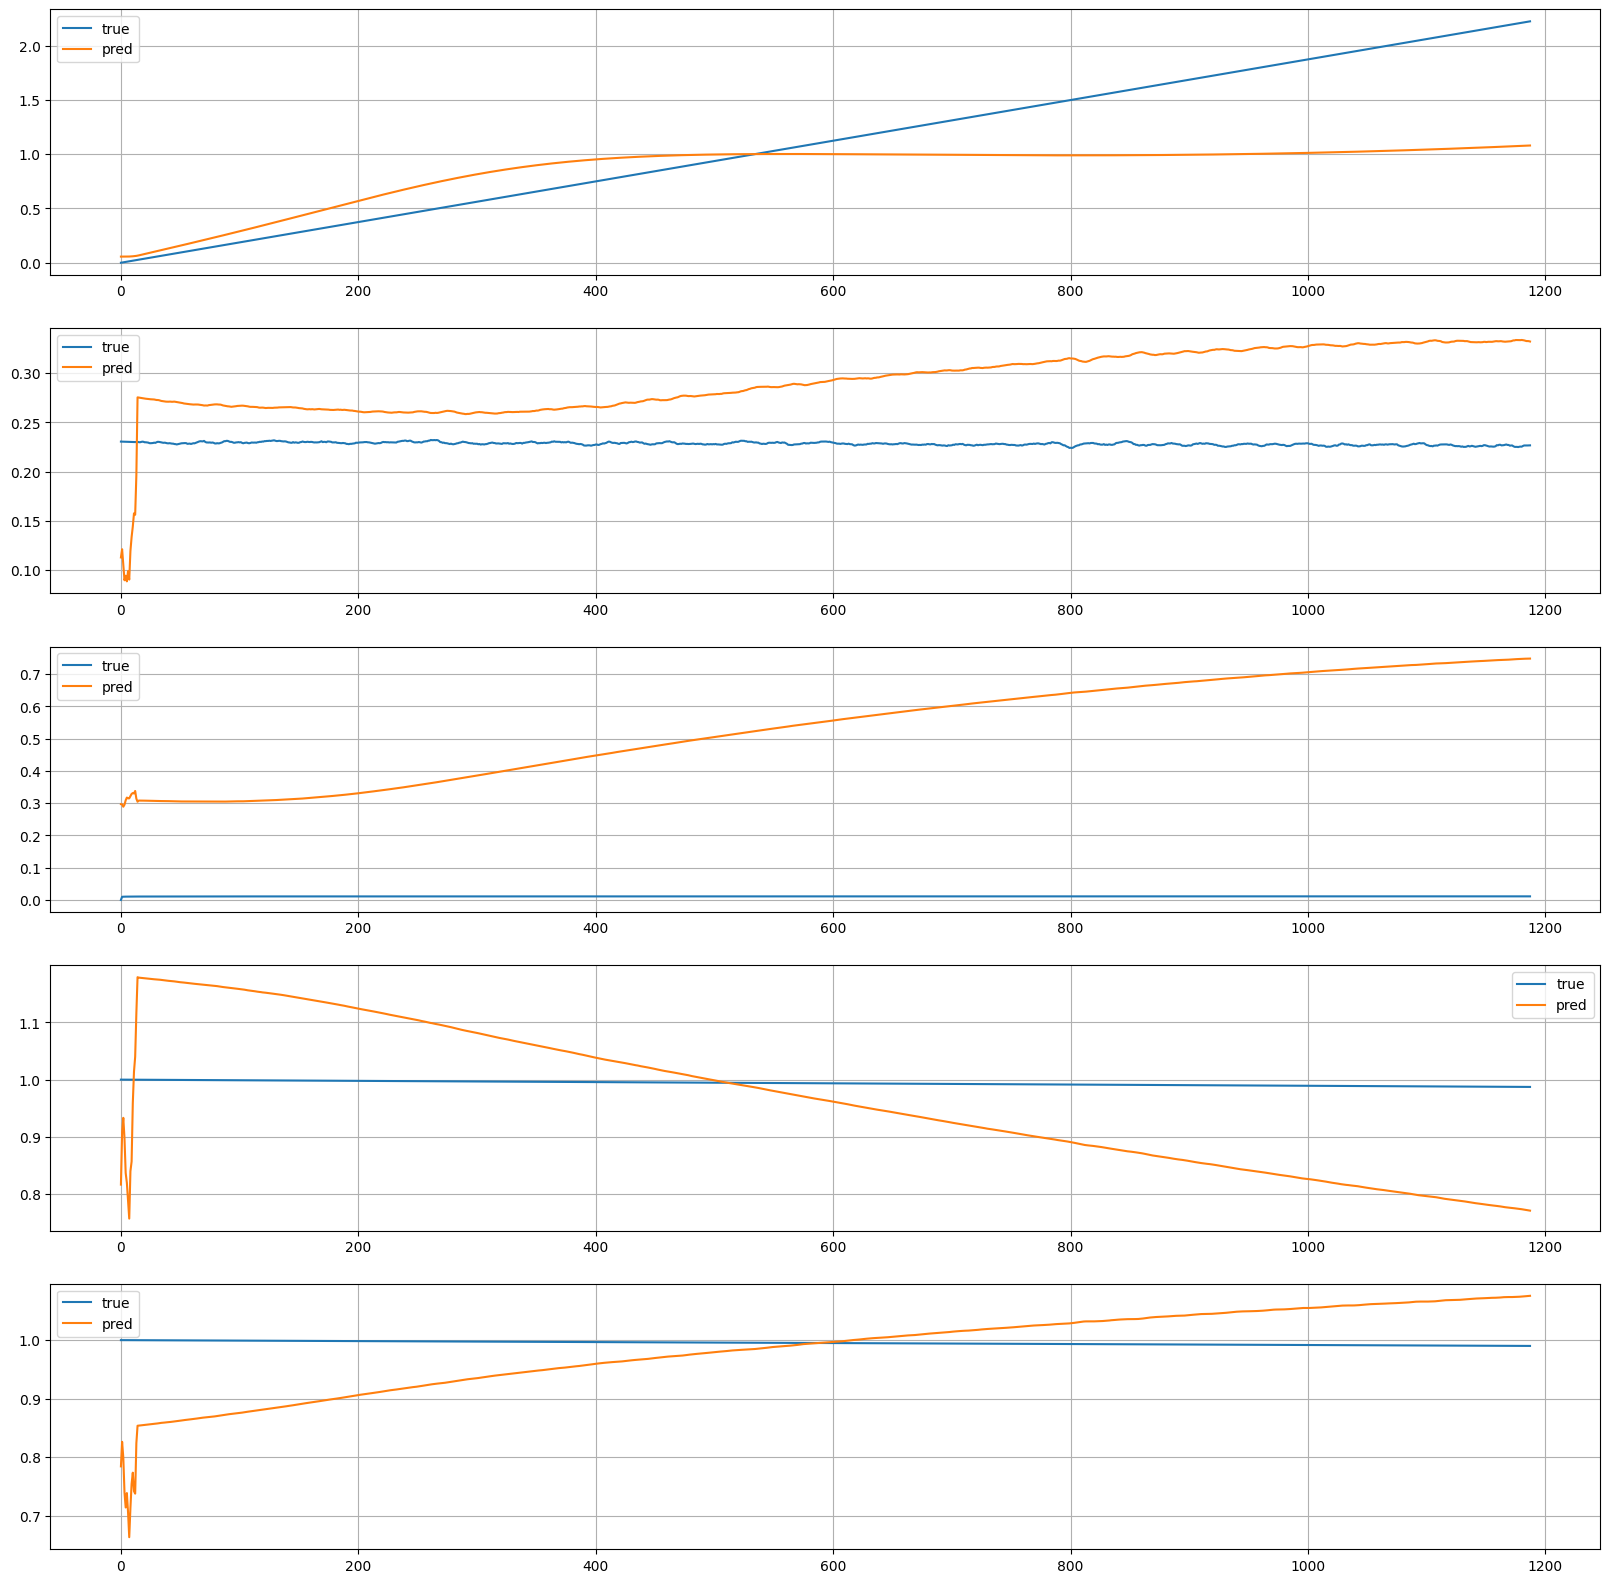

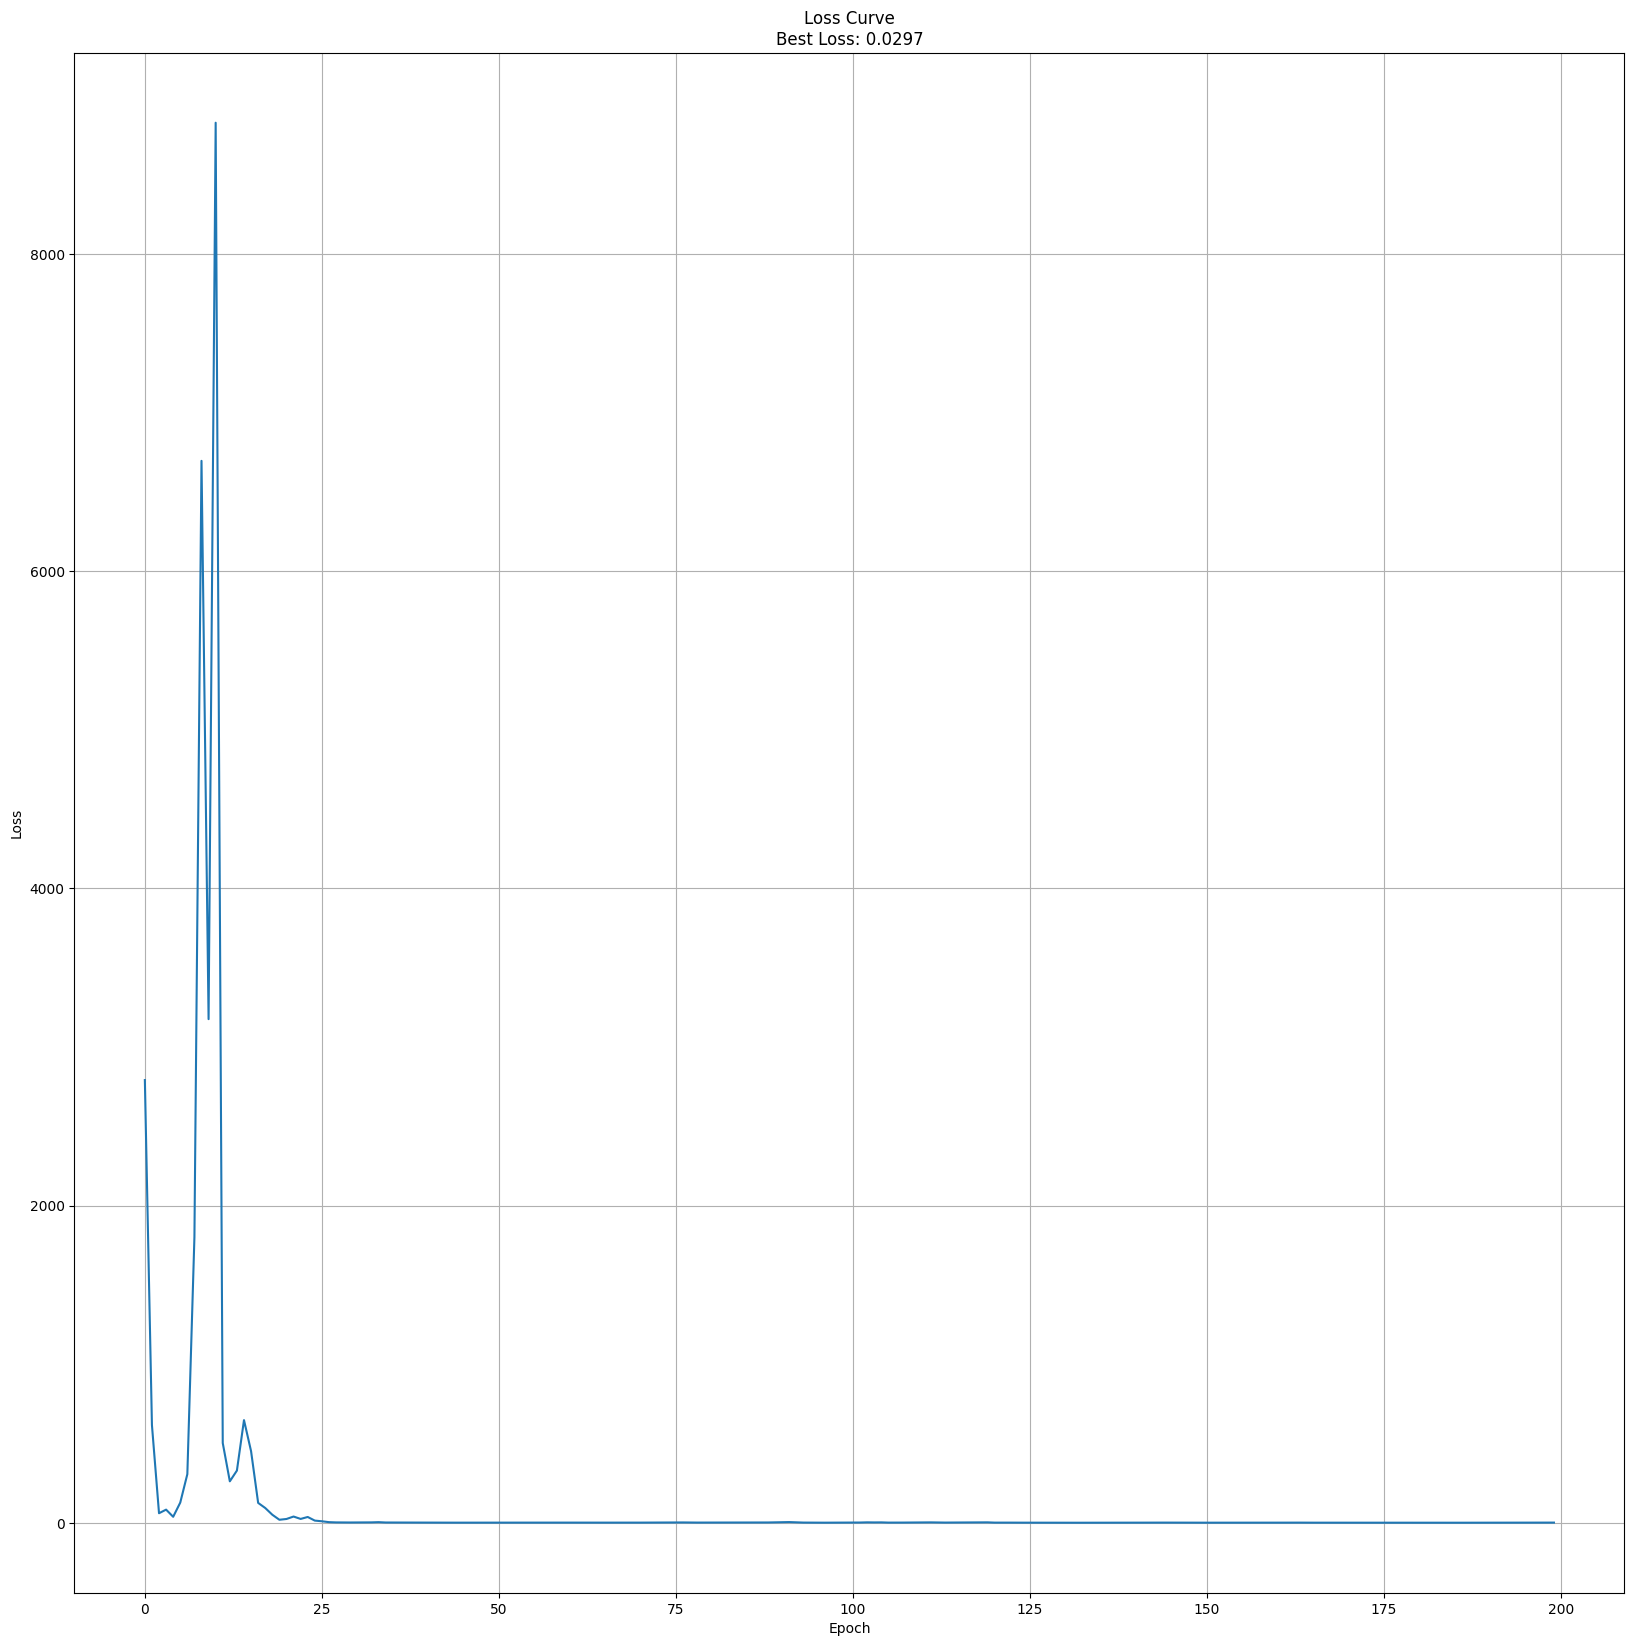

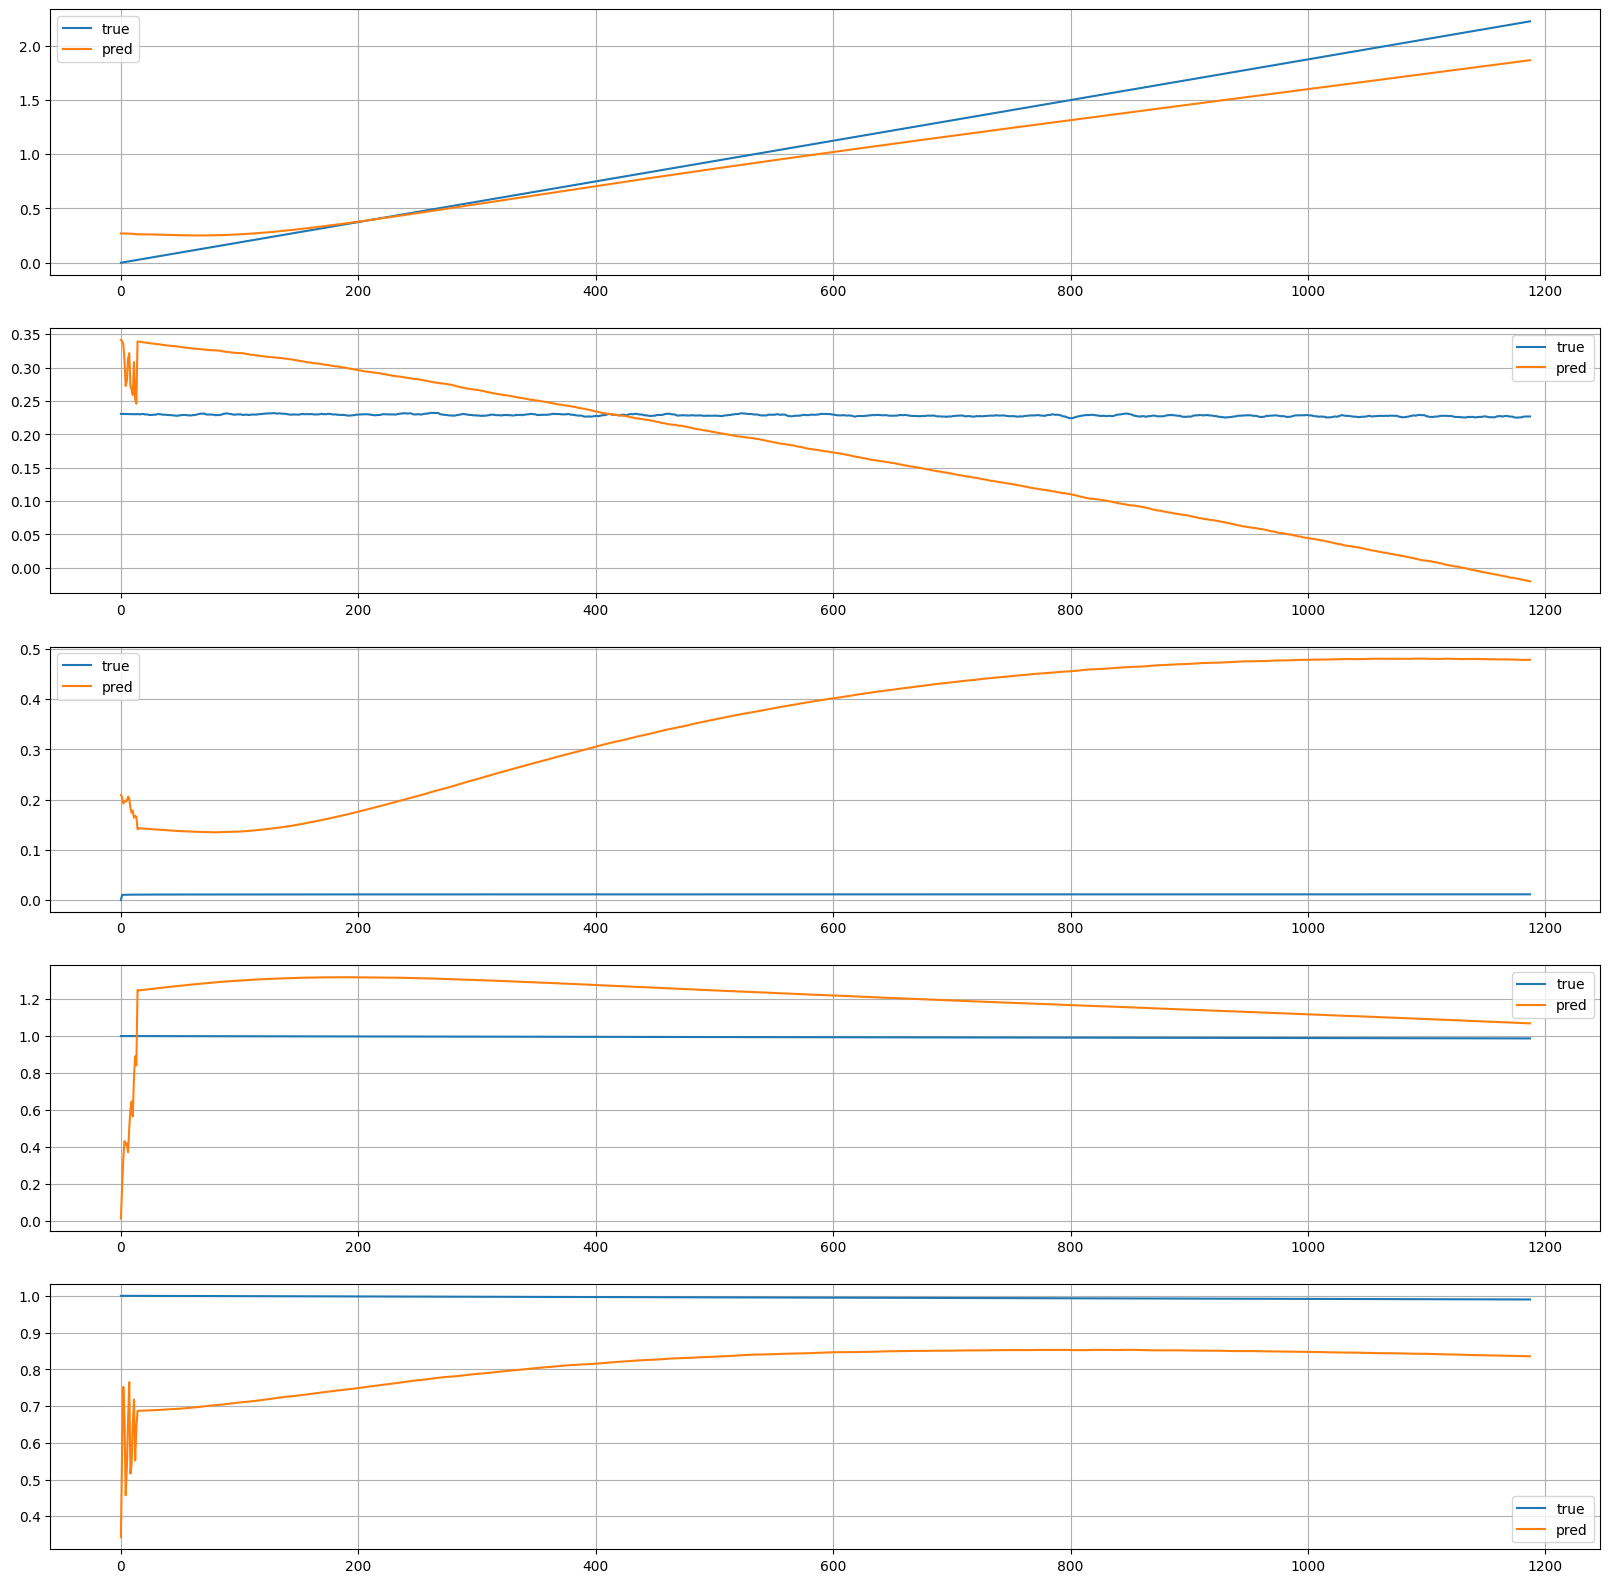

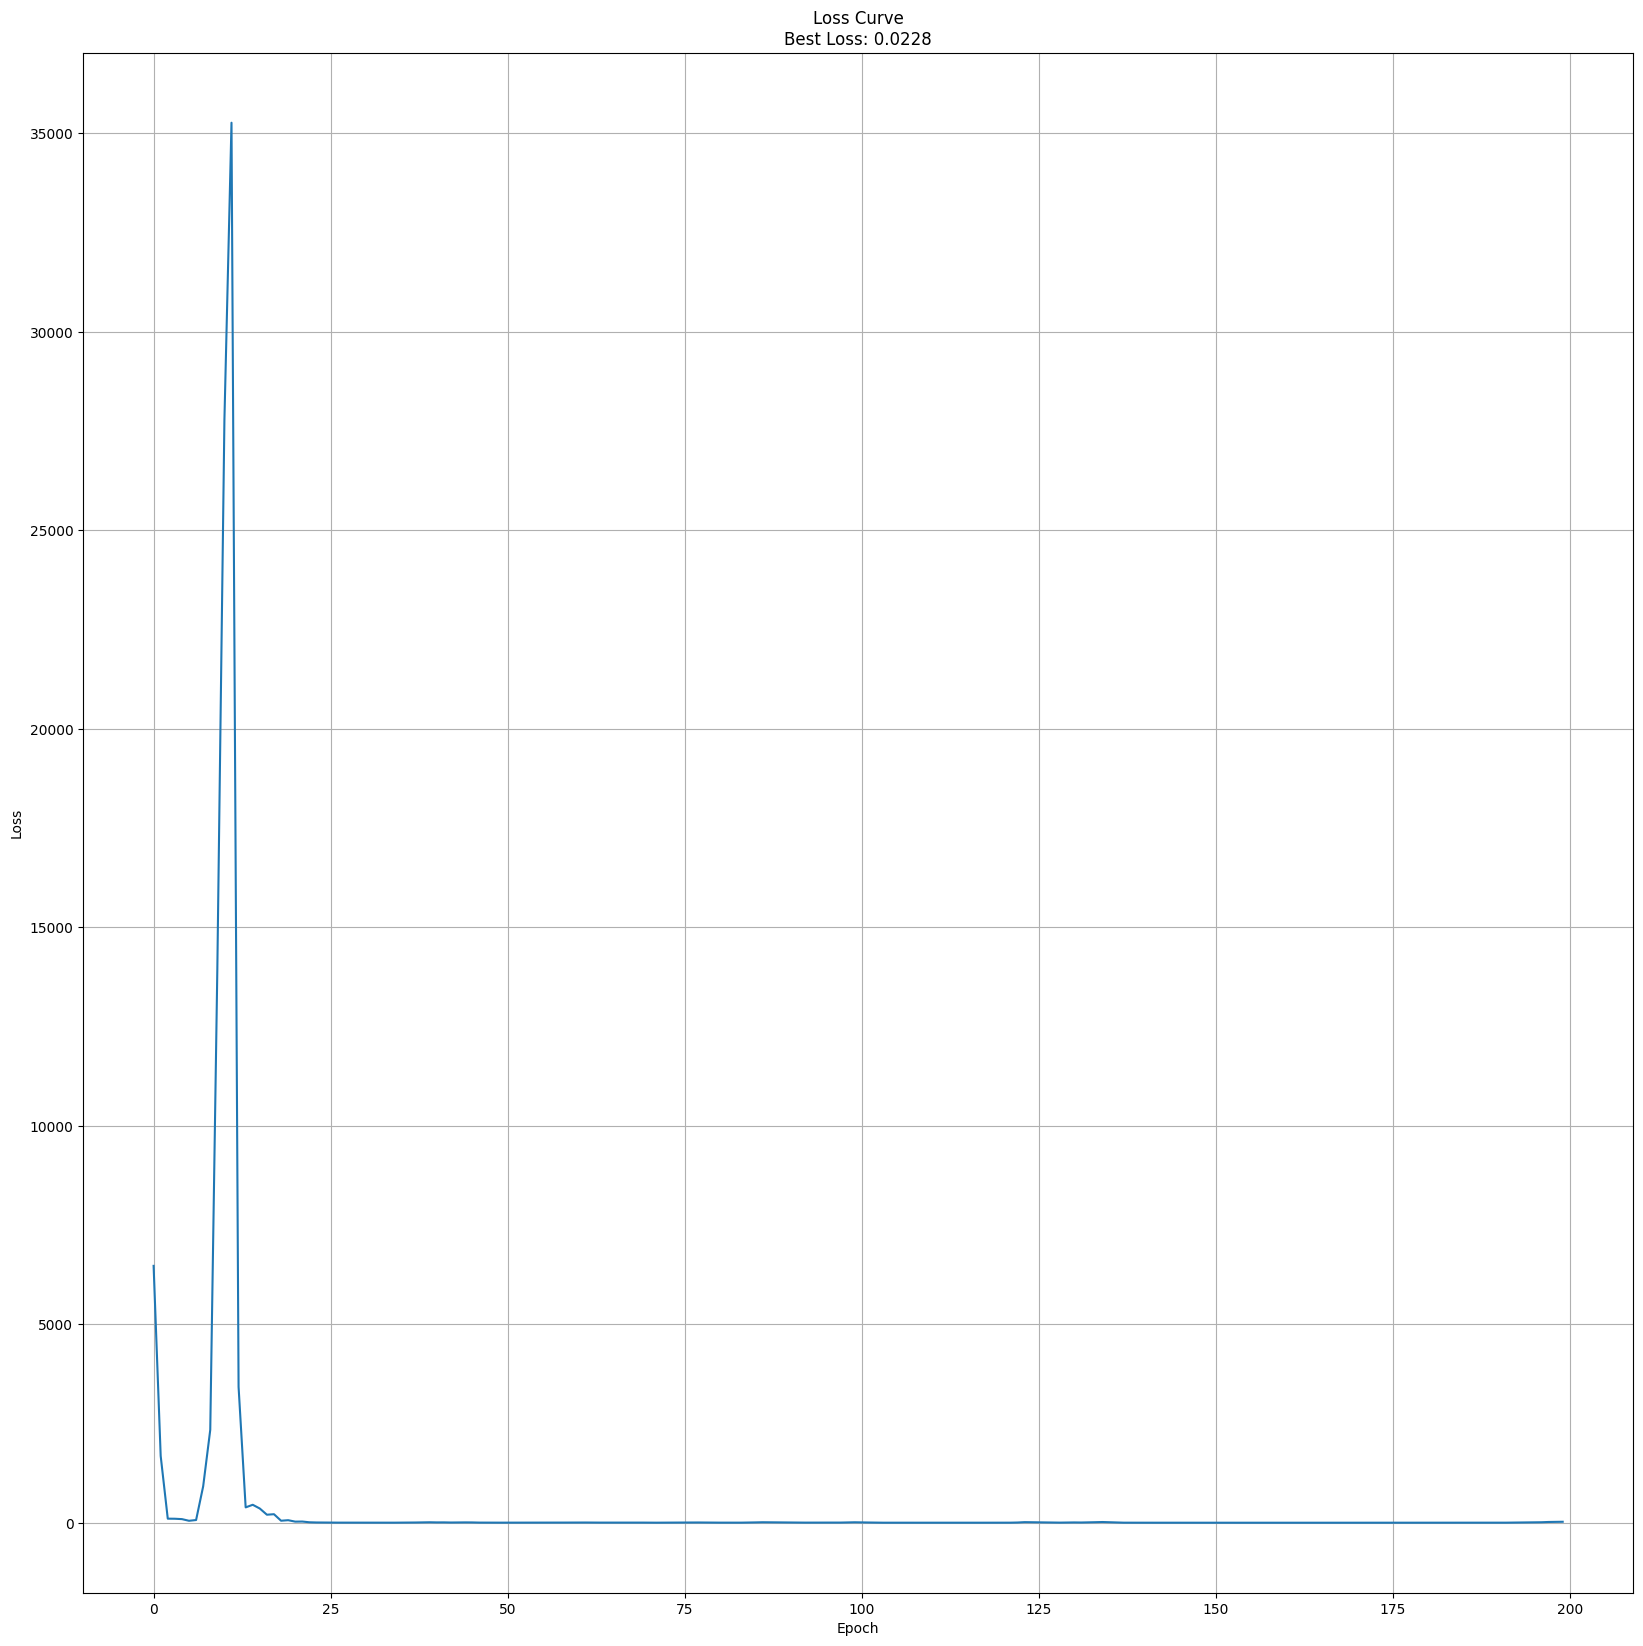

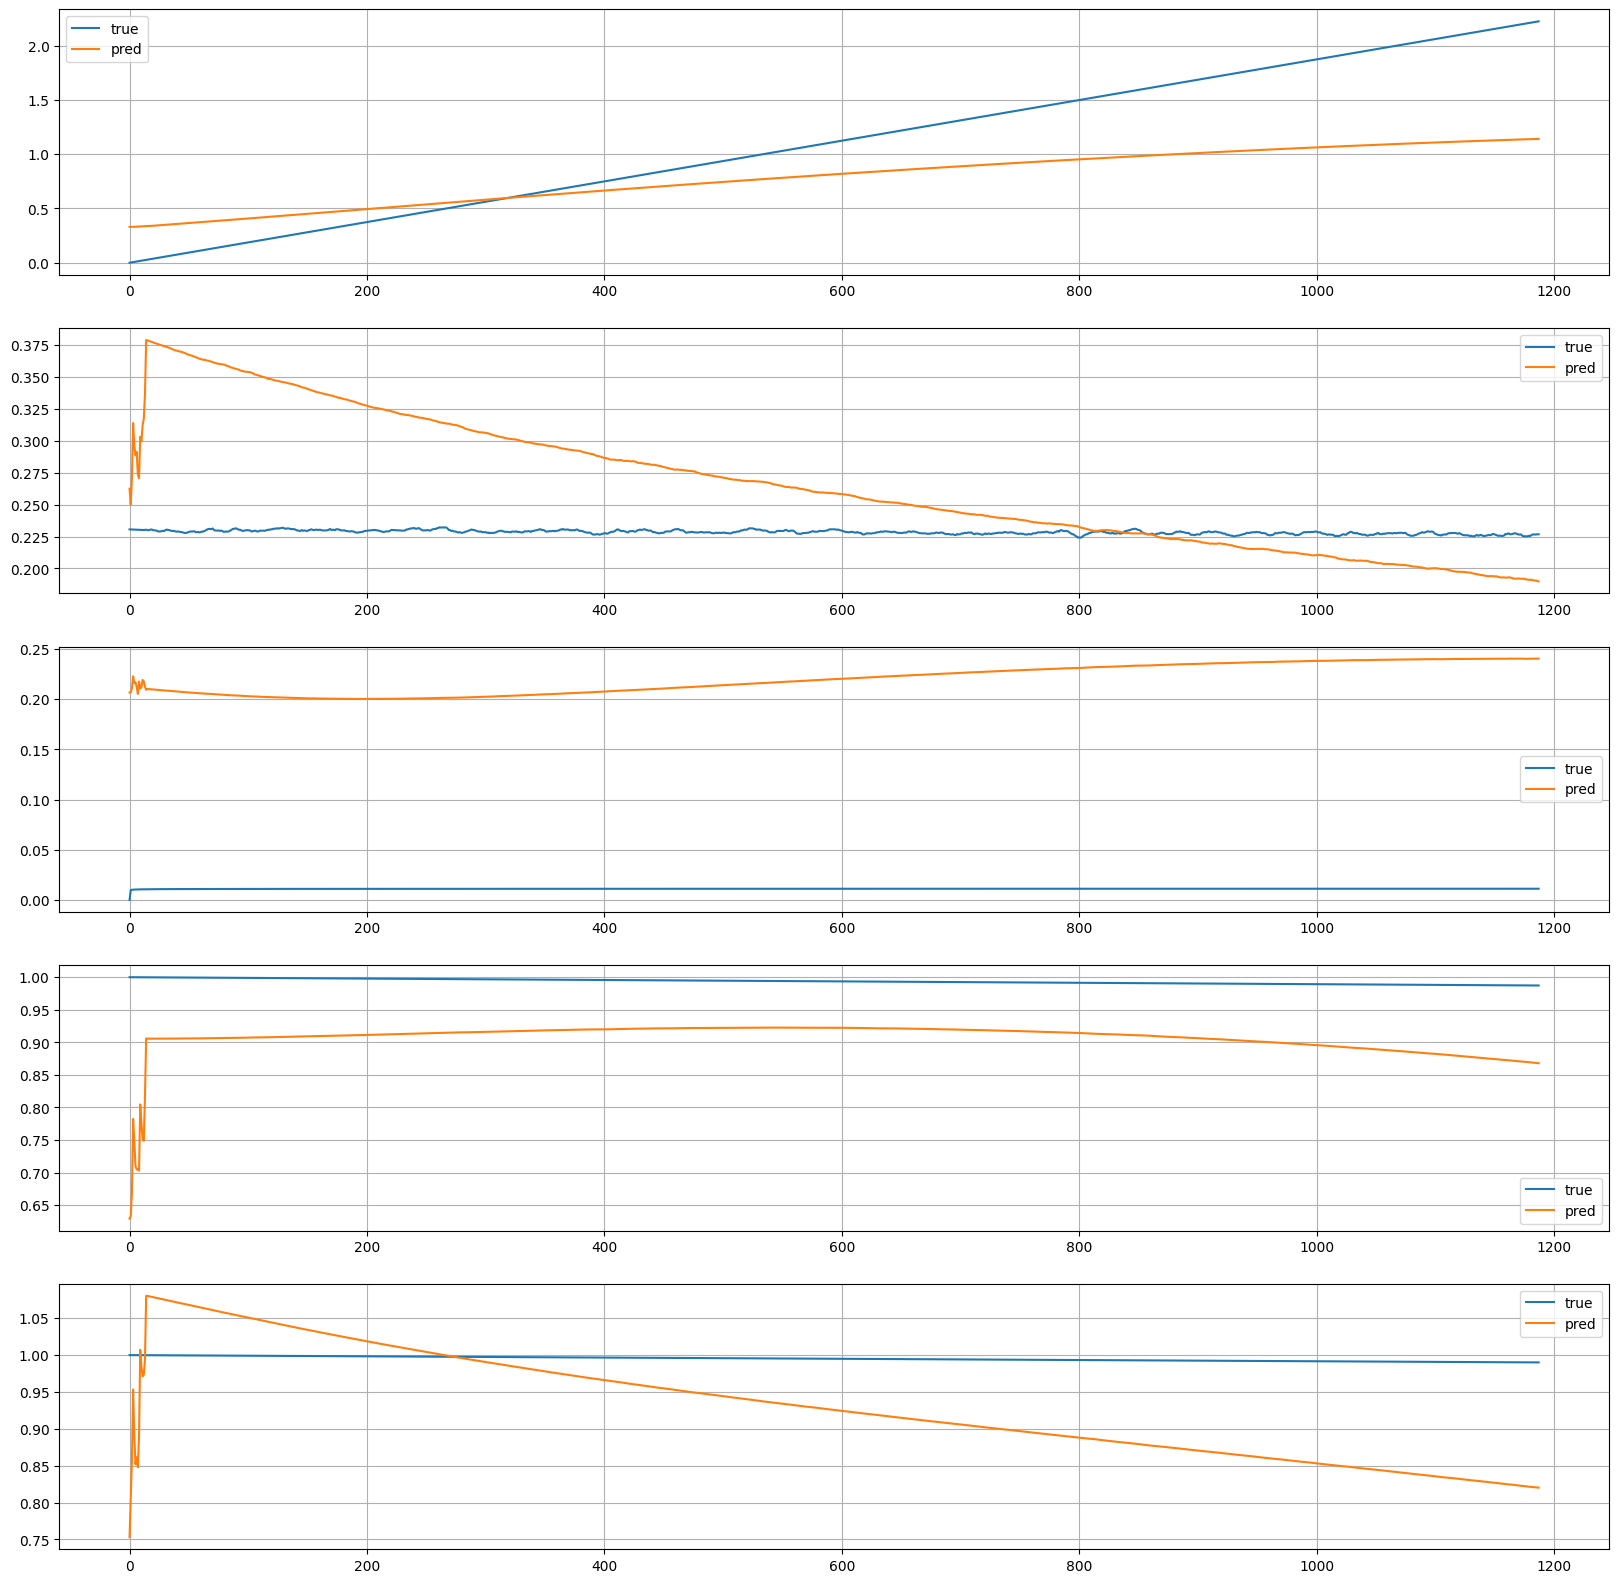

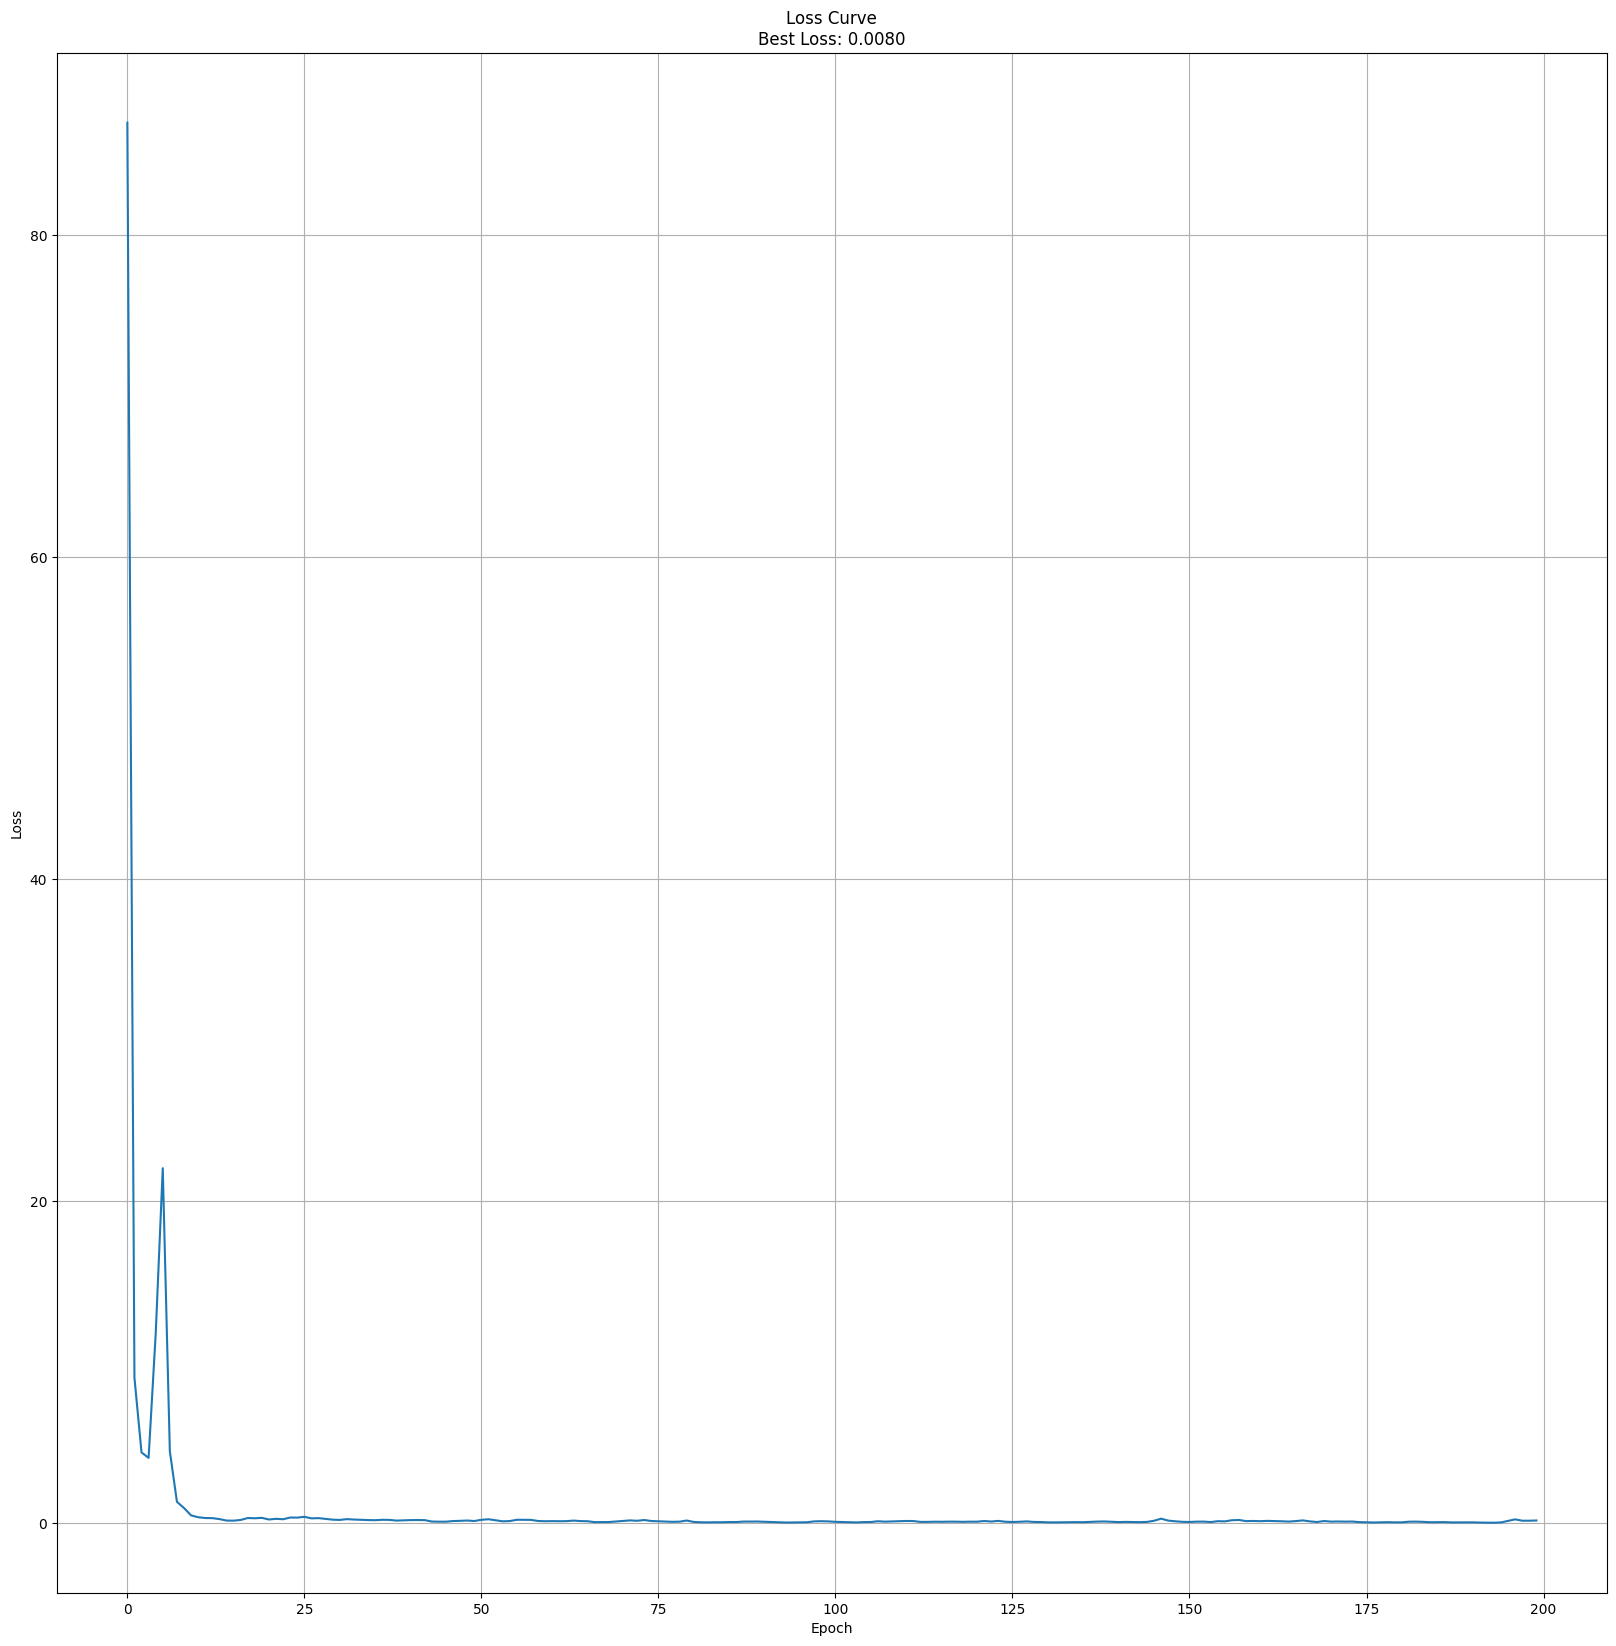

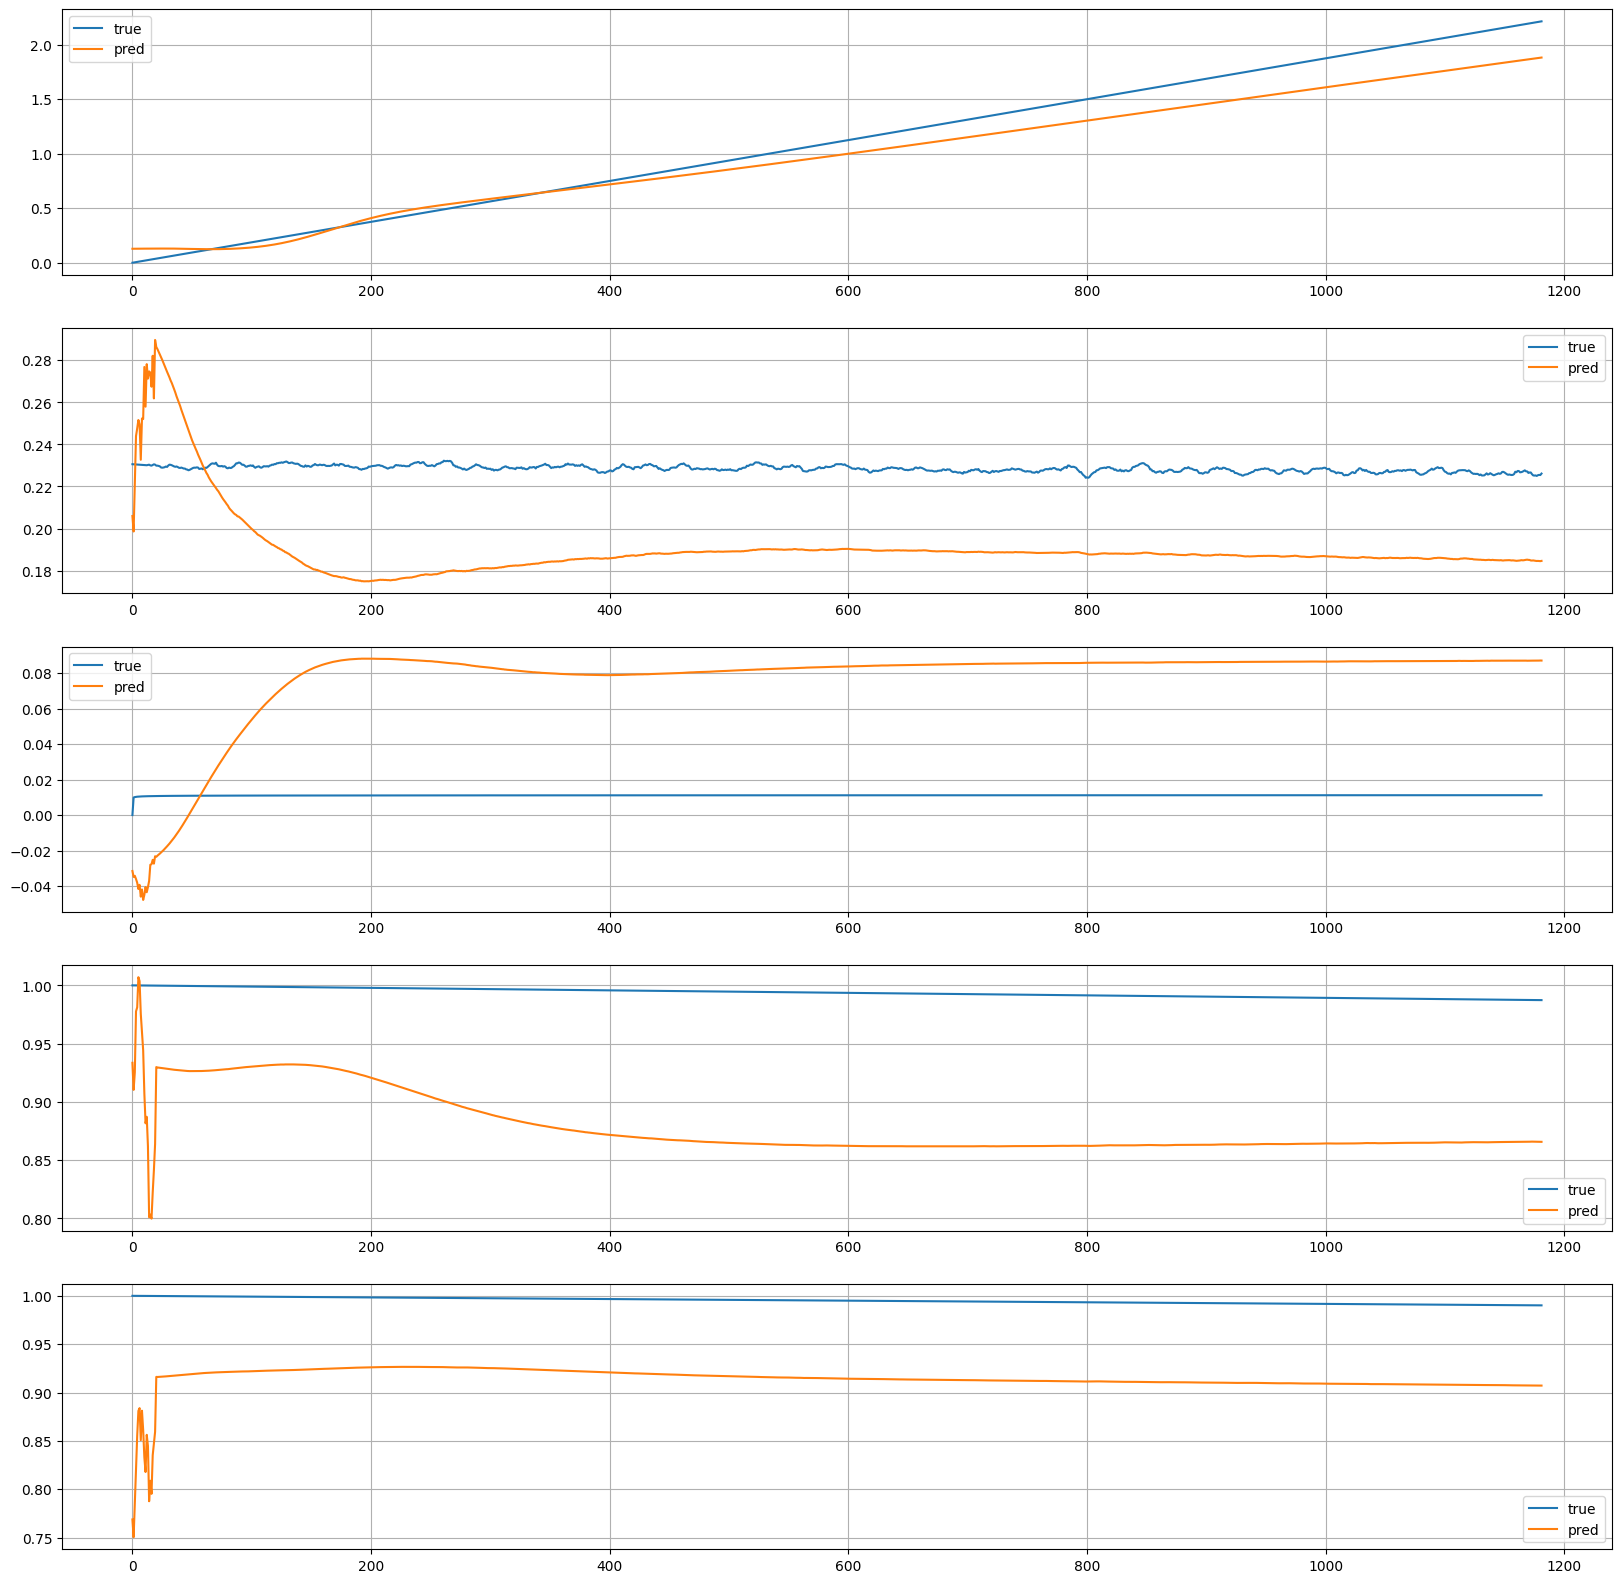

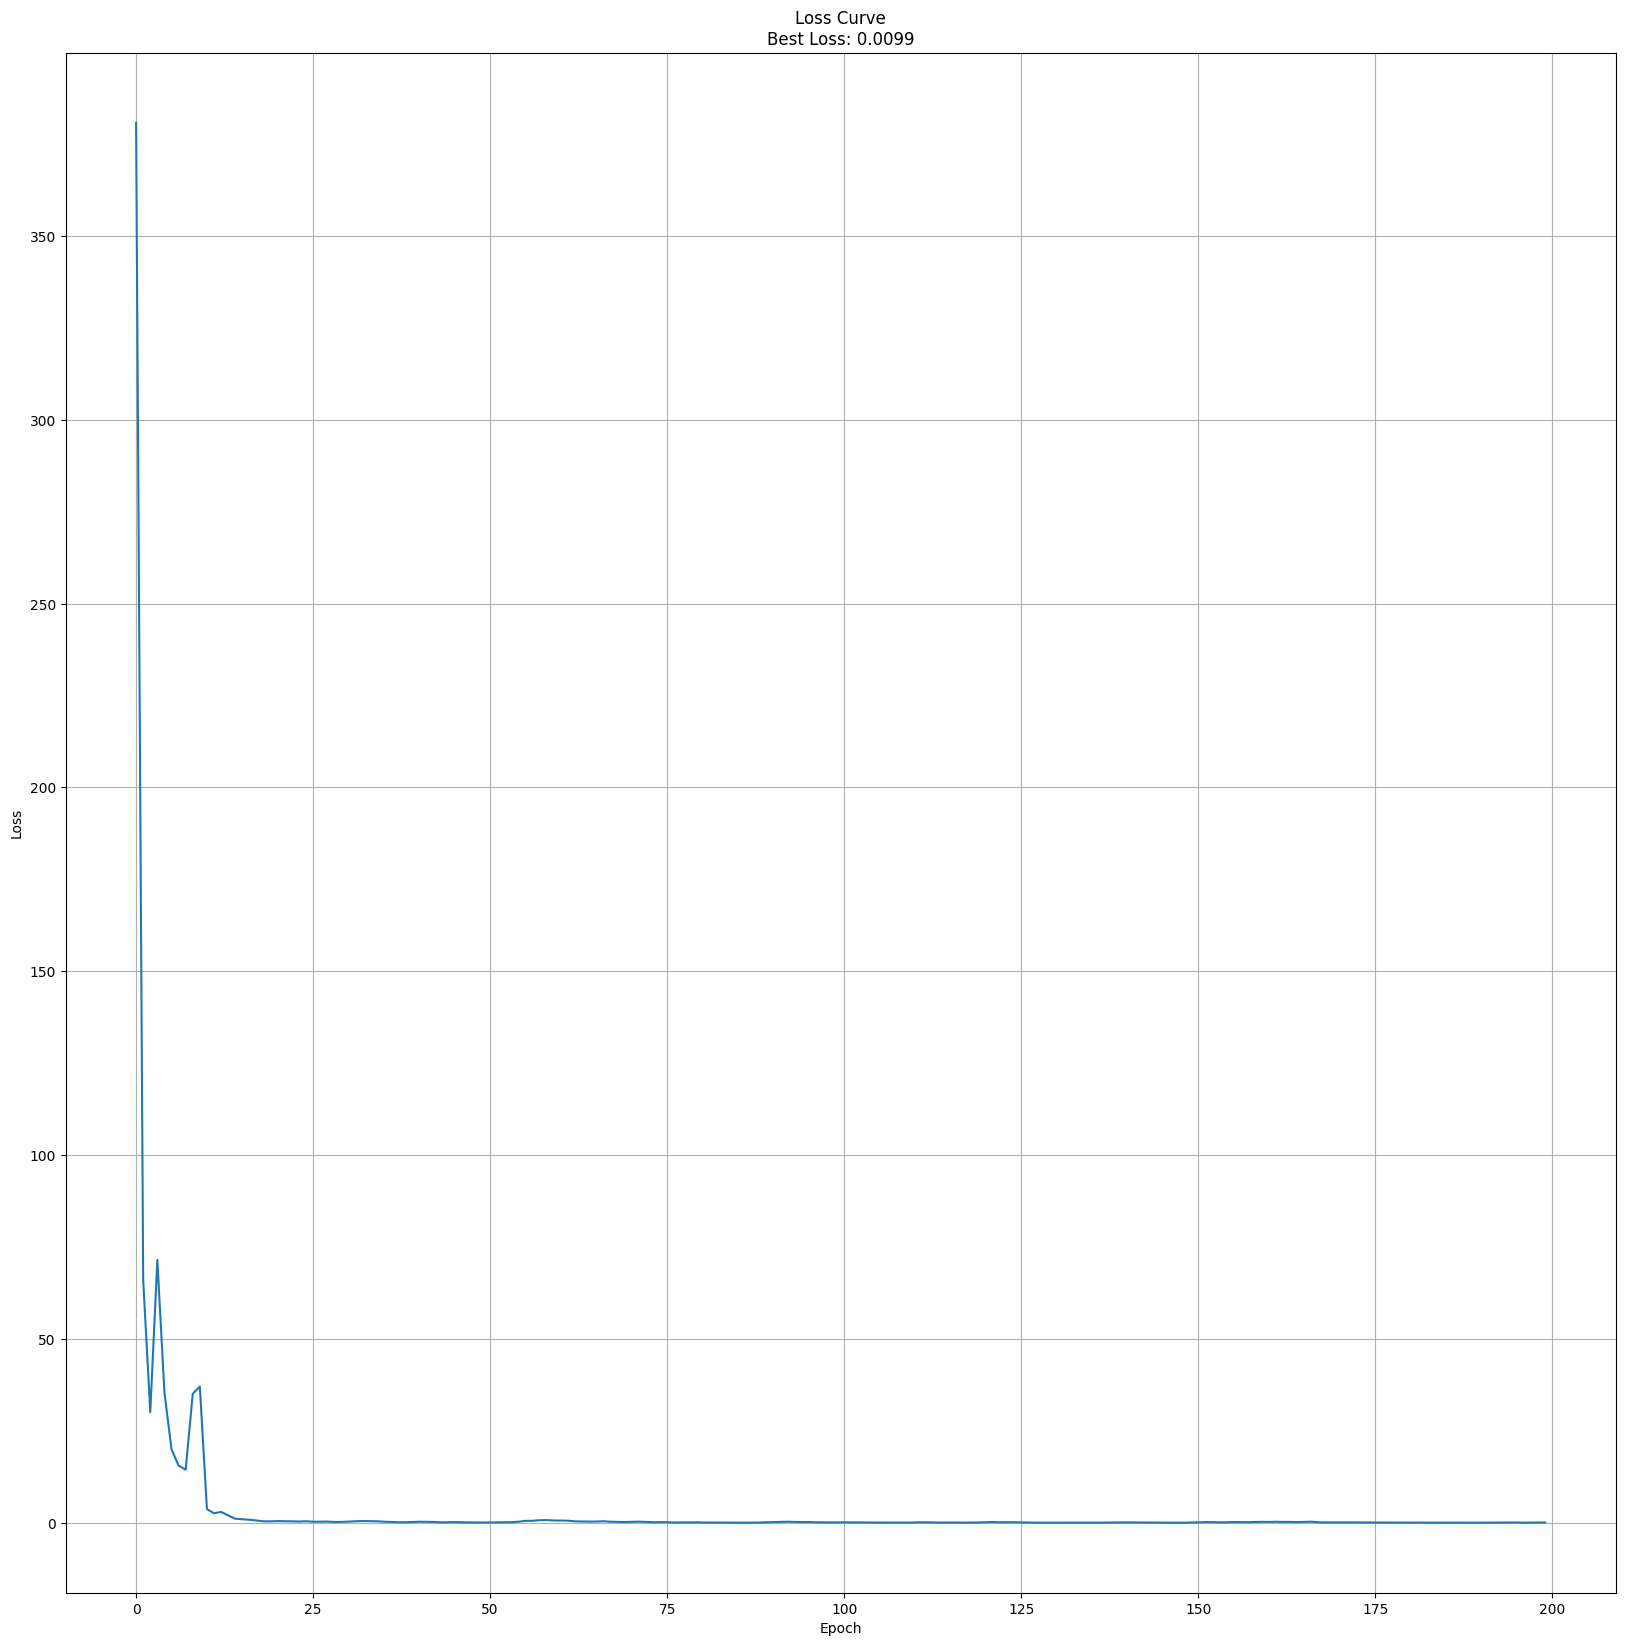

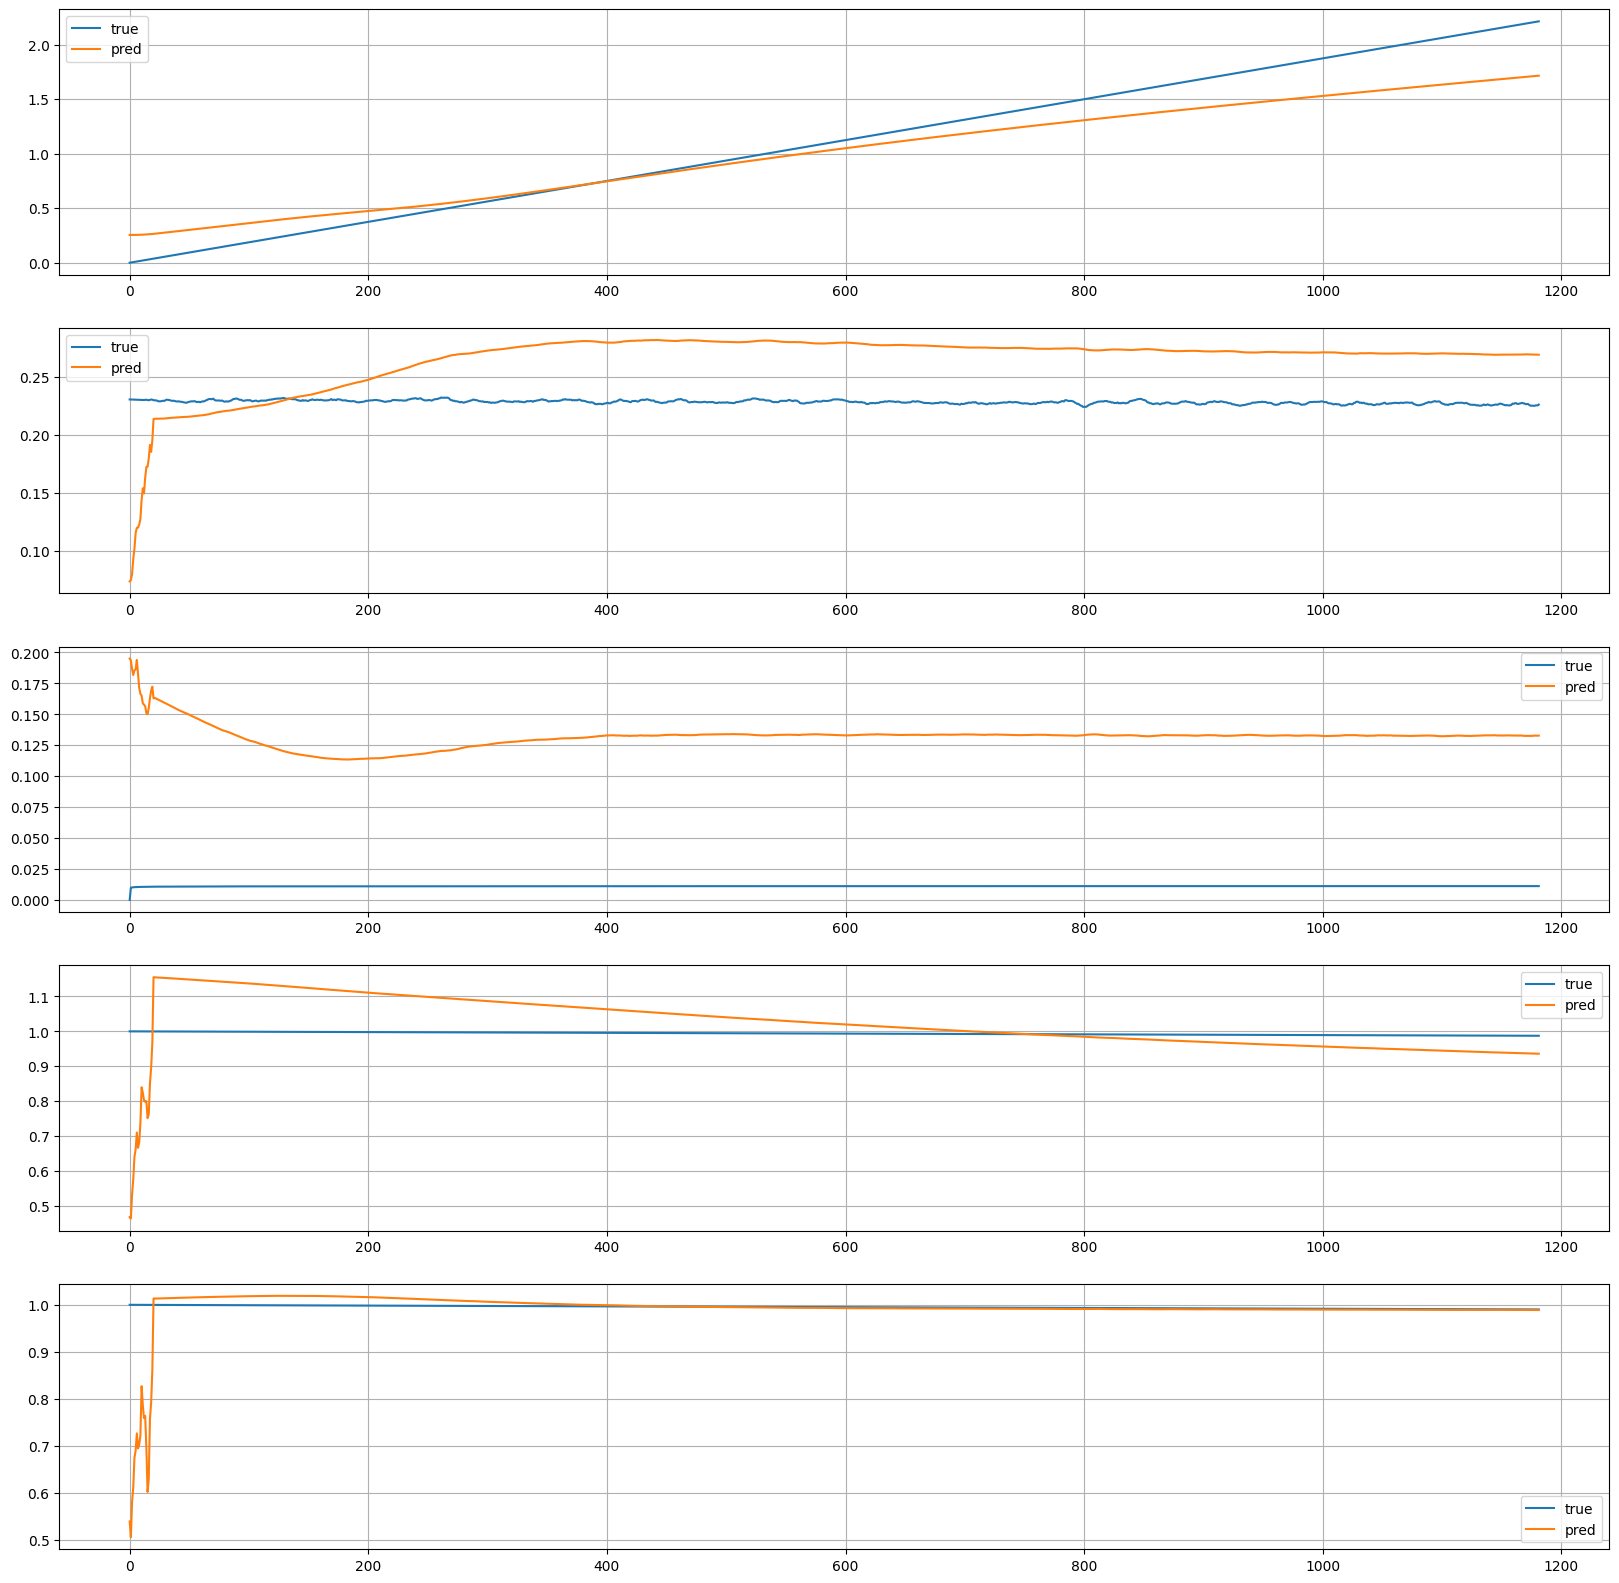

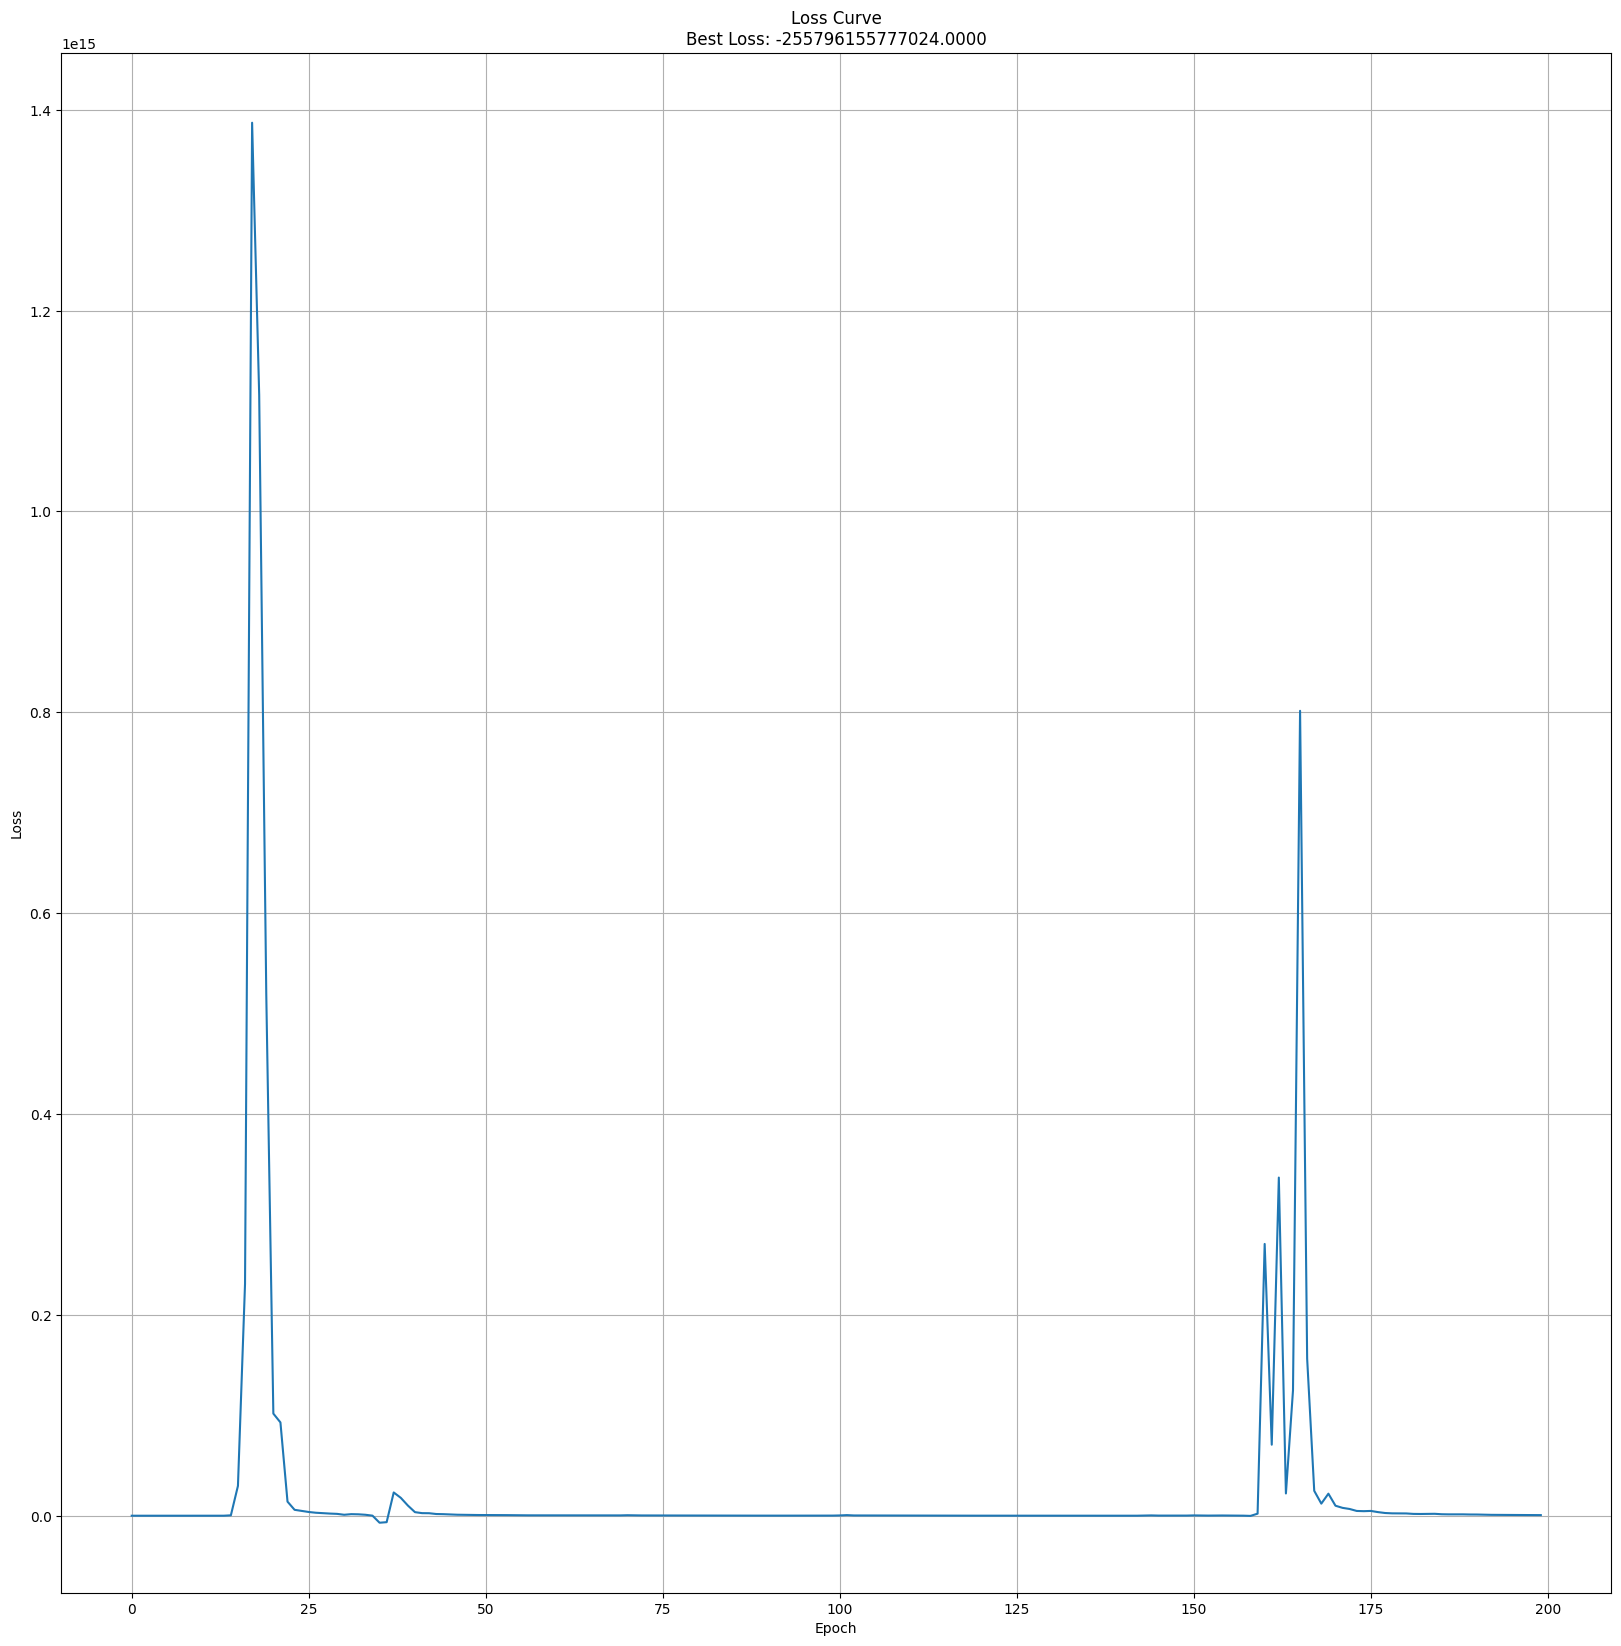

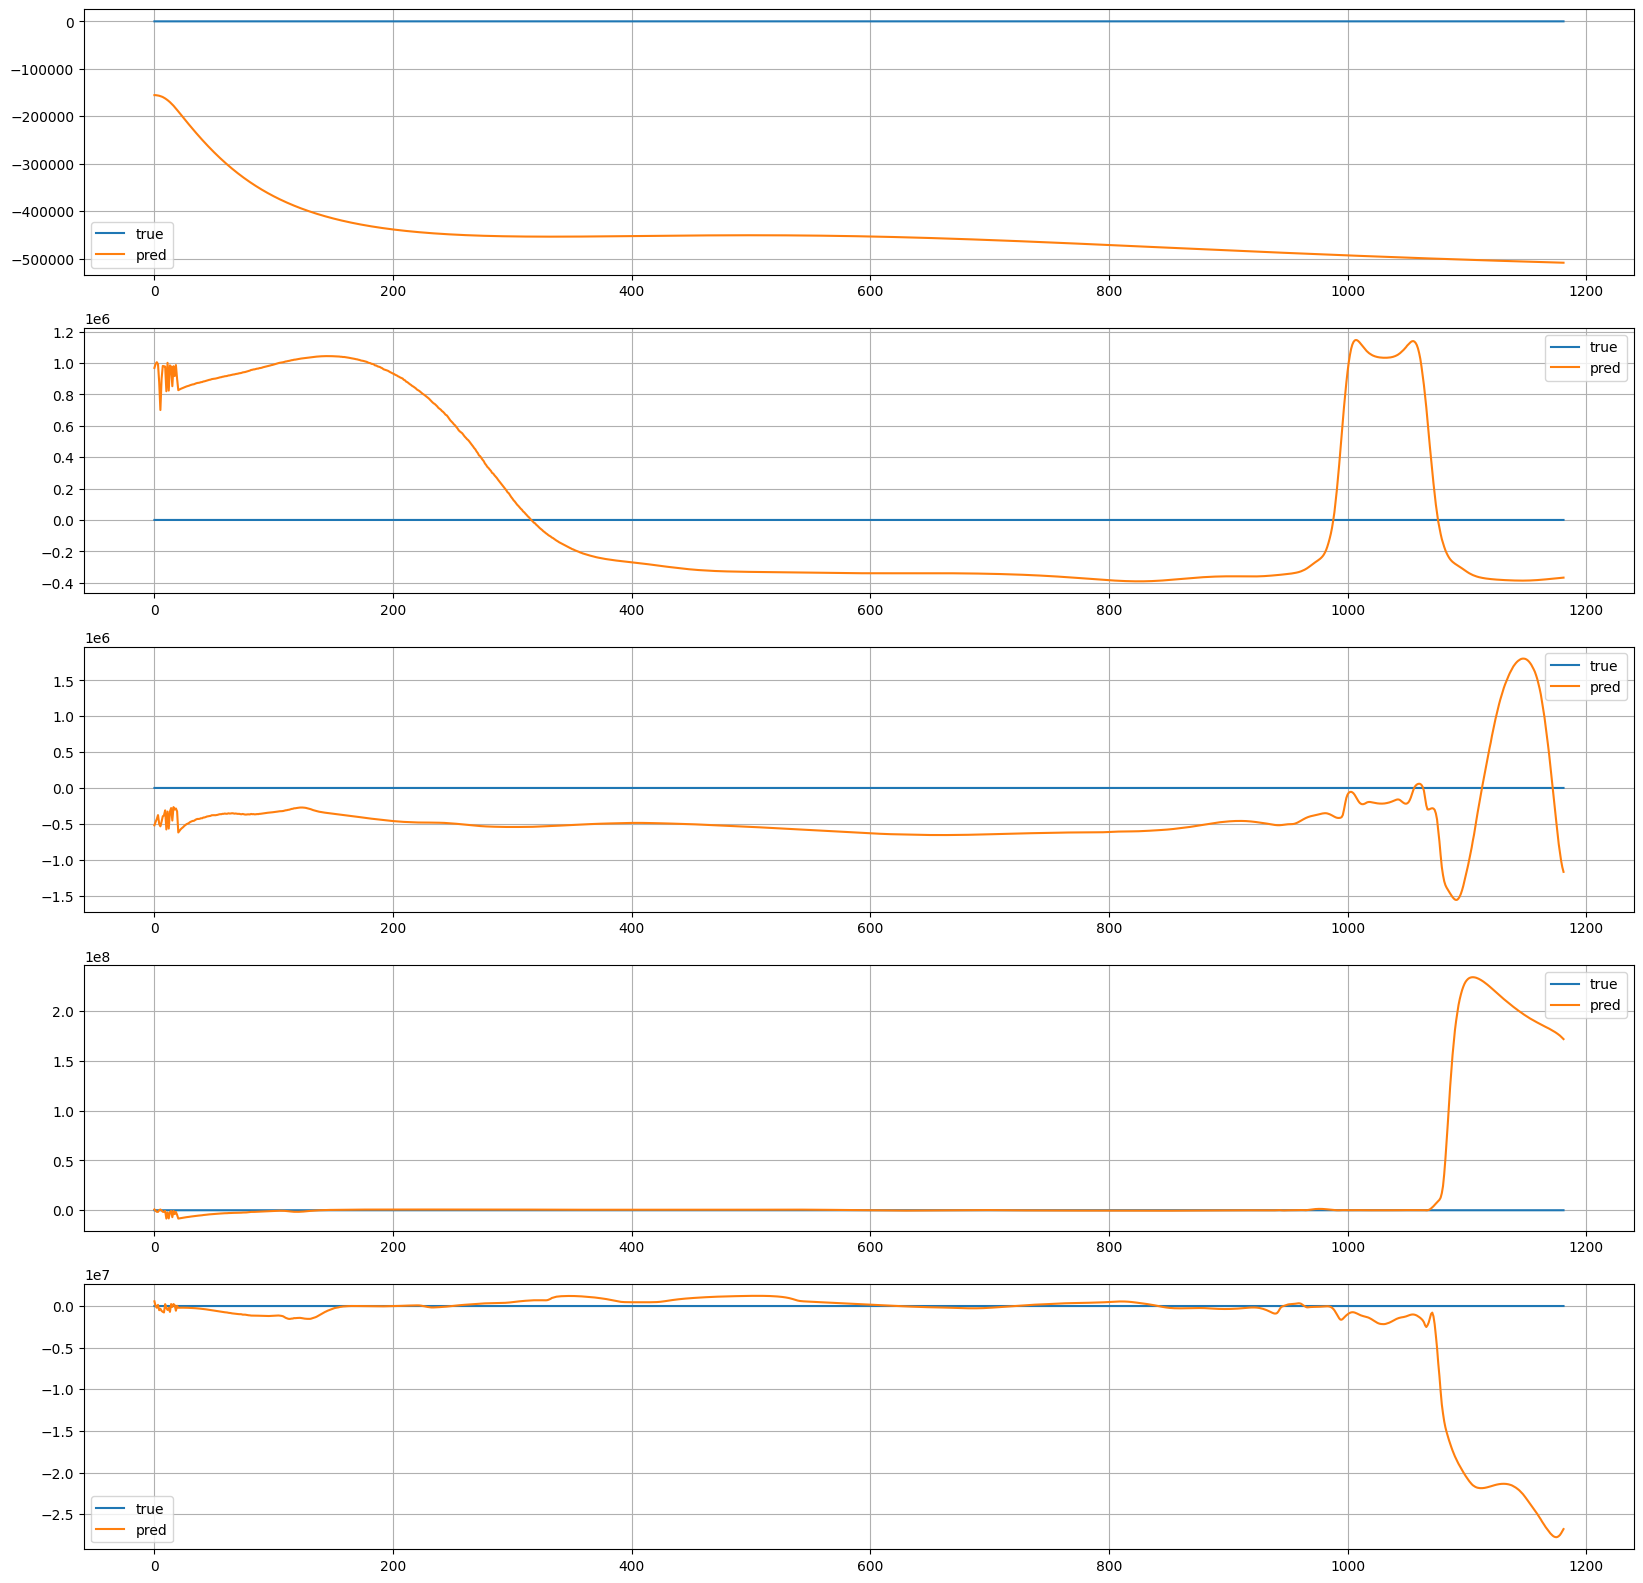

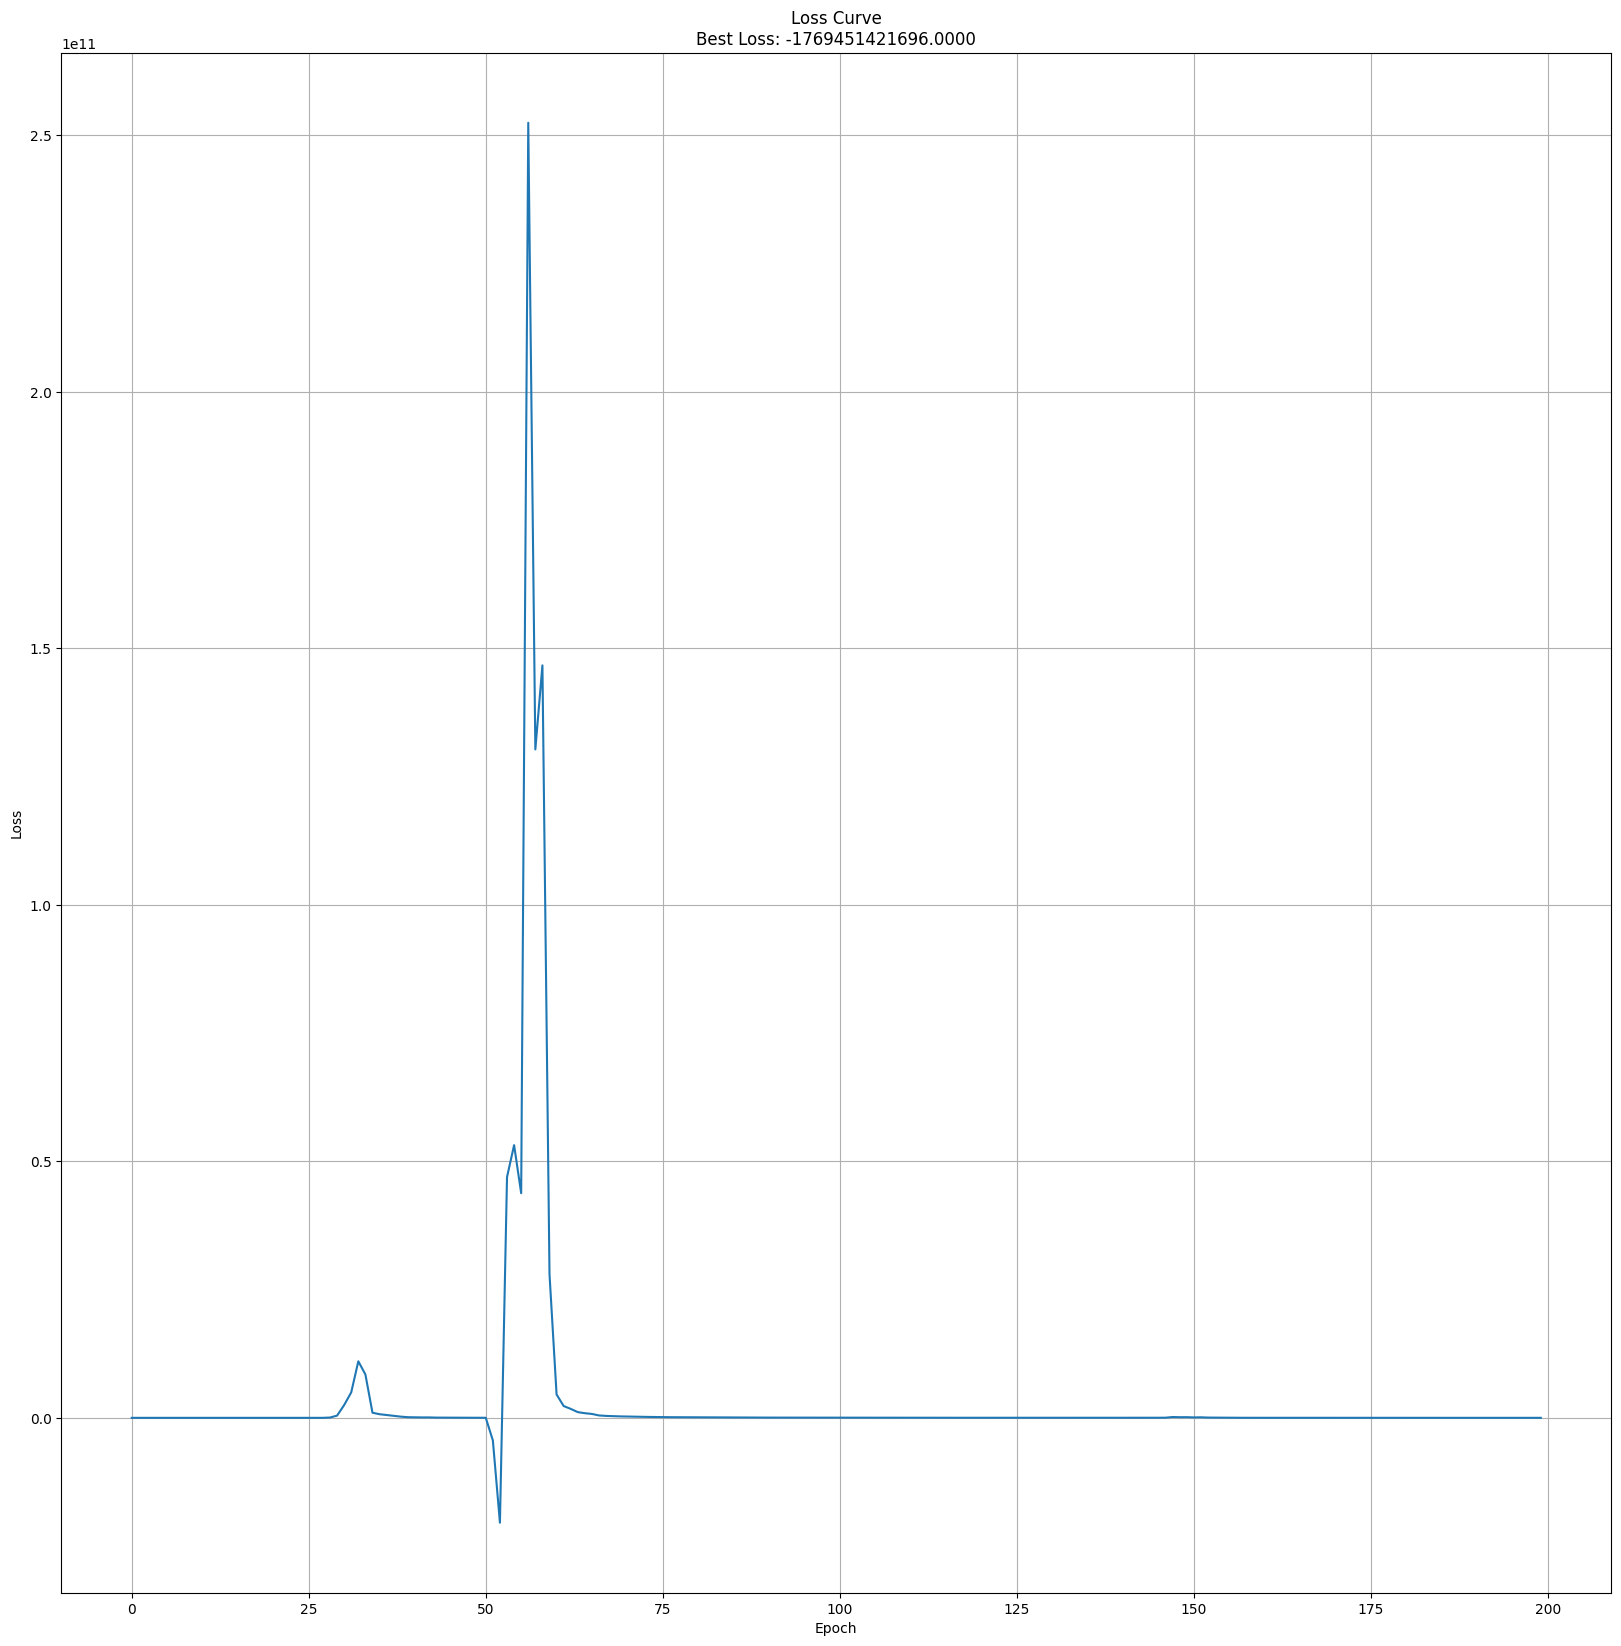

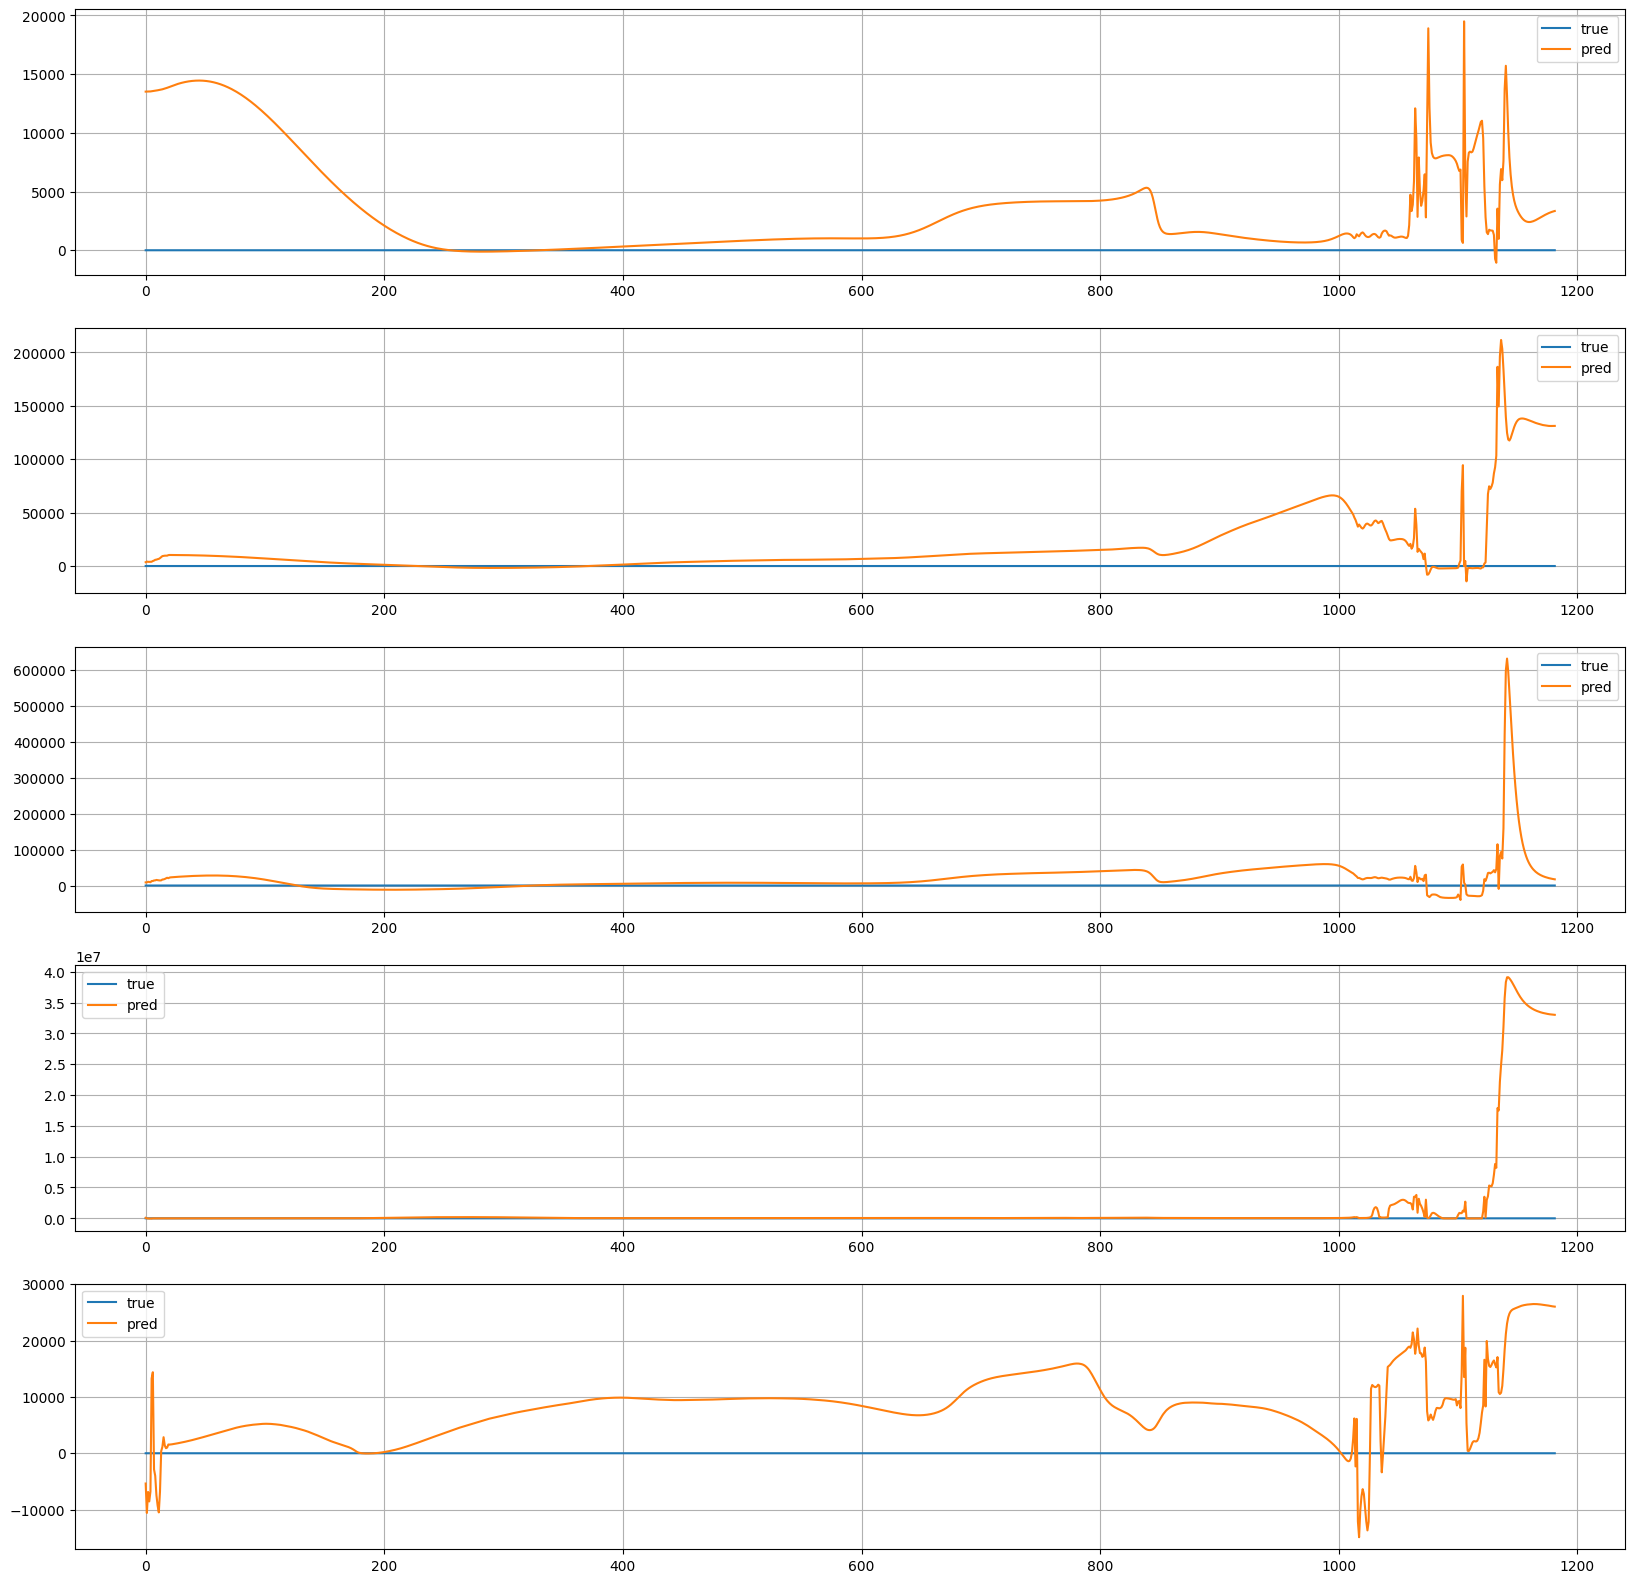

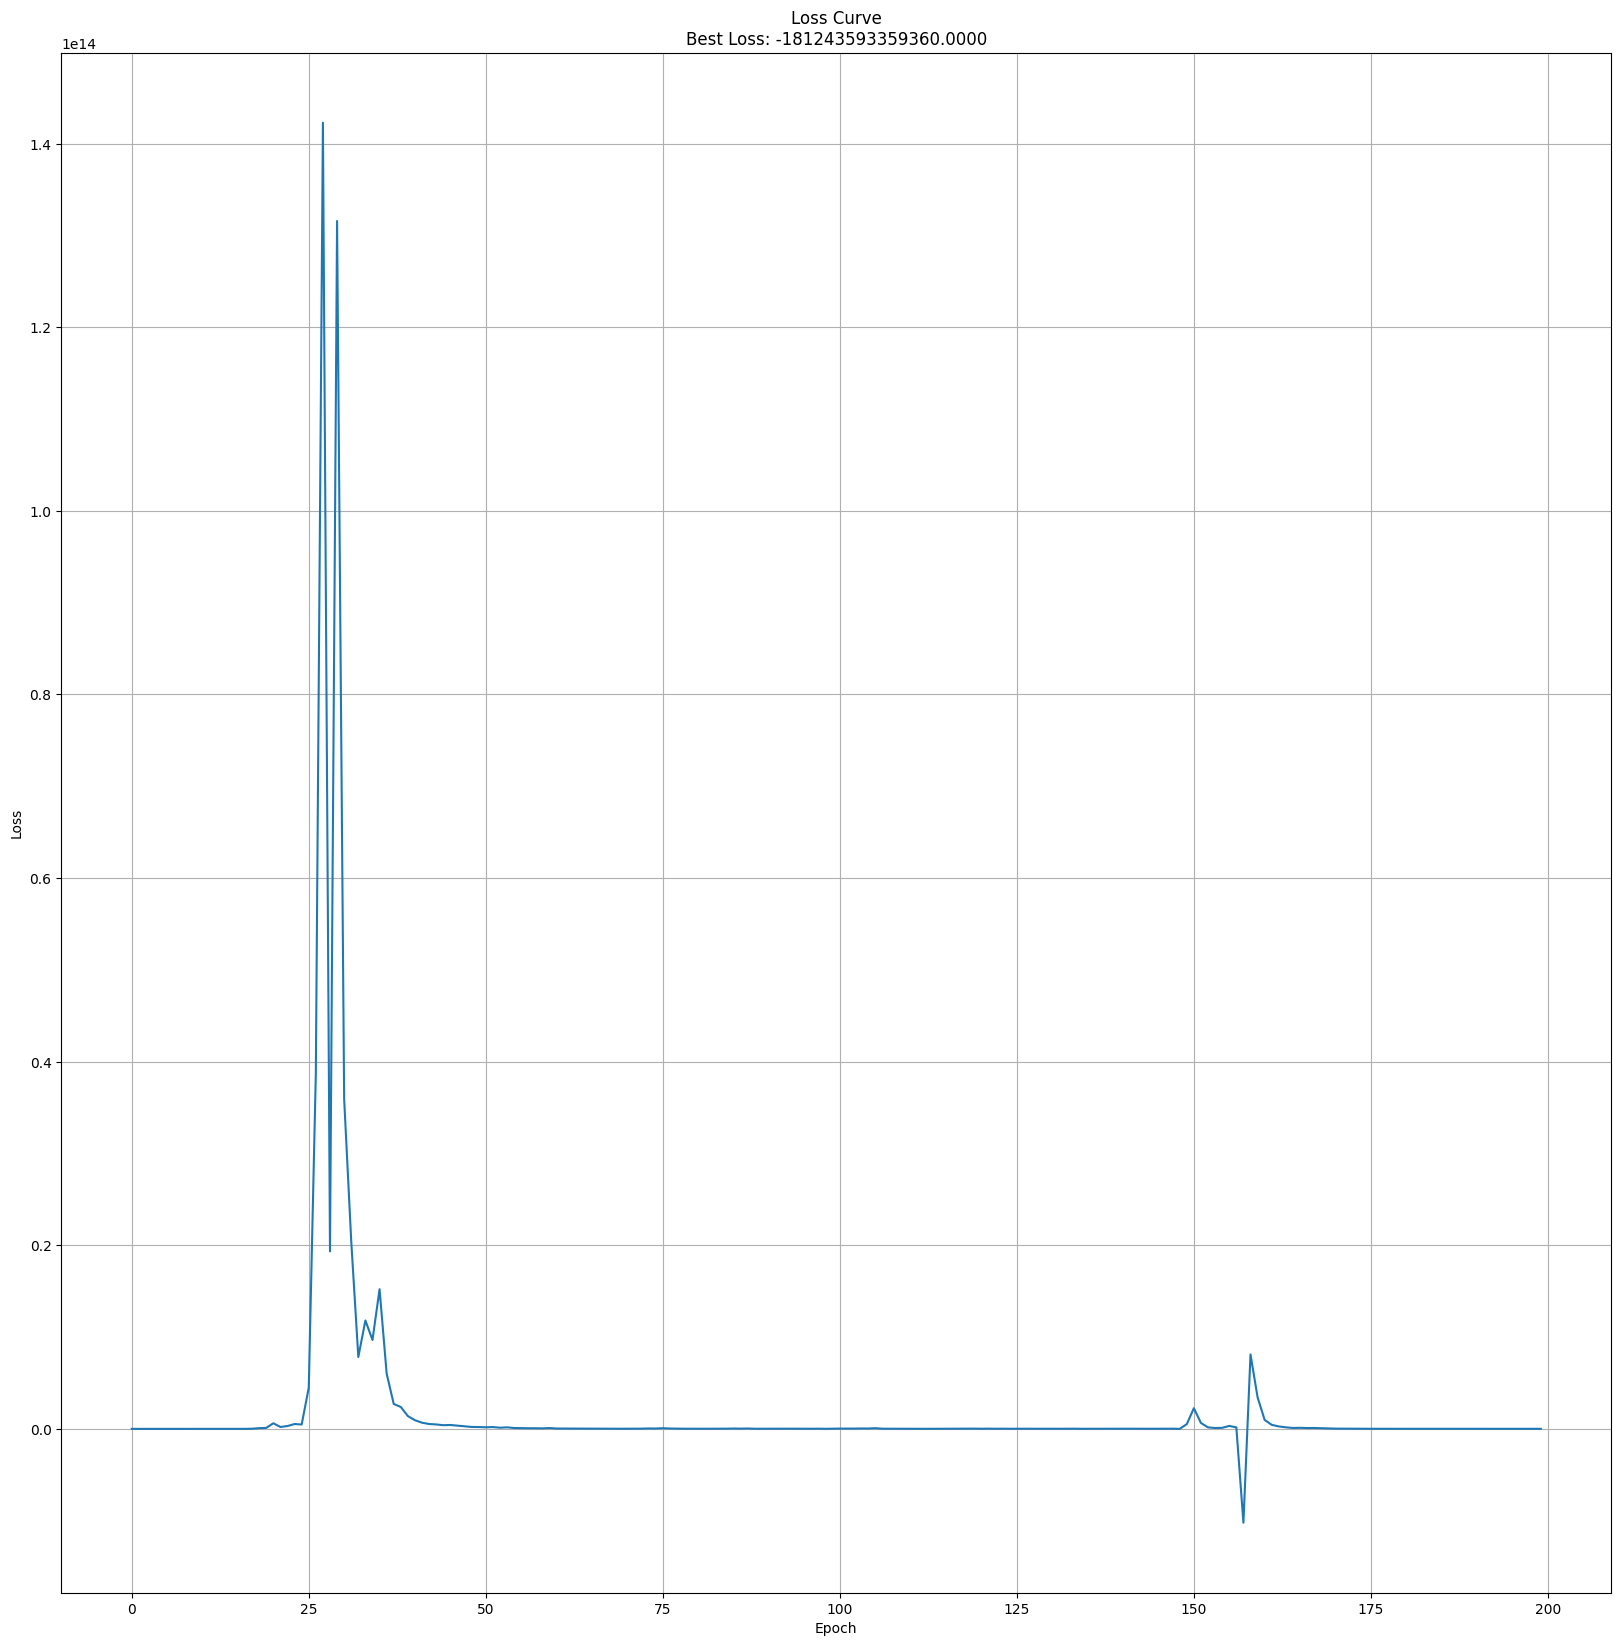

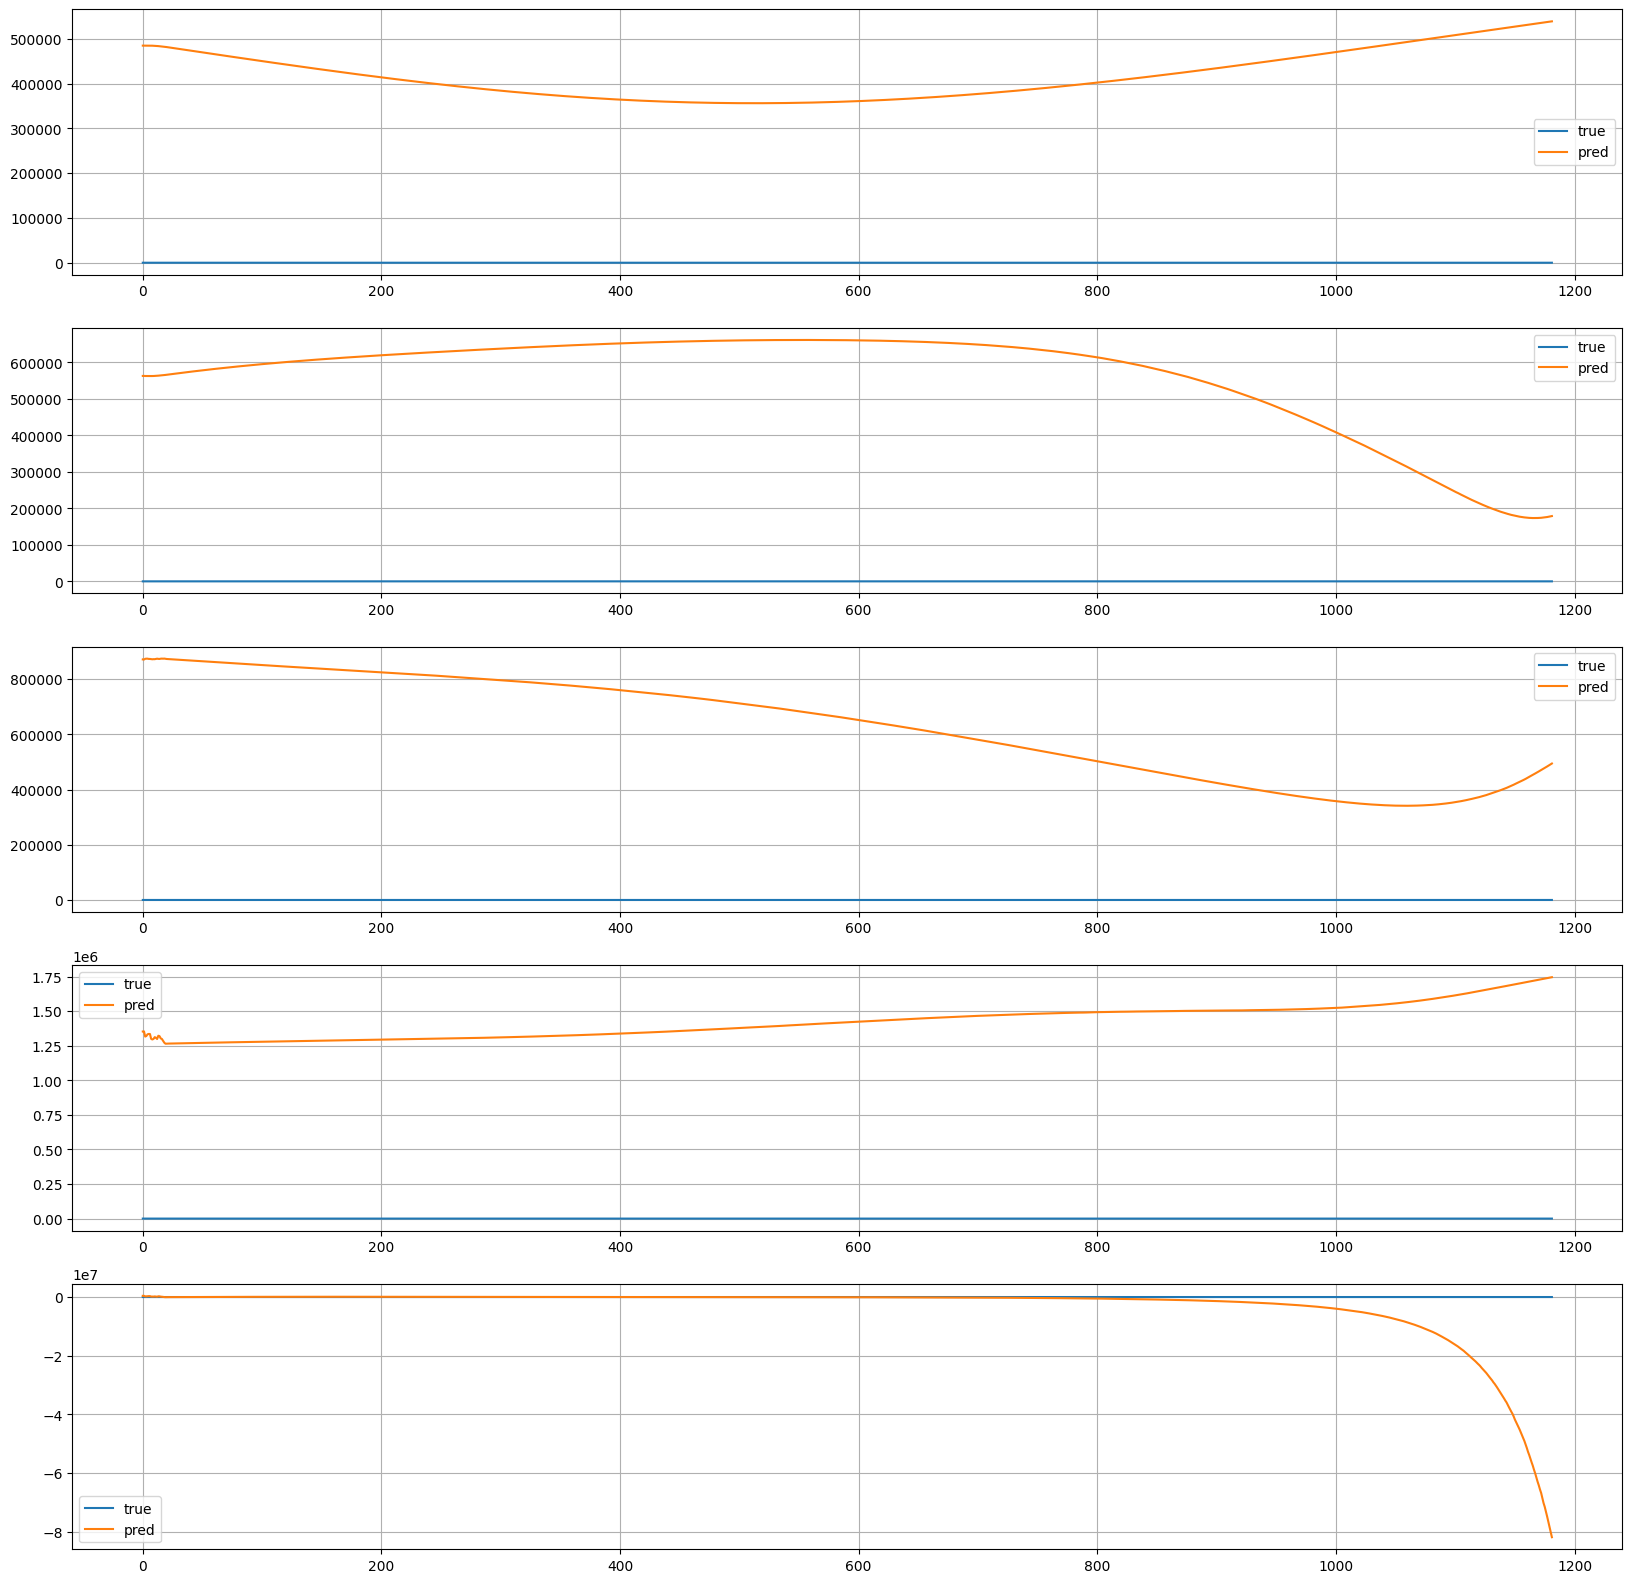

In [88]:
for params in mpg.grid:
    d = params['d_model']
    l = params['n_layers']
    savedir = f'neuro/models/v4/d{d}_l{l}_ksmoothed'
    mmb = MyMamba(MambaConfig(d_model=d, n_layers=l))
    hist = mmb.fit(prepared_data, epochs=200, batch_size=256, savedir=savedir)
    mmb.load_state_dict(torch.load(os.path.join(savedir, 'best.pt'), weights_only=True))
    mmb.test(scaled[0], contexts[0], savedir=savedir)

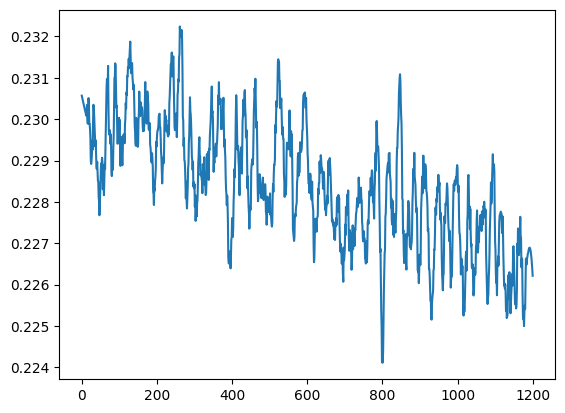

In [89]:
plt.plot(scaled[0, :, 1])

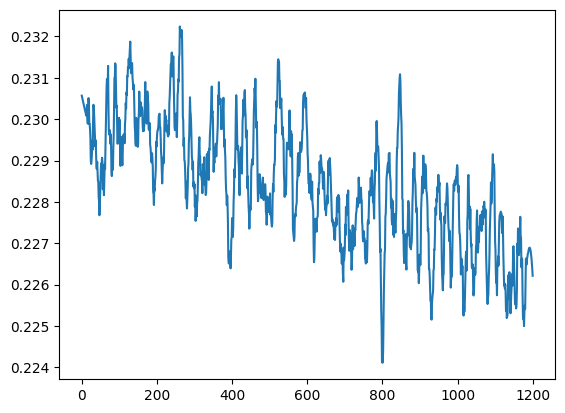

In [90]:
plt.plot(test_dataset.data[:, 0])

In [474]:
test_dataset[0]

(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.18075754,
         0.18772321, 0.17952671, 0.17866127, 0.18933252, 0.1899267 ,
         0.19253217],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.64965878, 0.67220401, 0.68469367, 0.69230238, 0.69678368,
         0.70144968],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.        ,
         0.9996158 , 0.99922895, 0.99884385, 0.99845743, 0.99807103,
         0.99768534],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.        ,
         0.99963681, 0.99928059, 0.99891693, 0.9985472 , 0.99818758,
         0.99782252]]),
 array([[0.19253217, 0.18415798, 0.18271002, 0.1799055 , 0.18598783,
         0.18

In [91]:
models_root = 'neuro/models/v4'
os.listdir(models_root)

['d6_l12_ksmoothed',
 'd6_l24_ksmoothed',
 'd6_l48_ksmoothed',
 'd6_l64_ksmoothed',
 'd6_l96_ksmoothed',
 'd8_l12_ksmoothed',
 'd8_l24_ksmoothed',
 'd8_l48_ksmoothed',
 'd8_l64_ksmoothed',
 'd8_l96_ksmoothed',
 'd14_l12_ksmoothed',
 'd14_l24_ksmoothed',
 'd14_l48_ksmoothed',
 'd14_l64_ksmoothed',
 'd14_l96_ksmoothed',
 'd20_l12_ksmoothed',
 'd20_l24_ksmoothed',
 'd20_l48_ksmoothed',
 'd20_l64_ksmoothed',
 'd20_l96_ksmoothed']

In [98]:
ds, ls = [], []
for model in os.listdir(models_root):
    _d, _l, *_ = model.split('_')
    _d = _d.replace('d', '')
    _l = _l.replace('l', '')
    ds.append(int(_d))
    ls.append(int(_l))
ds = list(set(ds))
ls = list(set(ls))
ds.sort()
ls.sort()

In [99]:
ds, ls

([6, 8, 14, 20], [12, 24, 48, 64, 96])

In [100]:
maxs, means = np.zeros((len(ds), len(ls))), np.zeros((len(ds), len(ls)))
maxs.shape

(4, 5)

In [105]:
for i, d in enumerate(ds):
    for j, l in enumerate(ls):
        try:
            res = json.load(open(os.path.join(models_root, f'd{d}_l{l}_ksmoothed/testing_results.json')))
            _mean = res['testing_results']['mean_dif']*100
            _max = res['testing_results']['max_dif']*100
            _max = _max if _max < 100 else 100
            _mean = _mean if _mean < 100 else 100
            maxs[i, j] = _max
            means[i, j] = _mean
        except FileNotFoundError:
            print(f'Testing results for {d} / {l} not found.')

In [106]:
means

array([[  5.70962057,  10.07544249,   6.65954649,  13.4432286 ,
         45.90971172],
       [  6.94068447,  11.89622357,  12.38865182,   8.81547853,
        100.        ],
       [  9.55899283,   6.20515049,   8.33762214,  20.42582333,
          8.36536363],
       [  9.81420651,   3.55379842, 100.        , 100.        ,
        100.        ]])

In [107]:
maxs

array([[ 81.01406097,  15.61755985,  54.51013446,  77.26684809,
         85.66966057],
       [ 65.53767323,  68.74203682,  32.79556036,  27.30169594,
        100.        ],
       [ 15.79483151,  54.21742797,  33.64869654,  98.90038967,
         37.07439899],
       [ 24.96435046,  53.70295048, 100.        , 100.        ,
        100.        ]])

In [113]:
maxs.argsort()

array([[1, 2, 3, 0, 4],
       [3, 2, 0, 1, 4],
       [0, 2, 4, 1, 3],
       [0, 1, 2, 3, 4]])

In [114]:
means.argsort()

array([[0, 2, 1, 3, 4],
       [0, 3, 1, 2, 4],
       [1, 2, 4, 0, 3],
       [1, 0, 2, 3, 4]])

In [115]:
maxs.argsort() == means.argsort()

array([[False,  True, False, False,  True],
       [False, False, False, False,  True],
       [False,  True,  True, False,  True],
       [False, False,  True,  True,  True]])

In [123]:
bests_max = maxs.argsort() == 0
bests_max

array([[False, False, False,  True, False],
       [False, False,  True, False, False],
       [ True, False, False, False, False],
       [ True, False, False, False, False]])

In [124]:
bests_mean = means.argsort() == 0
bests_mean

array([[ True, False, False, False, False],
       [ True, False, False, False, False],
       [False, False, False,  True, False],
       [False,  True, False, False, False]])

In [125]:
np.where(bests_max == True)

(array([0, 1, 2, 3]), array([3, 2, 0, 0]))

In [126]:
np.where(bests_mean == True)

(array([0, 1, 2, 3]), array([0, 0, 3, 1]))